# Online Local Adaptive Model - Notebook 2

* Prior Probability Shift is one of the common problems encountered in Machine Learning algorithms.   
* There are some approaches for dealing with this problem in a 'static' scenario. But there are situations in which we need a model which deals with secvential data as input (e.g. a server which gets input from different users, with different data distributions).   
* In this project, we try to build a model which self adapts its predictions based on the local label distribution. 

### About notebook 2

In this notebook we ilustrate an example of how a different test distribution has an impact on the model's performance.
We train multiple models, on a range of subsets of MNIST, with different distributions. Then each model is tested on a range of test subsets with respect to the distributions considered in the training phase.

## Section 1 - Notebook setup and data preparation

### Notebook setup

In [3]:
from IPython.core.display import display, HTML
from IPython.display import Image
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline
# %matplotlib qt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Imports

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import time
from collections import deque
import os
import pickle
from training_plotter import TrainingPlotter
from dataset import MNISTDataset
from utils import Utils
from lenet5 import Lenet5

# numpy print options
np.set_printoptions(linewidth = 150)
np.set_printoptions(edgeitems = 10)
np.set_printoptions(precision=3)
pd.set_option('display.precision', 3)

### Set seed

In [5]:
# create a random generator using a constant seed in order to reproduce results
seed = 112358
nprg = np.random.RandomState(seed)

### Import MNIST dataset

In [6]:
MNIST_TRAIN_IMAGES_FILEPATH = 'MNIST_dataset/train-images.idx3-ubyte'
MNIST_TRAIN_LABELS_FILEPATH = 'MNIST_dataset/train-labels.idx1-ubyte'
MNIST_TEST_IMAGES_FILEPATH = 'MNIST_dataset/t10k-images.idx3-ubyte'
MNIST_TEST_LABELS_FILEPATH = 'MNIST_dataset/t10k-labels.idx1-ubyte'

mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)


### Use a subset of  MNIST dataset

In [7]:
mnist_subset = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
subset_size = 10000
mnist_subset.impose_distr_on_train_dataset(subset_size=subset_size, weights = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
print(np.sum(mnist_subset.train.images))
print(mnist_subset.summary)

1032086.8716514301

        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (6000, 28, 28, 1), labels = (6000, 10), distr = [0.104 0.109 0.095 0.098 0.097 0.092 0.097 0.106 0.098 0.105]
        testing data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.098 0.114 0.103 0.101 0.098 0.089 0.096 0.103 0.097 0.101]
        


### Data augmentation

In [53]:
mnist_ds_aug = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
mnist_ds_aug.enhance_with_random_rotate(ratio = 2)

generating class:0 with ratio:2, max input:6088, current:5299
generating class:1 with ratio:2, max input:6088, current:6088
generating class:2 with ratio:2, max input:6088, current:5386
generating class:3 with ratio:2, max input:6088, current:5542
generating class:4 with ratio:2, max input:6088, current:5262
generating class:5 with ratio:2, max input:6088, current:4870
generating class:6 with ratio:2, max input:6088, current:5338
generating class:7 with ratio:2, max input:6088, current:5632
generating class:8 with ratio:2, max input:6088, current:5266
generating class:9 with ratio:2, max input:6088, current:5317


In [ ]:
mnist_ds_aug.enhance_with_random_zoomin(ratio = 2)

In [ ]:
mnist_ds_aug.enhance_with_random_zoomin_and_rotate(ratio = 2)

## Section 2 - Train and test models on subsets with different distributions

#### Considering some subsets with different class distributions, we want to use the same amount of training data

We will train 10 * num_distributions_considered as follows:
- consider a set of n distributions used for generating subsets of original dataset:  


\begin{equation}
\{weights_1,weights_2,...,weights_n\}
\text{, where } 
weights_k = \{weight_{class_0},weight_{class_1},...,weight_{class_9}\}
\end{equation}    

- than, for each distribution we'll consider another 9 distributions by circular shifting the original one:
\begin{equation}
\text{For the } k^{th} \text{ distribution, we'll also consider:}\\
\{weight_{class_1},weight_{class_2},...,weight_{class_9},weight_{class_0}\}, 
\{weight_{class_2},weight_{class_3},...,weight_{class_0},weight_{class_1}\}, 
\dots, 
\{weight_{class_9},weight_{class_0},...,weight_{class_7},weight_{class_8}\} \\
\end{equation}    

In order to keep the number of examples constant for every distributions considered, we take into account that the 'worst' case (i.e. when we have to use the lowest number of examples) happens when the lowest weight value (from all distributions considered) will correspond to the smallest bin =>

\begin{equation}
\text{Considering }\ count_{min} = min\{{counts_{class_i}}|\  i = \overline{0,9}\} \text{ and }\\
\ weight_{max} =  max\{{weight_{class_i}} \ of \ weights_k \ |\  i = \overline{0,9}, k = \overline{1,n} \} \ \  \text{(i.e. maximum weight from all n sets of weights)} \\
num\_examples = \sum_{i=0}^{i=9} count_{min}* weight_{class_i} * \frac{1}{weight_{max}} =  \frac{counts_{min}}{weight_{max}} \sum_{i=0}^{i=9} weight_{class_i} = \frac{counts_{min}}{weight_{max}} \\
\end{equation}

### 1. Build some label distributions

generated_distr[0]:
0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1
generated_distr[1]:
0.08, 0.083, 0.088, 0.092, 0.097, 0.101, 0.107, 0.112, 0.117, 0.123
generated_distr[2]:
0.063, 0.069, 0.076, 0.084, 0.092, 0.101, 0.111, 0.122, 0.135, 0.148
generated_distr[3]:
0.039, 0.046, 0.055, 0.067, 0.08, 0.096, 0.115, 0.138, 0.166, 0.199
generated_distr[4]:
0.014, 0.02, 0.028, 0.039, 0.055, 0.077, 0.108, 0.151, 0.211, 0.296
generated_distr[5]:
0.001, 0.002, 0.004, 0.008, 0.016, 0.031, 0.063, 0.125, 0.25, 0.5
generated_distr[6]:
0.0, 0.0, 0.0, 0.0, 0.001, 0.003, 0.012, 0.047, 0.188, 0.75

Base distributions considered:
 [[0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1   0.1  ]
 [0.063 0.069 0.076 0.084 0.092 0.101 0.111 0.122 0.135 0.148]
 [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]]
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


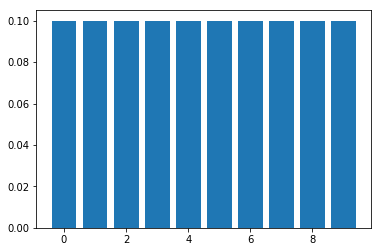

[0.063 0.069 0.076 0.084 0.092 0.101 0.111 0.122 0.135 0.148]


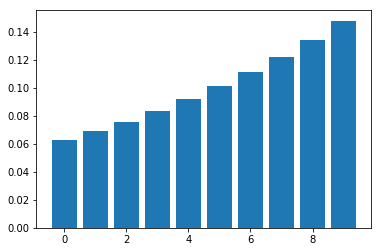

[0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]


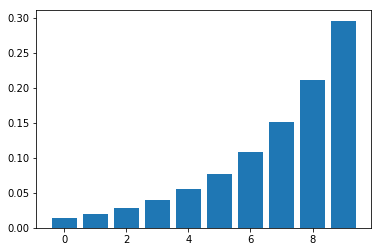

Counts for each digit (training):  [5299 6088 5386 5542 5262 4870 5338 5632 5266 5317]
Counts for each digit (test):  [ 980 1135 1032 1010  982  892  958 1028  974 1009]
max_num_examples for training =  16455
max_num_examples for test =  3014
max_num_examples_training (rounded to thousands):  16400
max_num_examples_test (rounded to thousands):  3000
deque([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])
deque([0.06274539488251159, 0.06901993437076276, 0.07592192780783903, 0.08351412058862294, 0.09186553264748525, 0.10105208591223377, 0.11115729450345715, 0.12227302395380288, 0.13450032634918319, 0.1479503589841015])
deque([0.1479503589841015, 0.06274539488251159, 0.06901993437076276, 0.07592192780783903, 0.08351412058862294, 0.09186553264748525, 0.10105208591223377, 0.11115729450345715, 0.12227302395380288, 0.13450032634918319])
deque([0.13450032634918319, 0.1479503589841015, 0.06274539488251159, 0.06901993437076276, 0.07592192780783903, 0.08351412058862294, 0.09186553264748525, 0.1

In [53]:
# Generate some distributions using geometric progressions
ratios = [1,1.05,1.1,1.2,1.4,2,4]
perms_per_ratio = 5
generated_distrs = []
for idx, ratio in enumerate(ratios):
    distr = [0.1]
    for i in range(9):
        distr.append(distr[i] * ratio)
    distr = np.array(distr)
    distr /= np.sum(distr)
    print('generated_distr[{}]:'.format(idx))
    print(', '.join([str(np.round(x, decimals=3)) for x in distr]))
#     plt.bar(range(10),distr)
#     plt.show()
    generated_distrs.append(distr.tolist())
    
# Select some of the above distribution and build others by circular shifting
base_distrs = np.array([generated_distrs[0],
                       generated_distrs[2],
                      generated_distrs[4]])
num_distributions_considered = base_distrs.shape[0]
print('\nBase distributions considered:\n', base_distrs)
for distr in base_distrs:
    print(distr)
    plt.bar(range(10),distr)
    plt.show()
    
# check the maximum number of examples that can be used using the above rule
counts_per_label_training = np.bincount(np.argmax(mnist_ds.train.labels, axis=1))
counts_per_label_test = np.bincount(np.argmax(mnist_ds.test.labels, axis=1))
print('Counts for each digit (training): ', counts_per_label_training)
print('Counts for each digit (test): ', counts_per_label_test)
counts_min_training = np.min(counts_per_label_training)
counts_min_test = np.min(counts_per_label_test)
weight_max = np.max(base_distrs)
max_num_examples_training = np.floor(counts_min_training / weight_max).astype(np.int32)
max_num_examples_test = np.floor(counts_min_test / weight_max).astype(np.int32)
print('max_num_examples for training = ', max_num_examples_training)
print('max_num_examples for test = ', max_num_examples_test)
# round to hundreds
max_num_examples_training -= max_num_examples_training % 100
max_num_examples_test -= max_num_examples_test % 100
print('max_num_examples_training (rounded to thousands): ',max_num_examples_training)
print('max_num_examples_test (rounded to thousands): ',max_num_examples_test)

# build subsets w.r.t. a distribution, with max_num_examples
distrs_used_for_training = []
for base_distr in base_distrs:
    distr = deque(base_distr)
    for i in range(10):
        print(distr)
        distrs_used_for_training.append(distr.copy())
        last_distr = distr.copy()
        distr.rotate(1)
        if np.sum(np.abs(np.array(last_distr) - np.array(distr))) < 1.e-5:
            break
print('#distributions used for training = {}'.format(len(distrs_used_for_training)))

#distributions used for training = 8
idx = 0: distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]


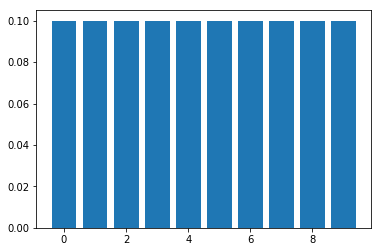

idx = 1: distr = [0.016 0.032 0.065 0.129 0.258 0.258 0.129 0.065 0.032 0.016]


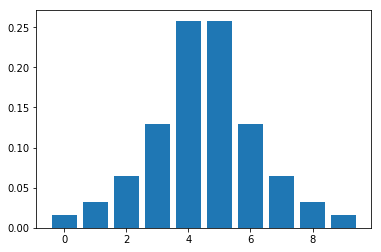

idx = 2: distr = [0.063 0.127 0.253 0.179 0.127 0.089 0.063 0.045 0.032 0.022]


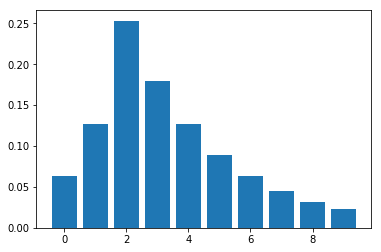

idx = 3: distr = [0.022 0.032 0.045 0.063 0.089 0.127 0.179 0.253 0.127 0.063]


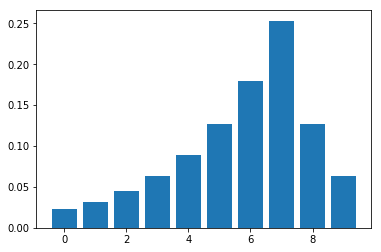

idx = 4: distr = [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]


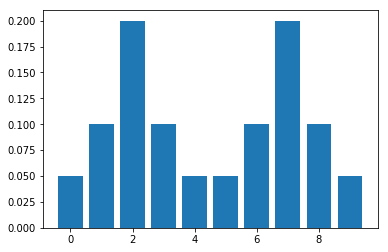

idx = 5: distr = [0.137 0.194 0.097 0.048 0.024 0.024 0.048 0.097 0.194 0.137]


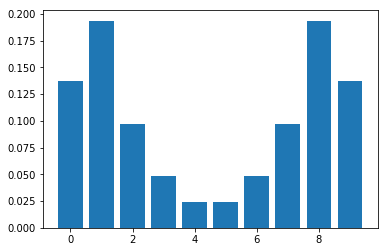

idx = 6: distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]


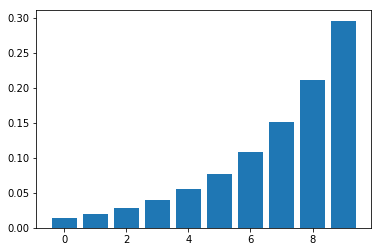

idx = 7: distr = [0.296 0.211 0.151 0.108 0.077 0.055 0.039 0.028 0.02  0.014]


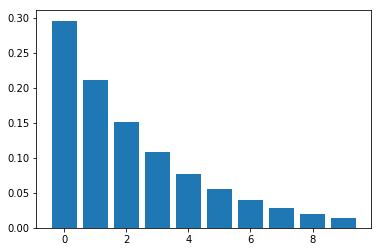

In [8]:
# Build some distributions by hand
distrs_used_for_training = []

# uniform distribution
distr = np.array([1,1,1,1,1,1,1,1,1,1])
distrs_used_for_training.append(distr/np.sum(distr))
# normal distribution centered about label 4-5
r = 2
distr = [r**1,r**2,r**3,r**4,r**5,r**5,r**4,r**3,r**2,r**1]
distrs_used_for_training.append(distr/np.sum(distr))

# skewed normal distribution centered about 2
distr = [r**3,r**4,r**5,r**4.5,r**4,r**3.5,r**3,r**2.5,r**2,r**1.5]
distrs_used_for_training.append(distr/np.sum(distr))

# skwed normal distribution centered about 7
distr = [r**1.5,r**2,r**2.5,r**3,r**3.5,r**4,r**4.5,r**5,r**4,r**3]
distrs_used_for_training.append(distr/np.sum(distr))

# bimodal normal distribution
distr = [r**1,r**2,r**3,r**2,r**1,r**1,r**2,r**3,r**2,r**1]
distrs_used_for_training.append(distr/np.sum(distr))

# bimodal skewed normal distribution
distr = [r**3.5,r**4,r**3,r**2,r**1,r**1,r**2,r**3,r**4,r**3.5]
distrs_used_for_training.append(distr/np.sum(distr))


# exponential distribution
r=1.4
distr = [r**1,r**2,r**3,r**4,r**5,r**6,r**7,r**8,r**9,r**10]
distrs_used_for_training.append(distr/np.sum(distr))

# exponential distribution
r=1.4
distr = [r**10,r**9,r**8,r**7,r**6,r**5,r**4,r**3,r**2,r**1]
distrs_used_for_training.append(distr/np.sum(distr))

print('#distributions used for training = {}'.format(len(distrs_used_for_training)))
for idx, distr in enumerate(distrs_used_for_training):
    print('idx = {}: distr = {}'.format(idx,distr))
    plt.bar(range(10), distr)
    plt.show()

### 2. Train LeNet5 models by imposing the considered distributions on the original MNIST dataset



k = 0: Imposed distribution: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Imposing distr: num_examples_from_each_class =  [4930 4930 4930 4930 4930 4930 4930 4930 4930 4930]
Imposing distr: num_examples_from_each_class =  [180 180 180 180 180 180 180 180 180 180]
Imposing distr: num_examples_from_each_class =  [300 300 300 300 300 300 300 300 300 300]
2018-03-21 01:09:32,164 - 
        training data set: images = (49300, 28, 28, 1), labels = (49300, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        
2018-03-21 01:09:33,874 - Training will use num_examples = 49152 from training set size = 49300
2018-03-21 01:10:08,934 - EPOCH 1 --- Training: loss = 0.957, acc = 0.680; Validation: loss = 0.185, acc = 0.947;
2018-03-21 01:10:44,

2018-03-21 01:41:03,571 - EPOCH 15 --- Training: loss = 0.059, acc = 0.984; Validation: loss = 0.034, acc = 0.989;
2018-03-21 01:41:37,637 - EPOCH 16 --- Training: loss = 0.057, acc = 0.985; Validation: loss = 0.038, acc = 0.990;
2018-03-21 01:42:11,300 - EPOCH 17 --- Training: loss = 0.052, acc = 0.986; Validation: loss = 0.039, acc = 0.991;
2018-03-21 01:42:44,938 - EPOCH 18 --- Training: loss = 0.050, acc = 0.986; Validation: loss = 0.032, acc = 0.991;
2018-03-21 01:43:18,879 - EPOCH 19 --- Training: loss = 0.047, acc = 0.987; Validation: loss = 0.040, acc = 0.991;
2018-03-21 01:43:52,802 - EPOCH 20 --- Training: loss = 0.044, acc = 0.987; Validation: loss = 0.036, acc = 0.989;
2018-03-21 01:44:26,444 - EPOCH 21 --- Training: loss = 0.043, acc = 0.988; Validation: loss = 0.031, acc = 0.991;
2018-03-21 01:45:00,062 - EPOCH 22 --- Training: loss = 0.041, acc = 0.988; Validation: loss = 0.032, acc = 0.991;
2018-03-21 01:45:34,053 - EPOCH 23 --- Training: loss = 0.041, acc = 0.988; Vali

2018-03-21 02:16:03,372 - EPOCH 37 --- Training: loss = 0.024, acc = 0.993; Validation: loss = 0.029, acc = 0.993;
2018-03-21 02:16:36,849 - EPOCH 38 --- Training: loss = 0.023, acc = 0.993; Validation: loss = 0.031, acc = 0.996;
2018-03-21 02:17:10,433 - EPOCH 39 --- Training: loss = 0.025, acc = 0.993; Validation: loss = 0.033, acc = 0.993;
2018-03-21 02:17:44,639 - EPOCH 40 --- Training: loss = 0.021, acc = 0.994; Validation: loss = 0.044, acc = 0.994;
2018-03-21 02:17:45,749 - Model saved into C:\Users\diaco\Desktop\ML\Licenta\finalproject\mnist/results/Lenet5_with_imposed_distr_2__2018_03_21---01_55.model.ckpt
2018-03-21 02:17:47,192 - Test loss = 0.042 accuracy = 0.989


k = 3: Imposed distribution: [0.022 0.032 0.045 0.063 0.089 0.127 0.179 0.253 0.127 0.063]
Imposing distr: num_examples_from_each_class =  [ 1102  1559  2205  3119  4411  6239  8823 12484  6239  3119]
Imposing distr: num_examples_from_each_class =  [ 40  56  80 113 161 227 322 461 227 113]
Imposing distr: num_exa

2018-03-21 02:45:30,253 - EPOCH 9 --- Training: loss = 0.087, acc = 0.977; Validation: loss = 0.040, acc = 0.988;
2018-03-21 02:46:03,848 - EPOCH 10 --- Training: loss = 0.082, acc = 0.978; Validation: loss = 0.040, acc = 0.986;
2018-03-21 02:46:37,291 - EPOCH 11 --- Training: loss = 0.078, acc = 0.978; Validation: loss = 0.044, acc = 0.987;
2018-03-21 02:47:11,055 - EPOCH 12 --- Training: loss = 0.071, acc = 0.980; Validation: loss = 0.039, acc = 0.987;
2018-03-21 02:47:45,170 - EPOCH 13 --- Training: loss = 0.065, acc = 0.982; Validation: loss = 0.042, acc = 0.987;
2018-03-21 02:48:18,787 - EPOCH 14 --- Training: loss = 0.066, acc = 0.981; Validation: loss = 0.037, acc = 0.987;
2018-03-21 02:48:52,341 - EPOCH 15 --- Training: loss = 0.060, acc = 0.983; Validation: loss = 0.047, acc = 0.988;
2018-03-21 02:49:26,335 - EPOCH 16 --- Training: loss = 0.057, acc = 0.984; Validation: loss = 0.037, acc = 0.988;
2018-03-21 02:49:59,897 - EPOCH 17 --- Training: loss = 0.054, acc = 0.984; Valid

2018-03-21 03:20:29,313 - EPOCH 31 --- Training: loss = 0.032, acc = 0.991; Validation: loss = 0.034, acc = 0.990;
2018-03-21 03:21:02,835 - EPOCH 32 --- Training: loss = 0.032, acc = 0.990; Validation: loss = 0.033, acc = 0.992;
2018-03-21 03:21:36,786 - EPOCH 33 --- Training: loss = 0.030, acc = 0.991; Validation: loss = 0.038, acc = 0.991;
2018-03-21 03:22:10,313 - EPOCH 34 --- Training: loss = 0.030, acc = 0.991; Validation: loss = 0.039, acc = 0.991;
2018-03-21 03:22:43,885 - EPOCH 35 --- Training: loss = 0.029, acc = 0.991; Validation: loss = 0.038, acc = 0.989;
2018-03-21 03:23:17,478 - EPOCH 36 --- Training: loss = 0.028, acc = 0.991; Validation: loss = 0.037, acc = 0.989;
2018-03-21 03:23:51,670 - EPOCH 37 --- Training: loss = 0.030, acc = 0.991; Validation: loss = 0.034, acc = 0.991;
2018-03-21 03:24:25,450 - EPOCH 38 --- Training: loss = 0.028, acc = 0.991; Validation: loss = 0.035, acc = 0.990;
2018-03-21 03:24:59,960 - EPOCH 39 --- Training: loss = 0.026, acc = 0.992; Vali

2018-03-21 03:49:50,660 - EPOCH 2 --- Training: loss = 0.229, acc = 0.933; Validation: loss = 0.089, acc = 0.976;
2018-03-21 03:50:24,305 - EPOCH 3 --- Training: loss = 0.152, acc = 0.956; Validation: loss = 0.067, acc = 0.981;
2018-03-21 03:50:57,873 - EPOCH 4 --- Training: loss = 0.116, acc = 0.968; Validation: loss = 0.052, acc = 0.984;
2018-03-21 03:51:31,946 - EPOCH 5 --- Training: loss = 0.098, acc = 0.973; Validation: loss = 0.046, acc = 0.990;
2018-03-21 03:52:05,618 - EPOCH 6 --- Training: loss = 0.086, acc = 0.976; Validation: loss = 0.042, acc = 0.987;
2018-03-21 03:52:39,135 - EPOCH 7 --- Training: loss = 0.079, acc = 0.978; Validation: loss = 0.040, acc = 0.988;
2018-03-21 03:53:12,716 - EPOCH 8 --- Training: loss = 0.071, acc = 0.981; Validation: loss = 0.036, acc = 0.989;
2018-03-21 03:53:46,754 - EPOCH 9 --- Training: loss = 0.064, acc = 0.982; Validation: loss = 0.039, acc = 0.991;
2018-03-21 03:54:20,303 - EPOCH 10 --- Training: loss = 0.060, acc = 0.983; Validation: 

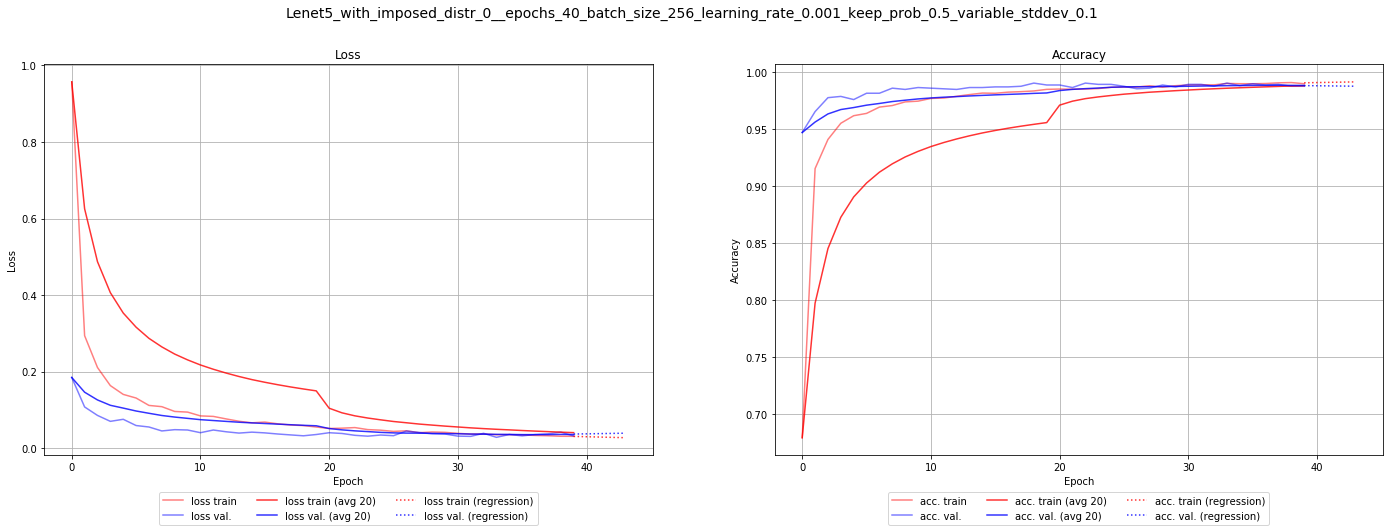

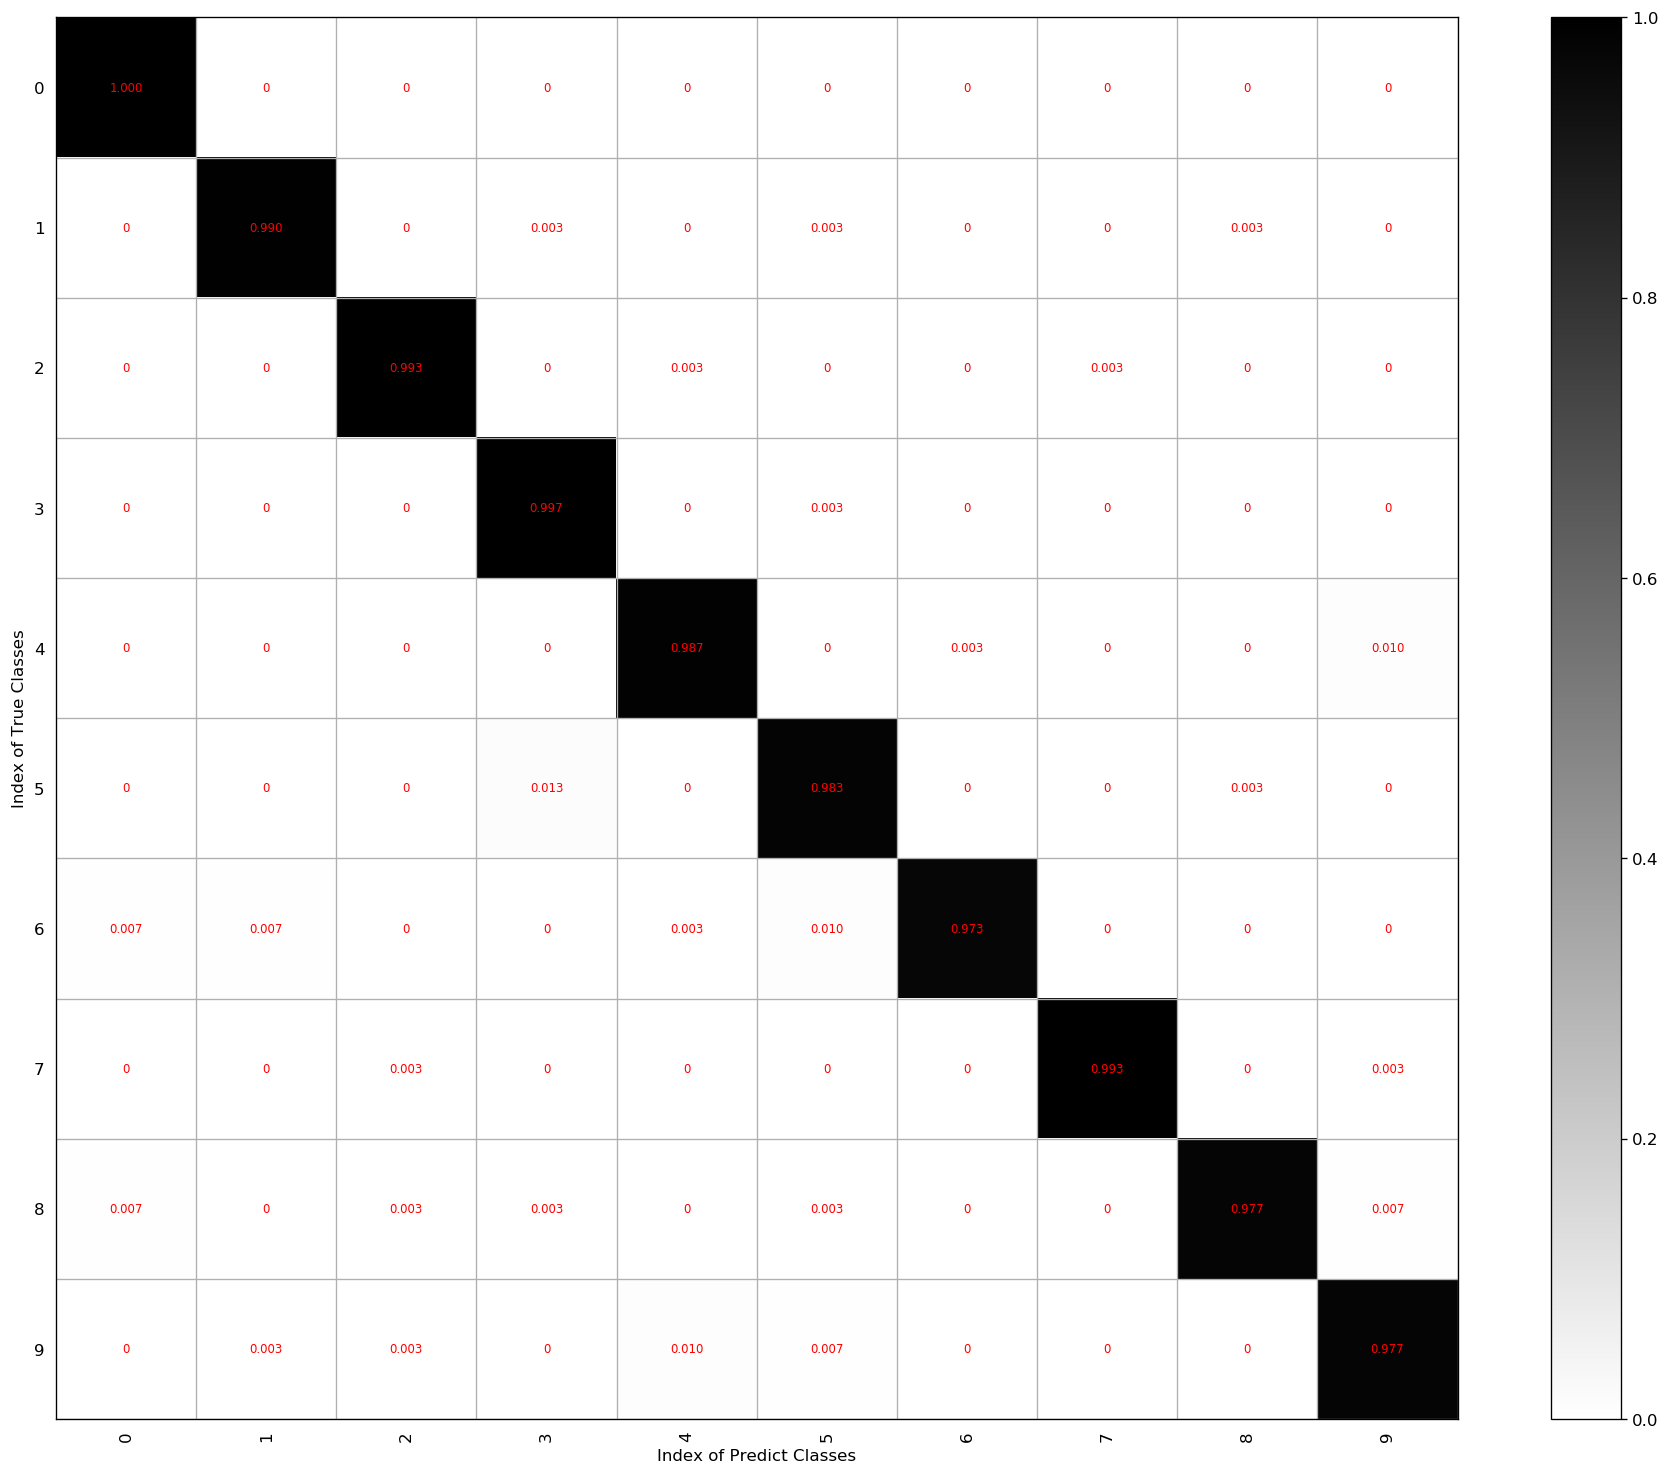

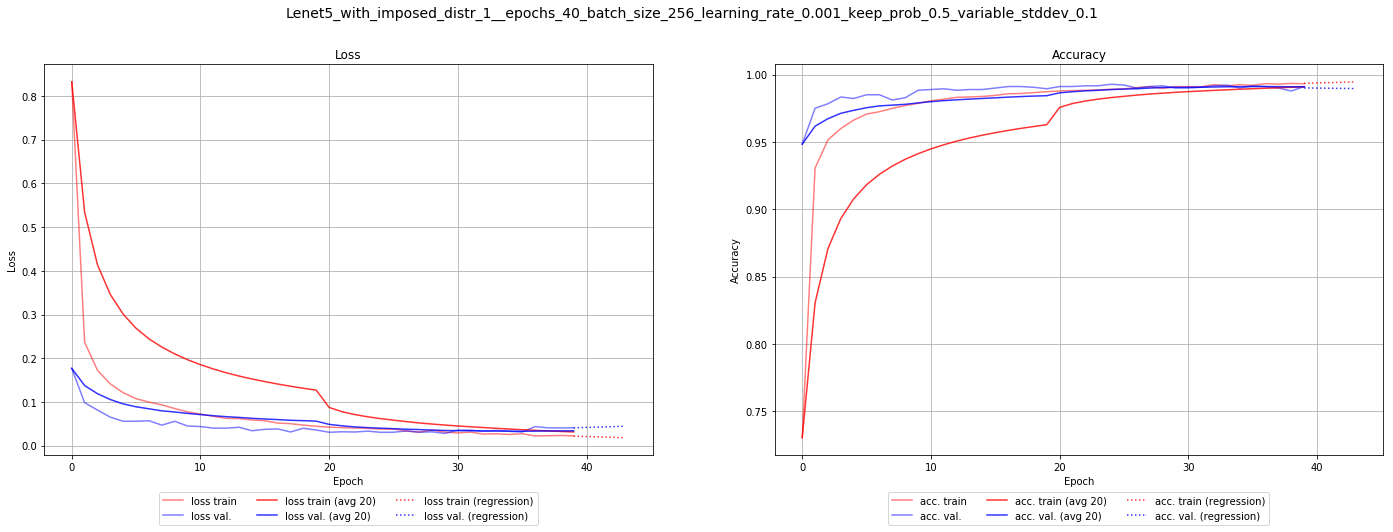

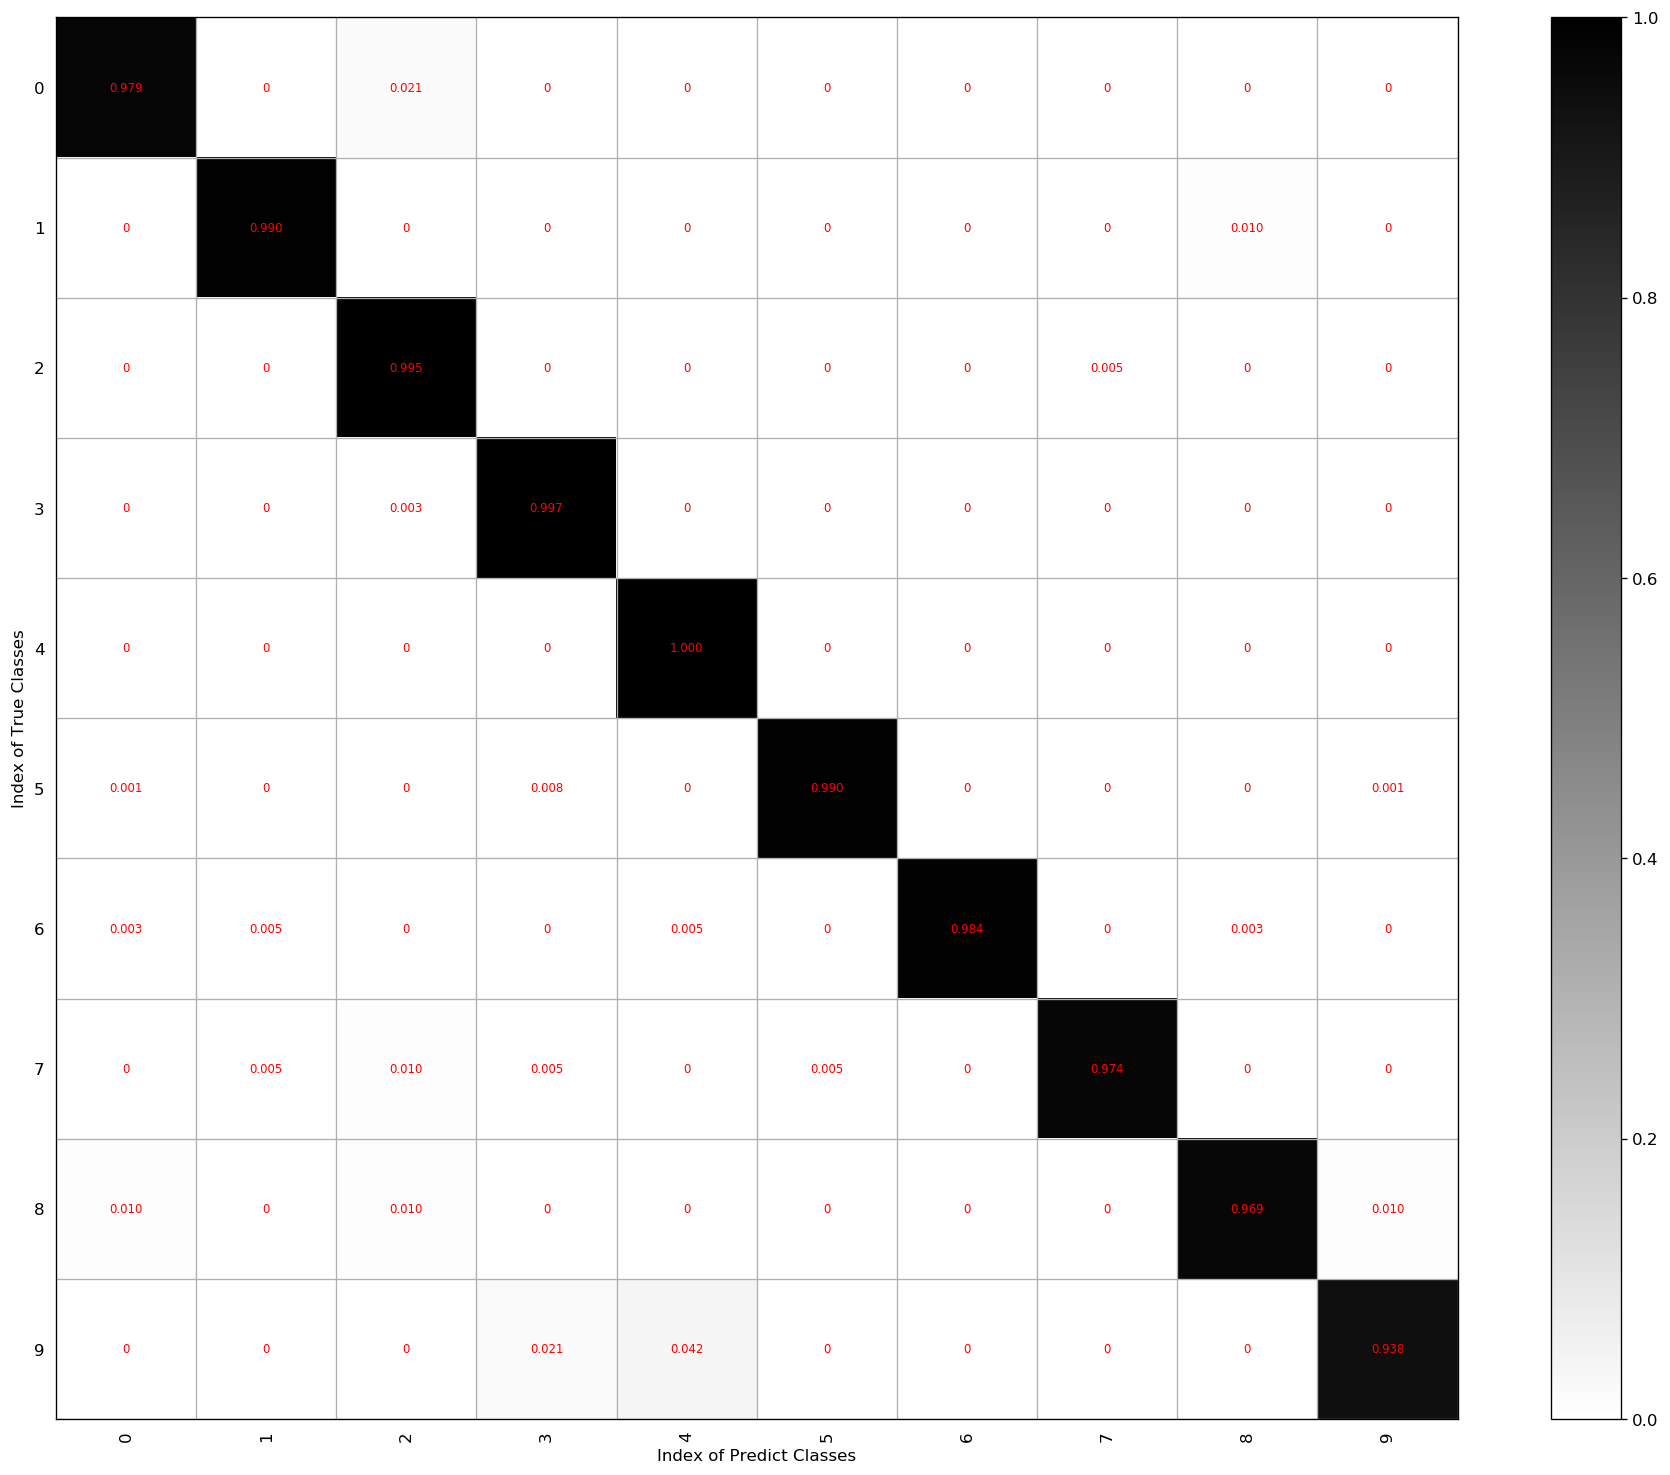

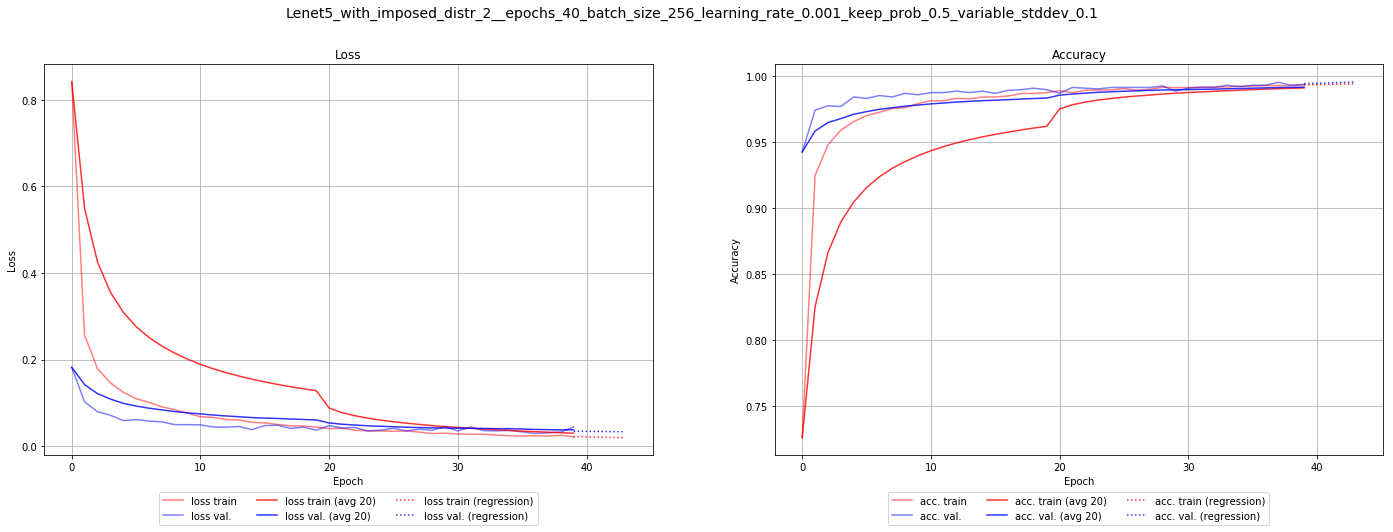

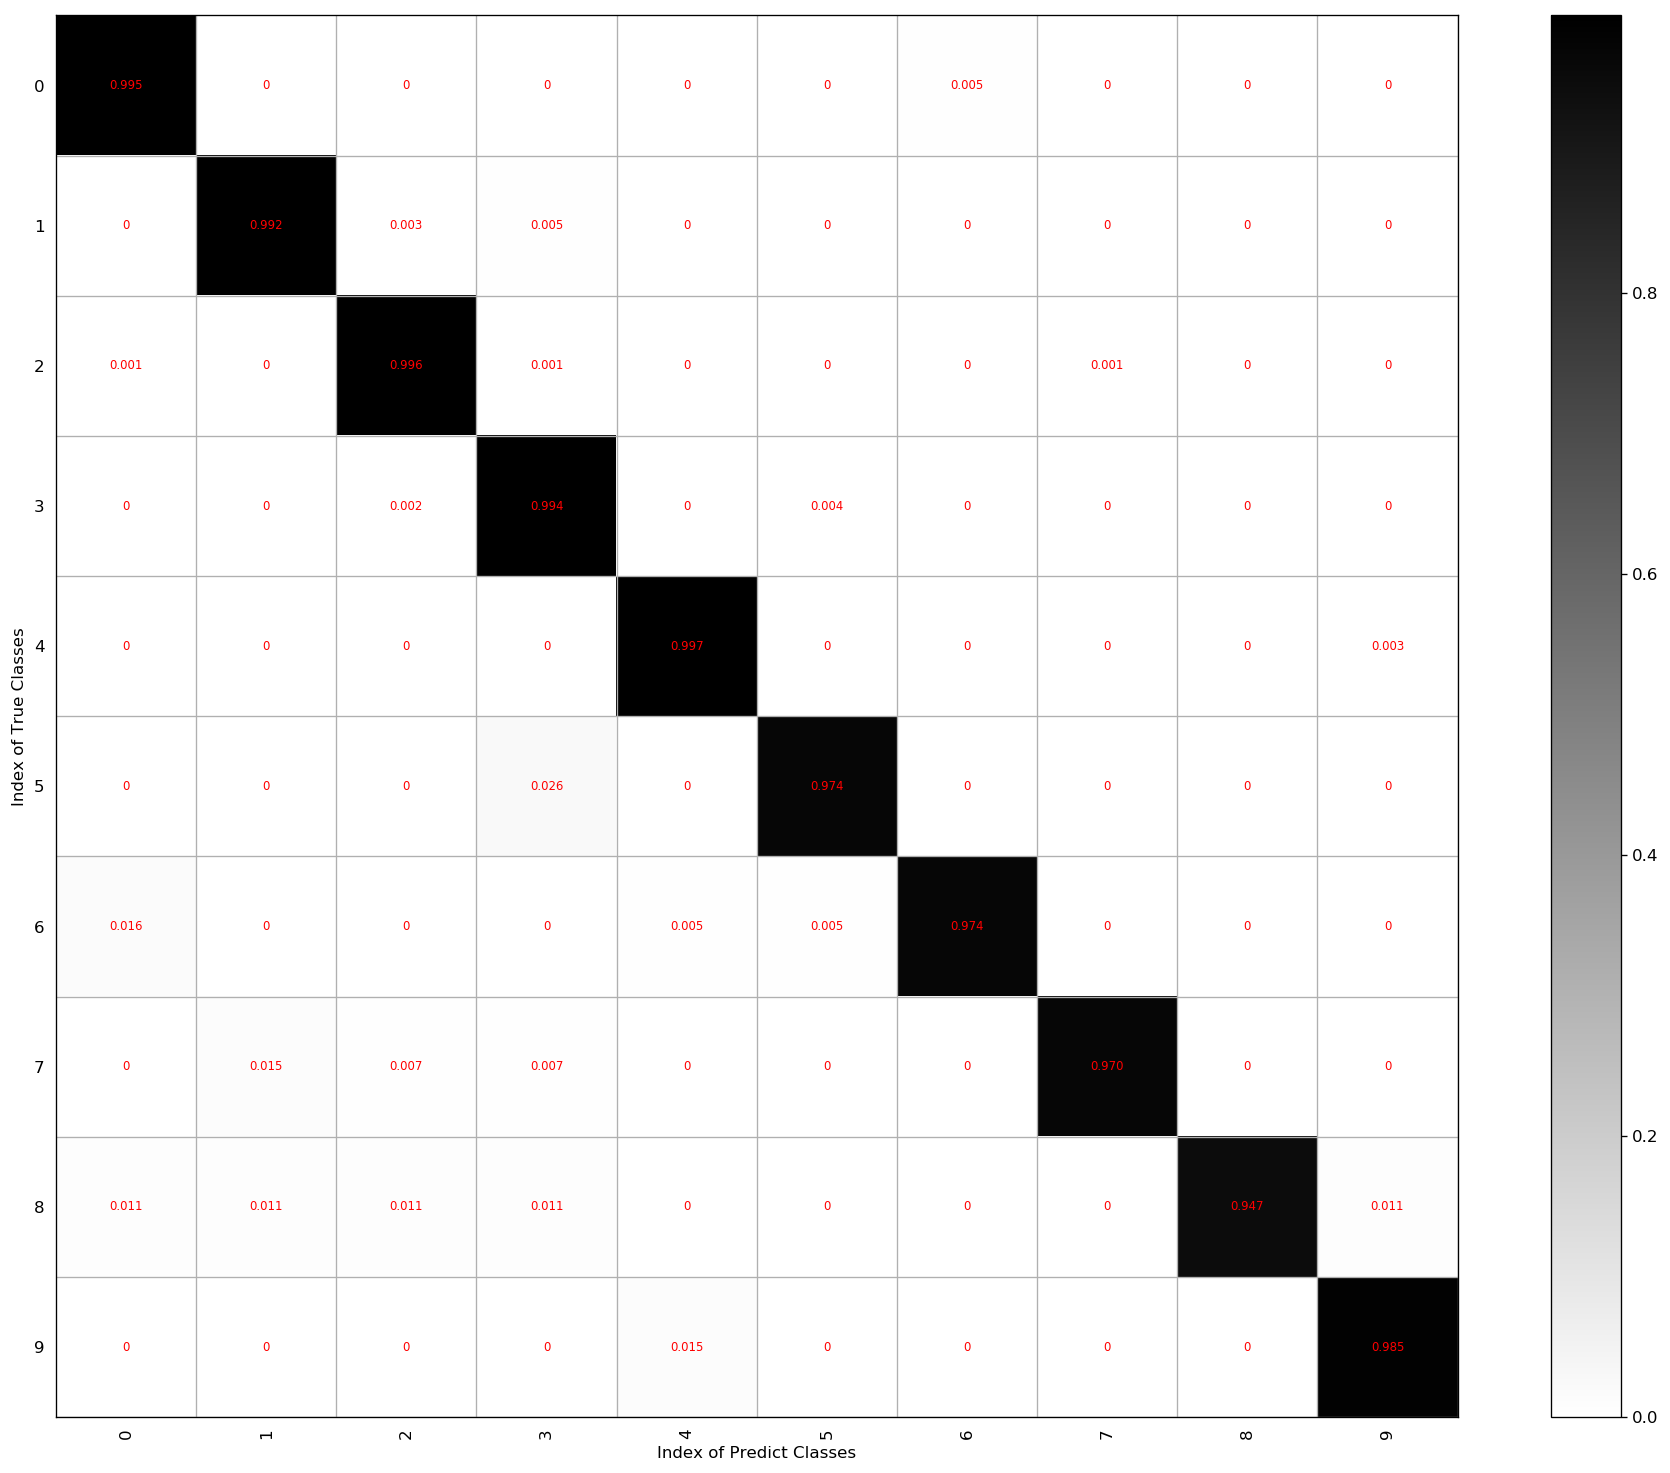

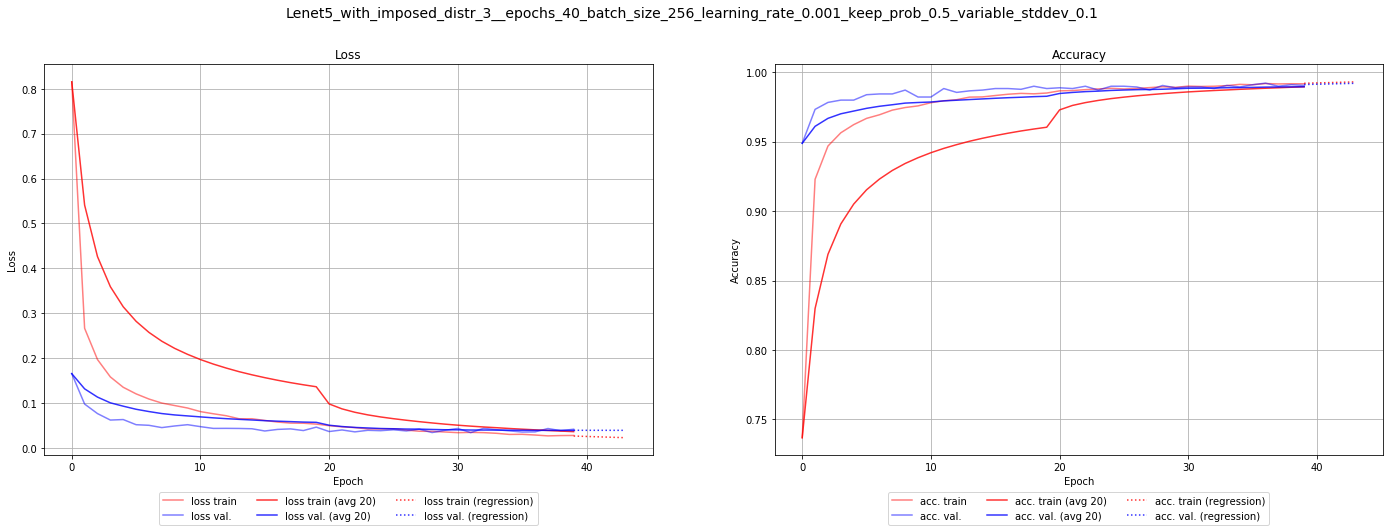

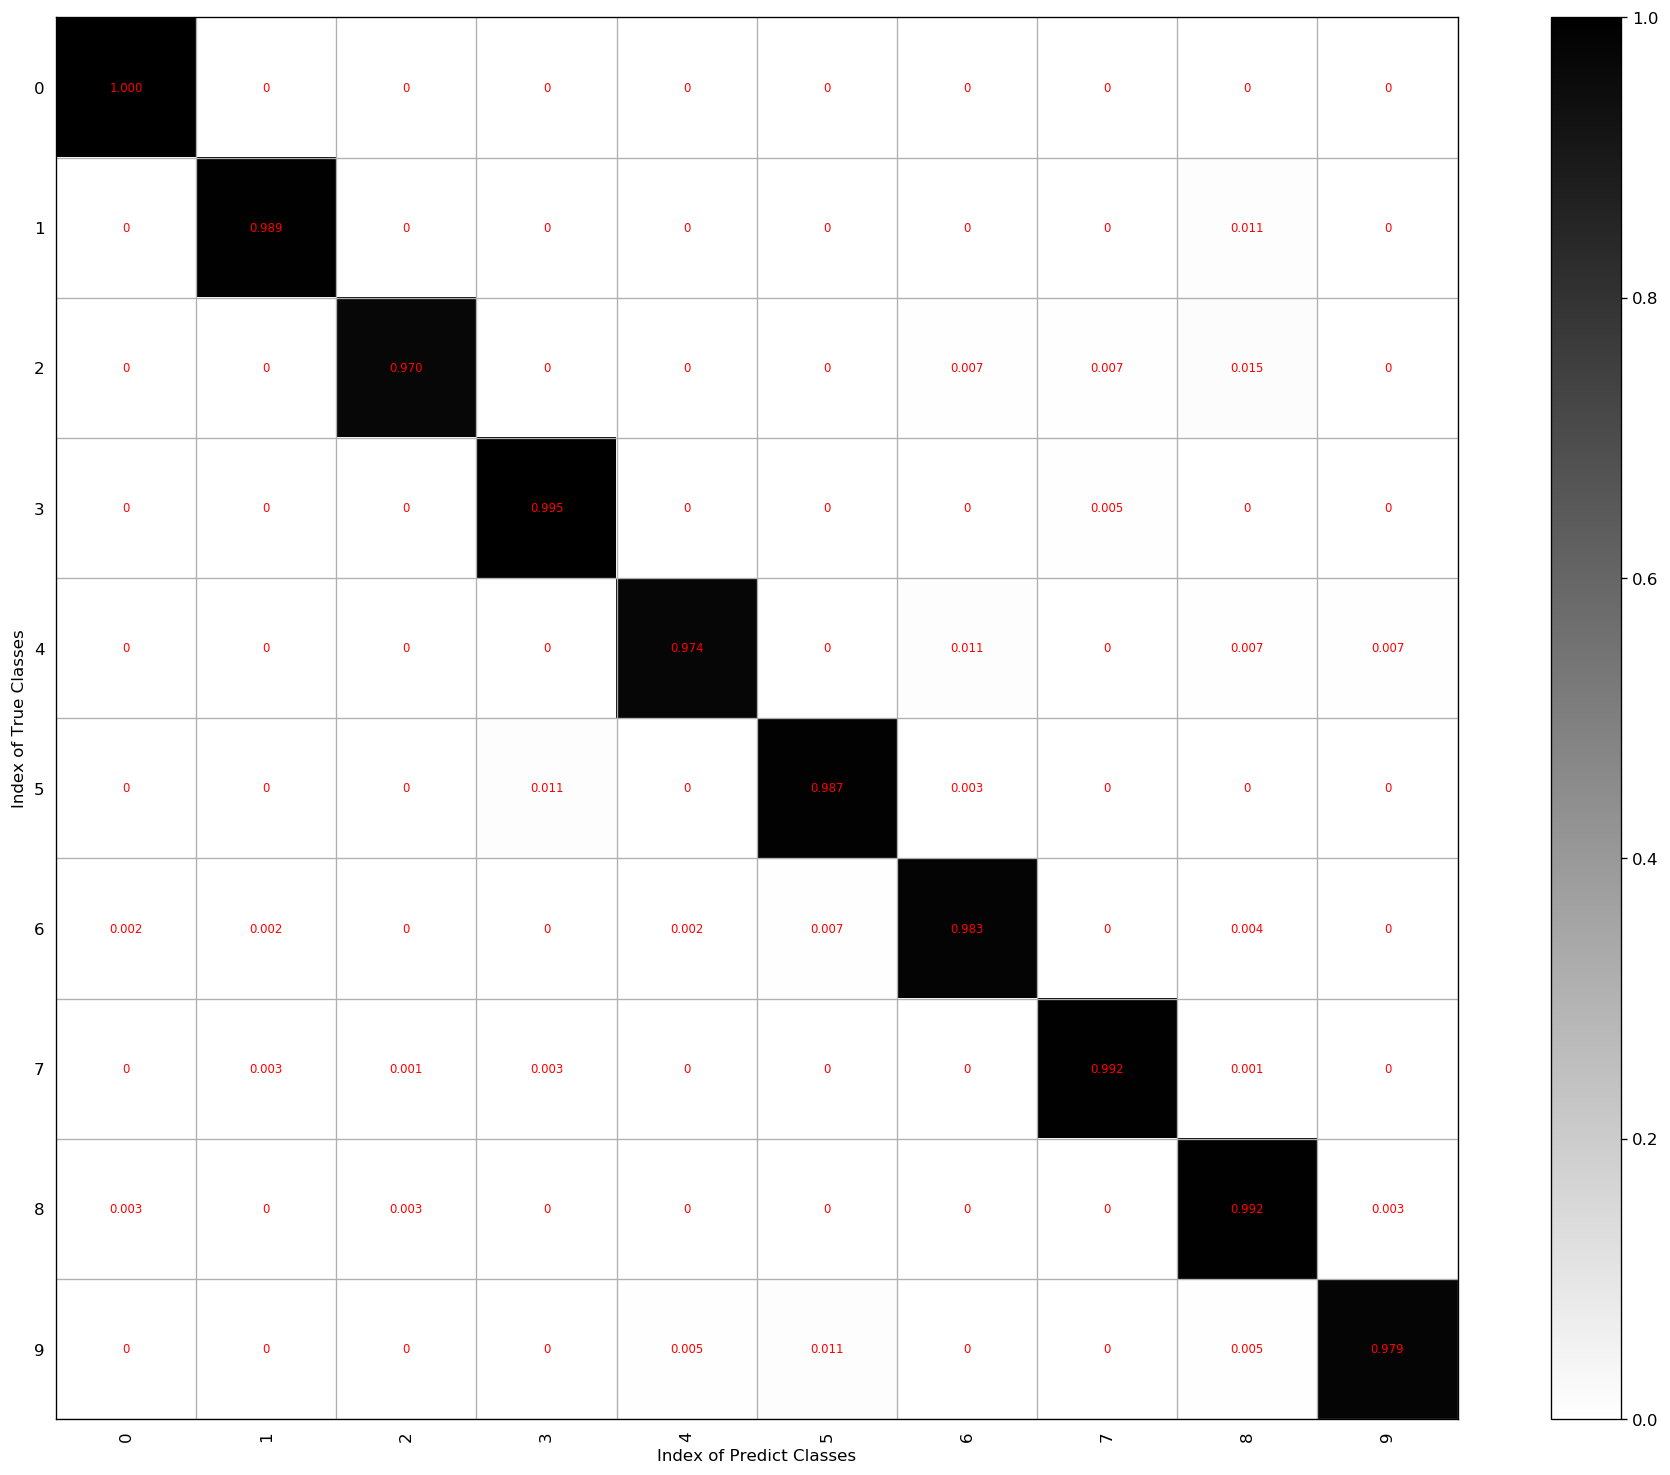

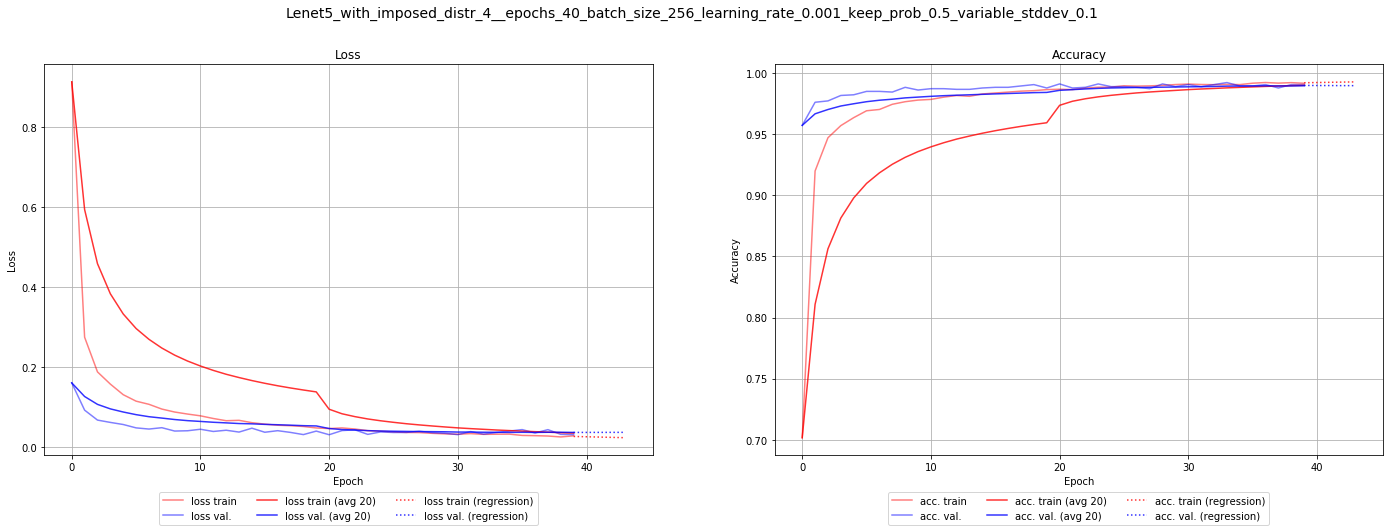

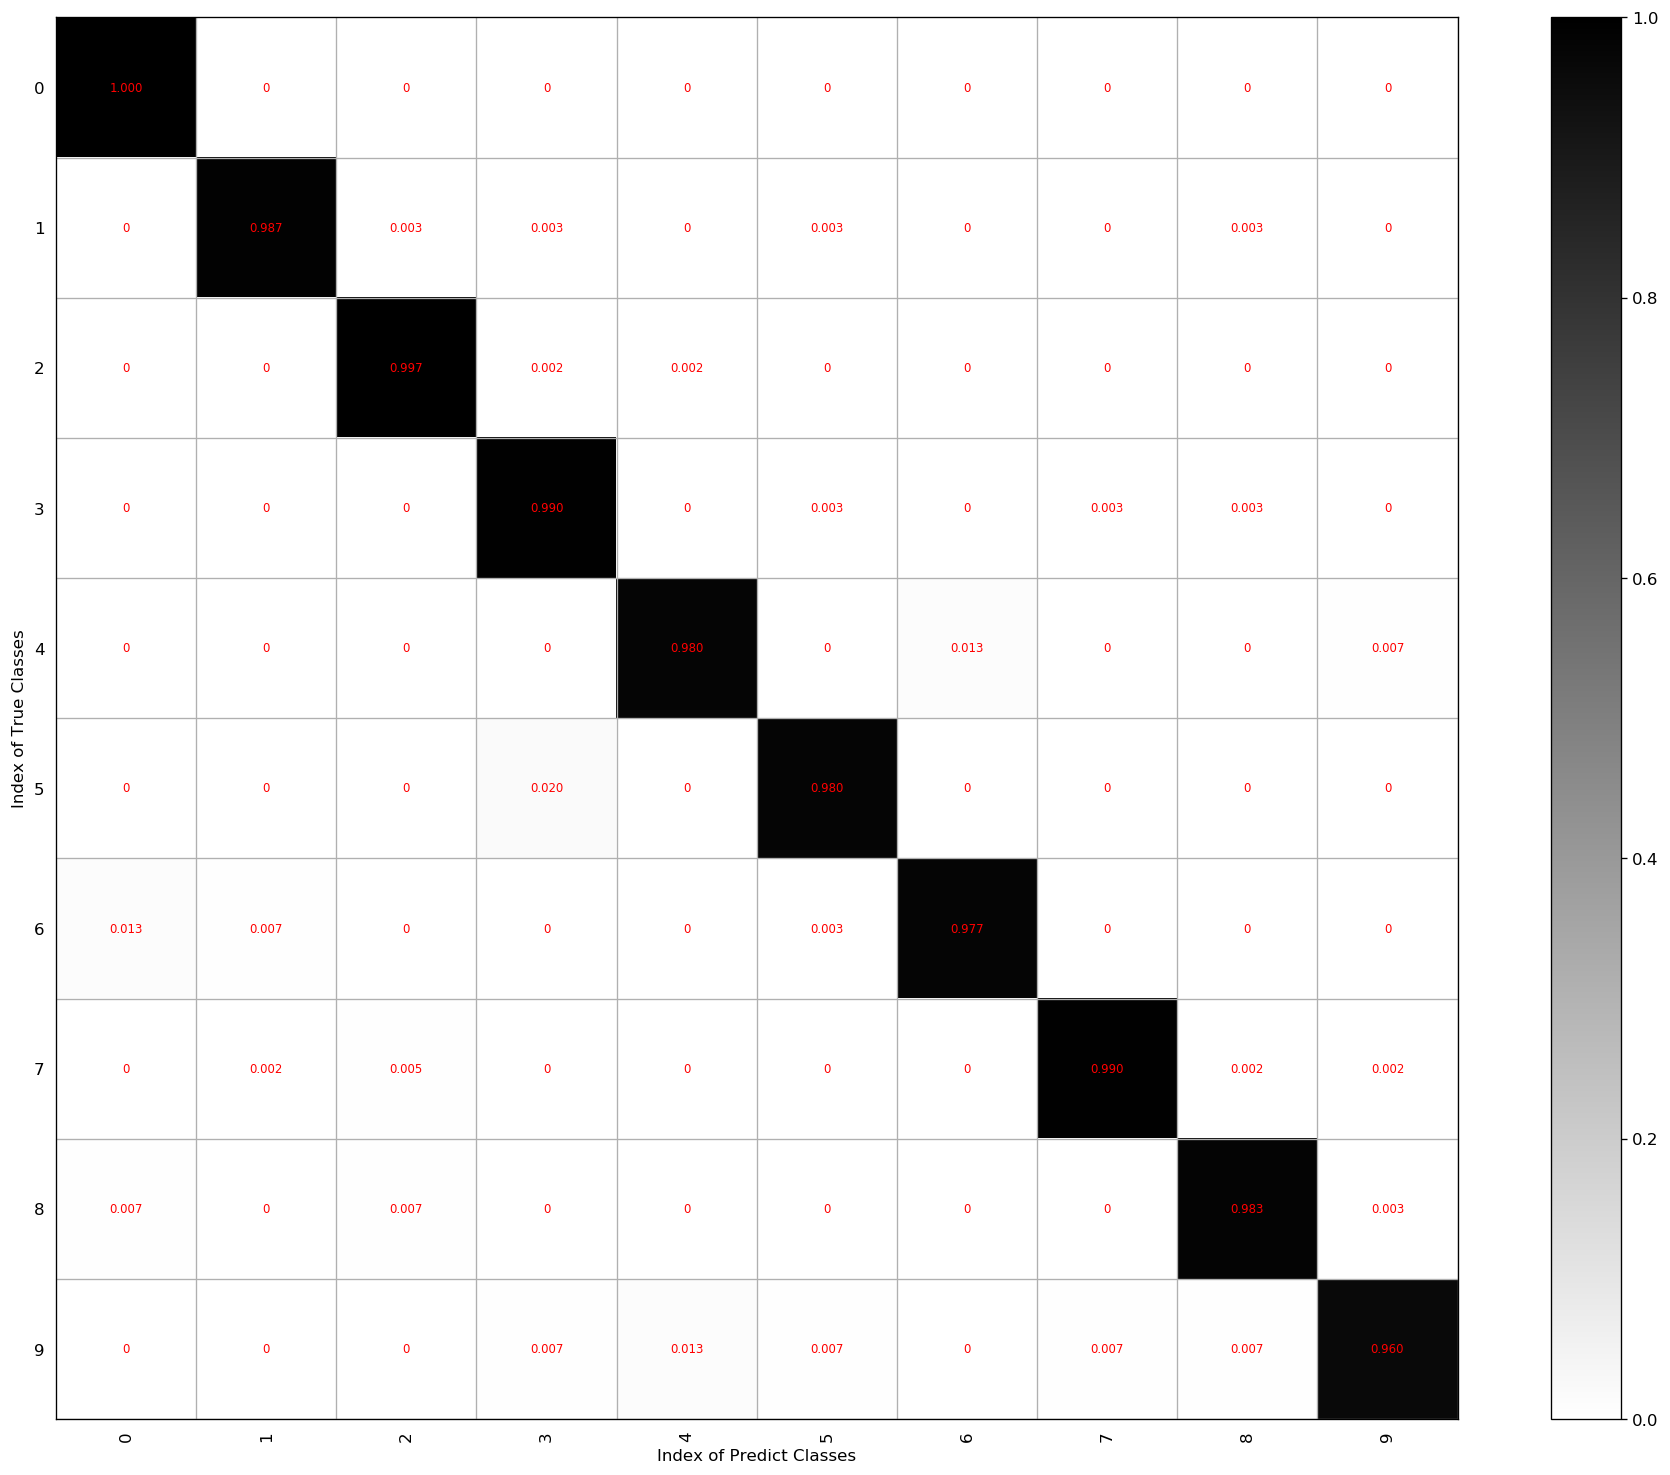

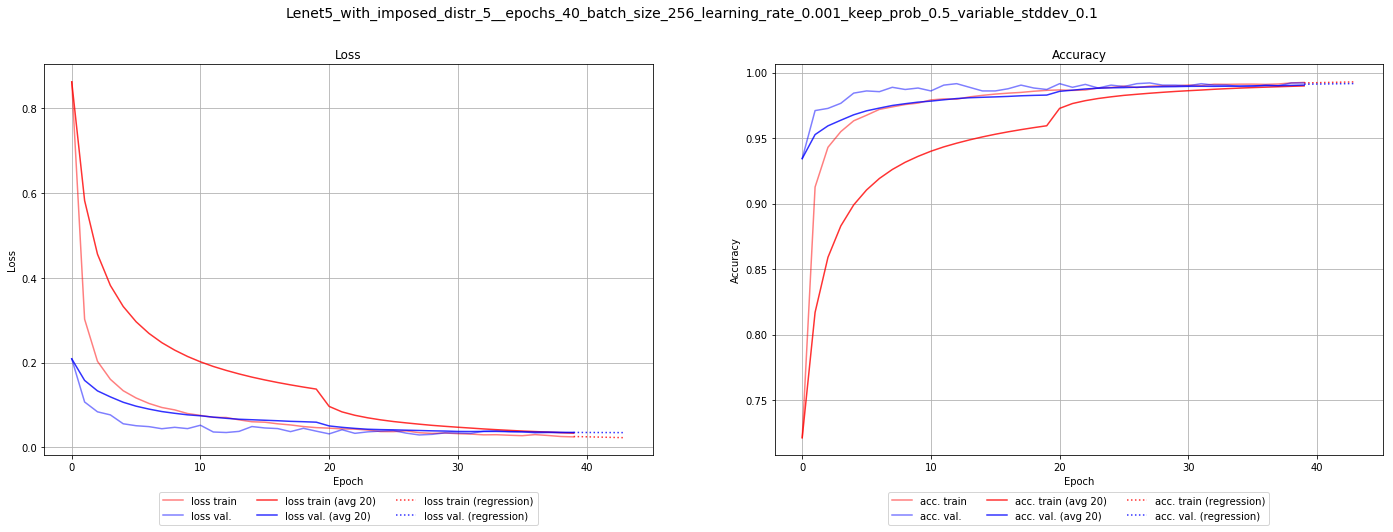

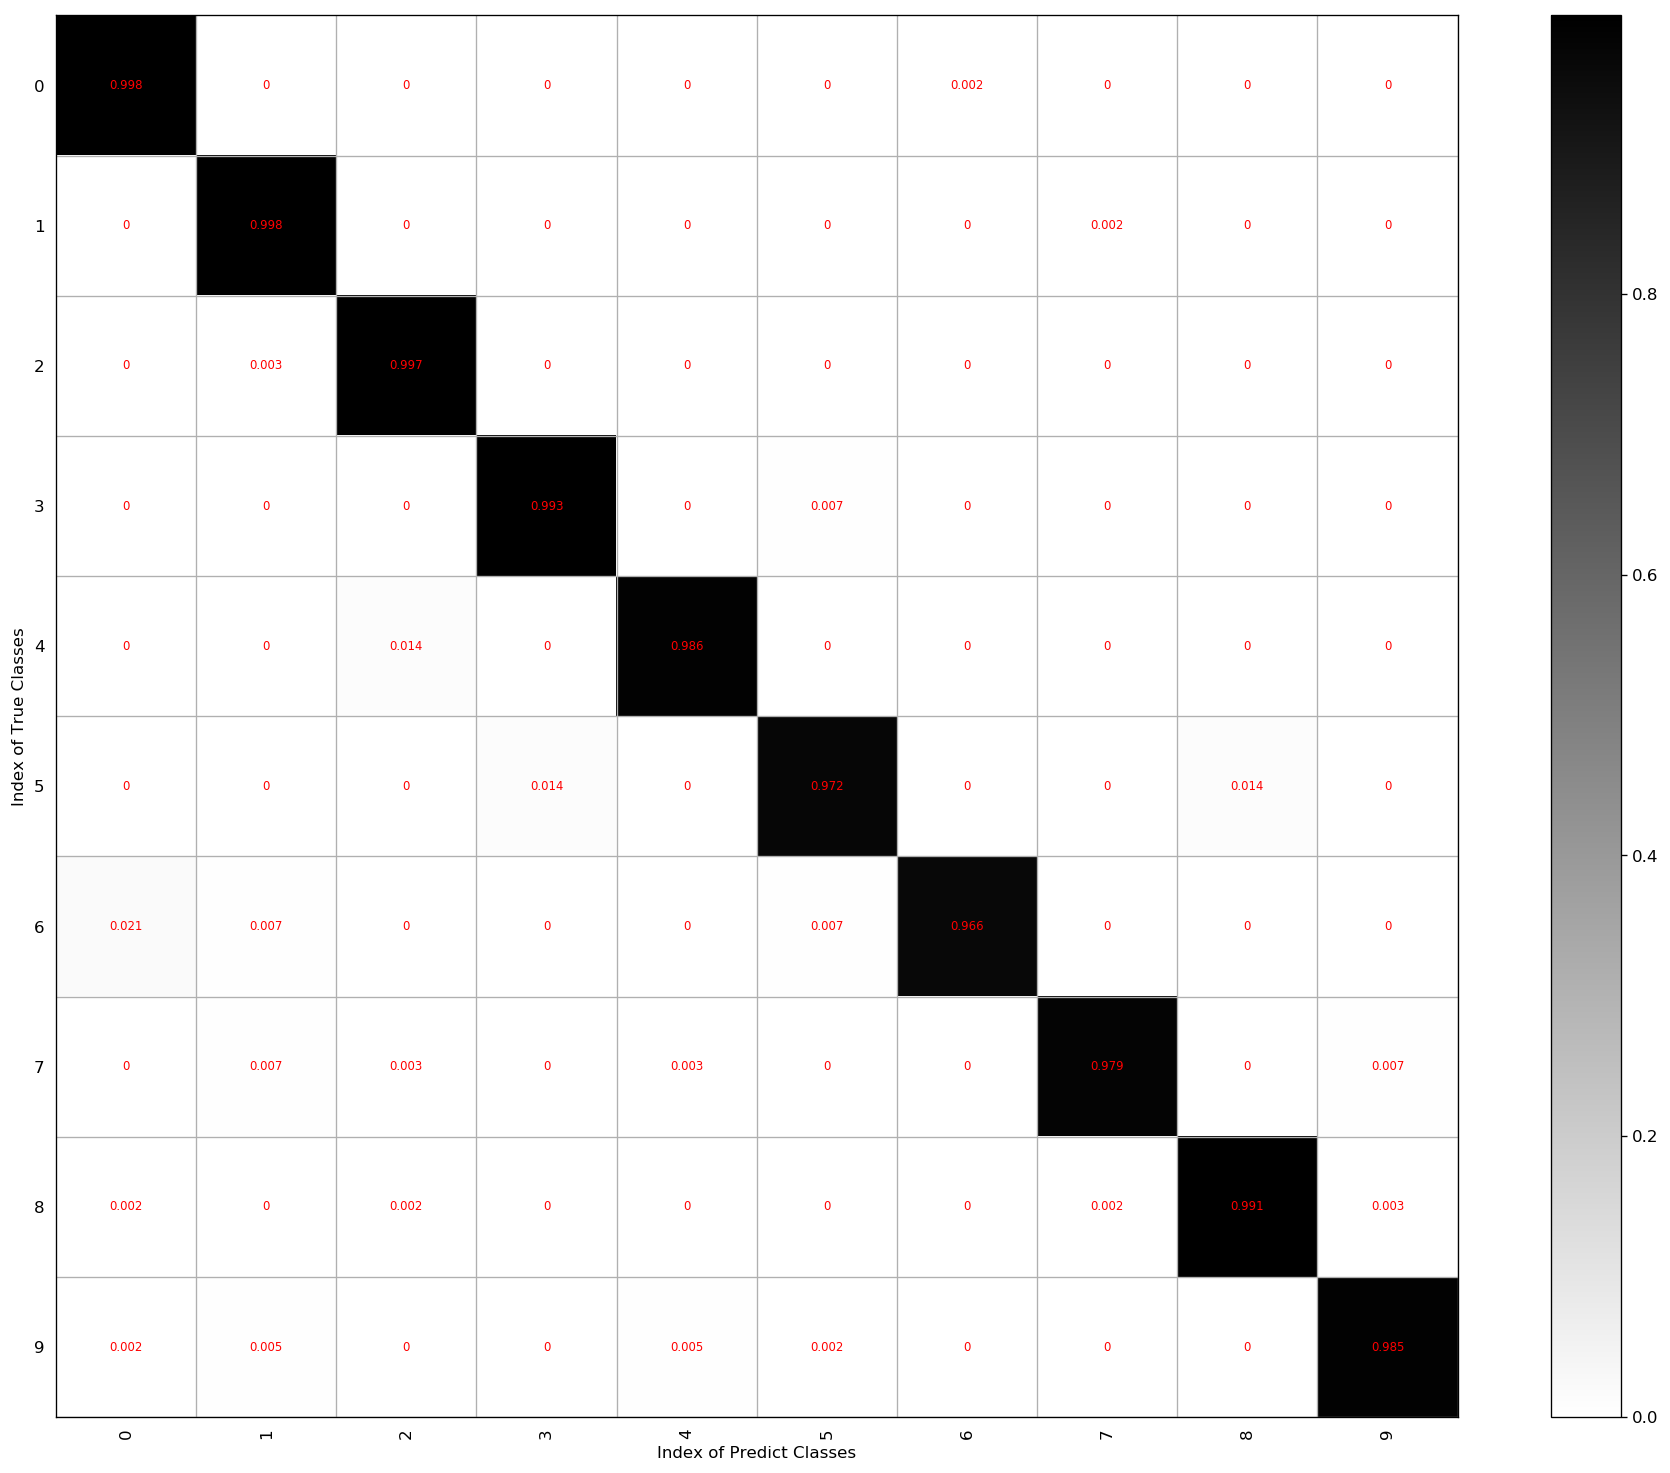

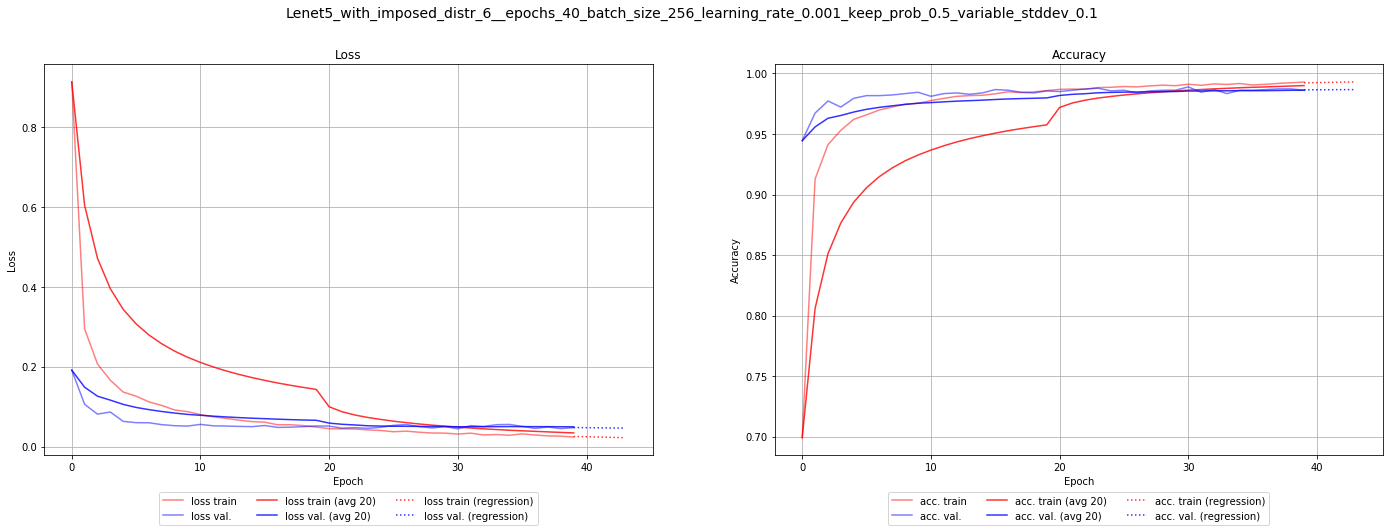

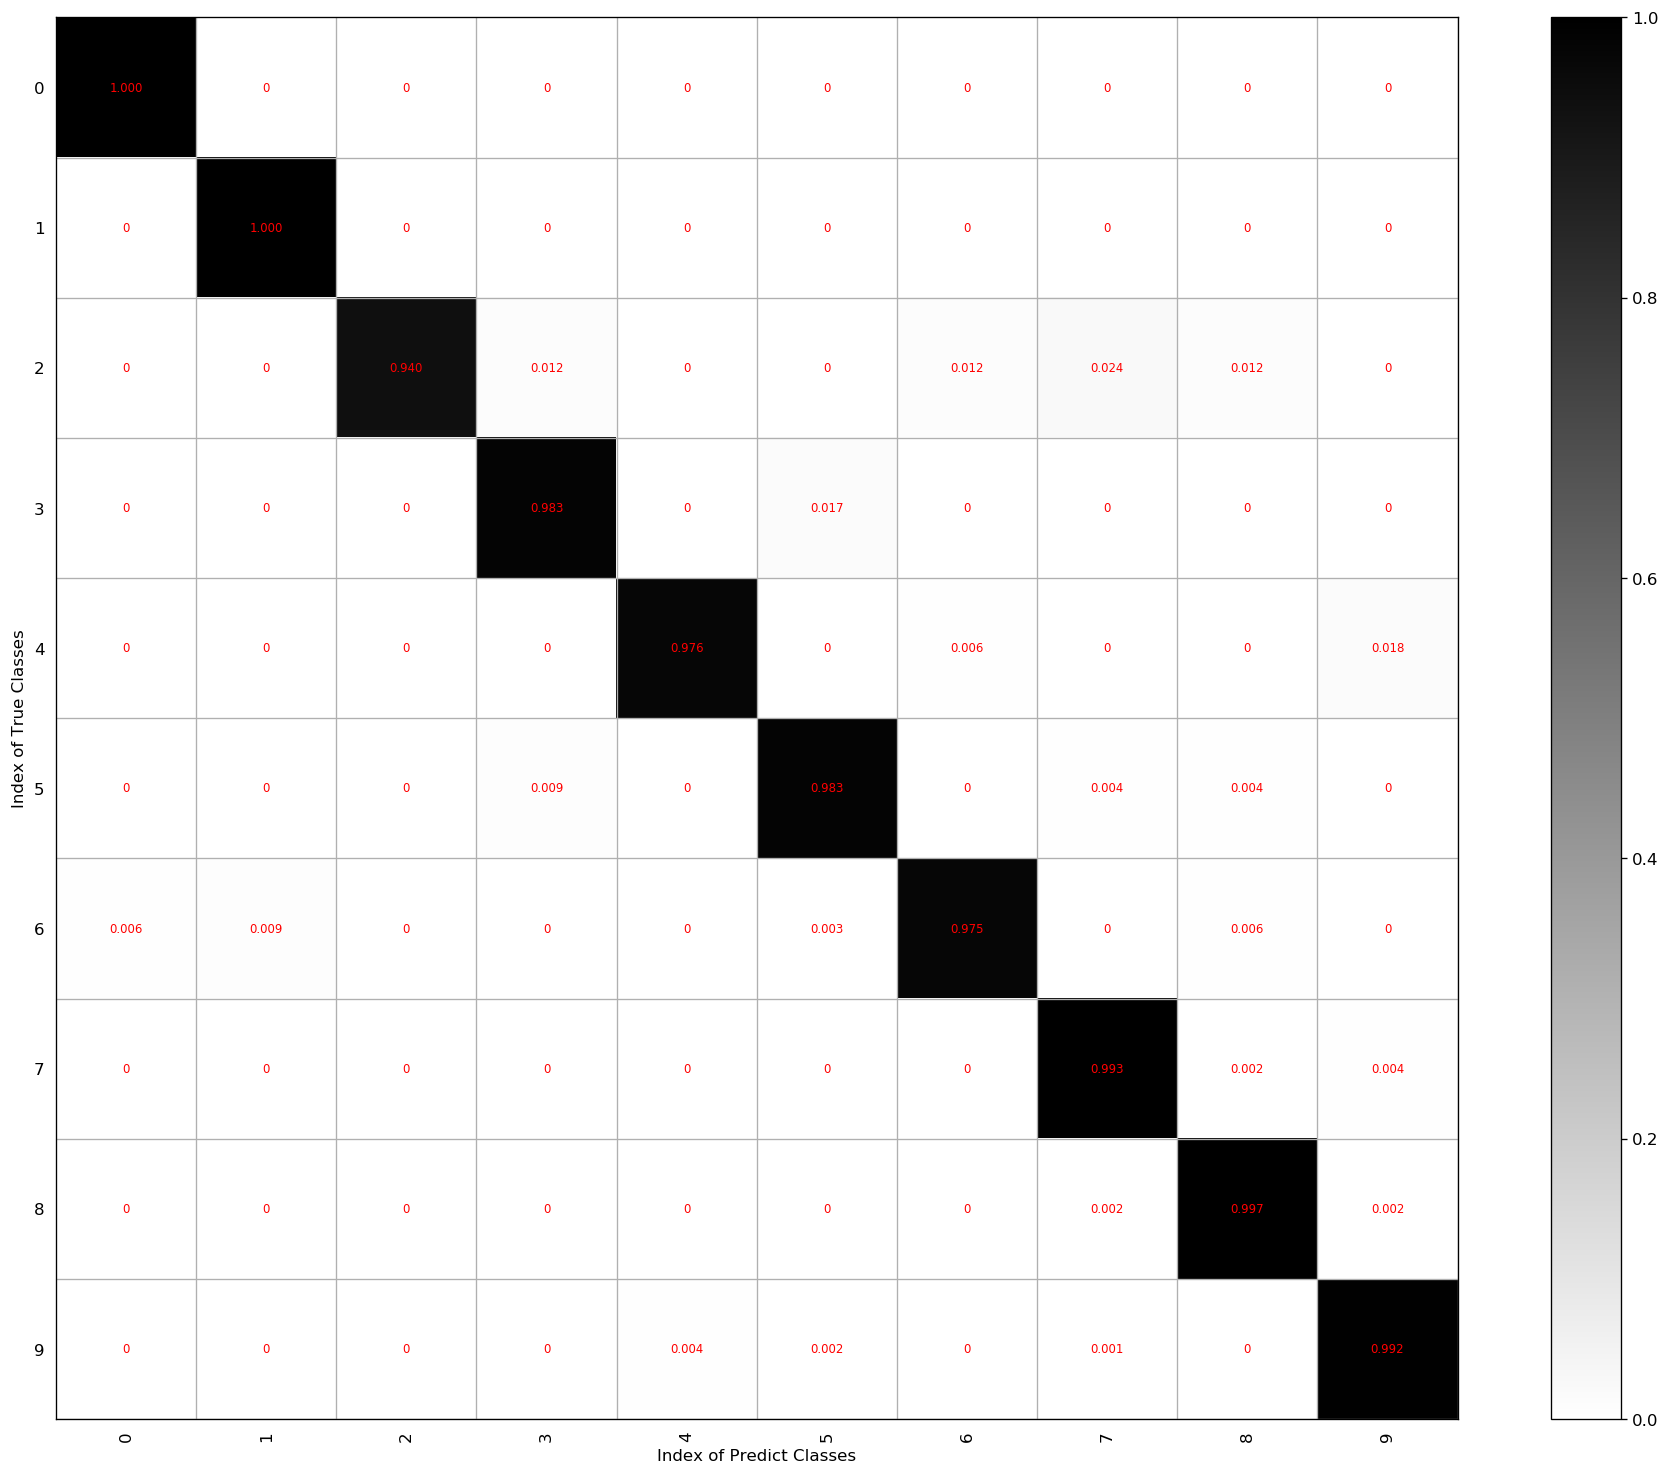

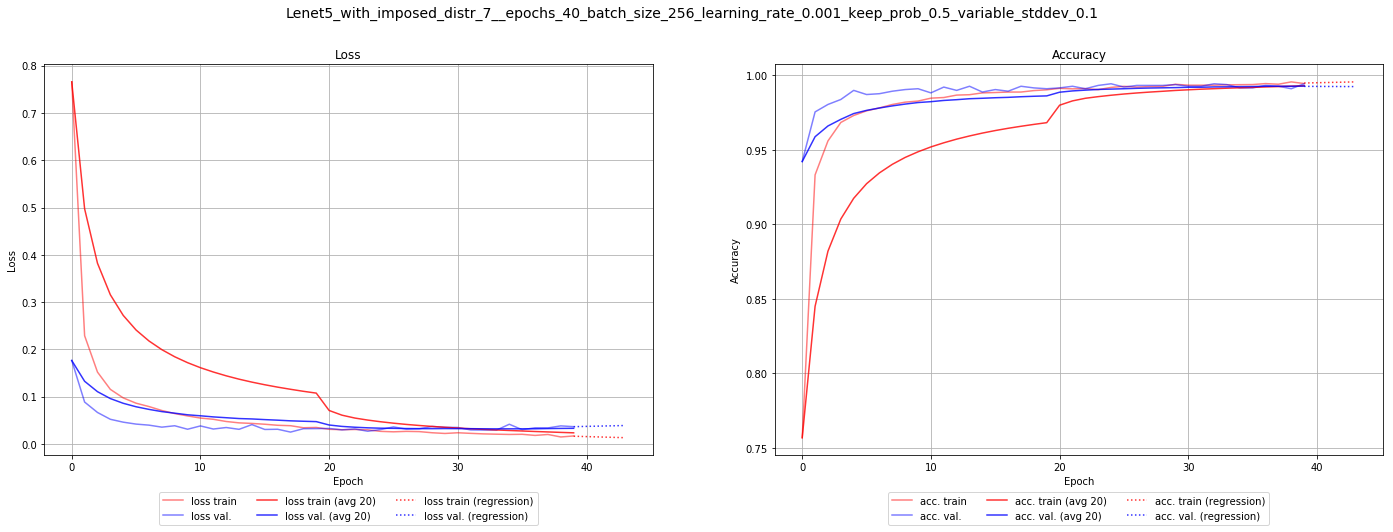

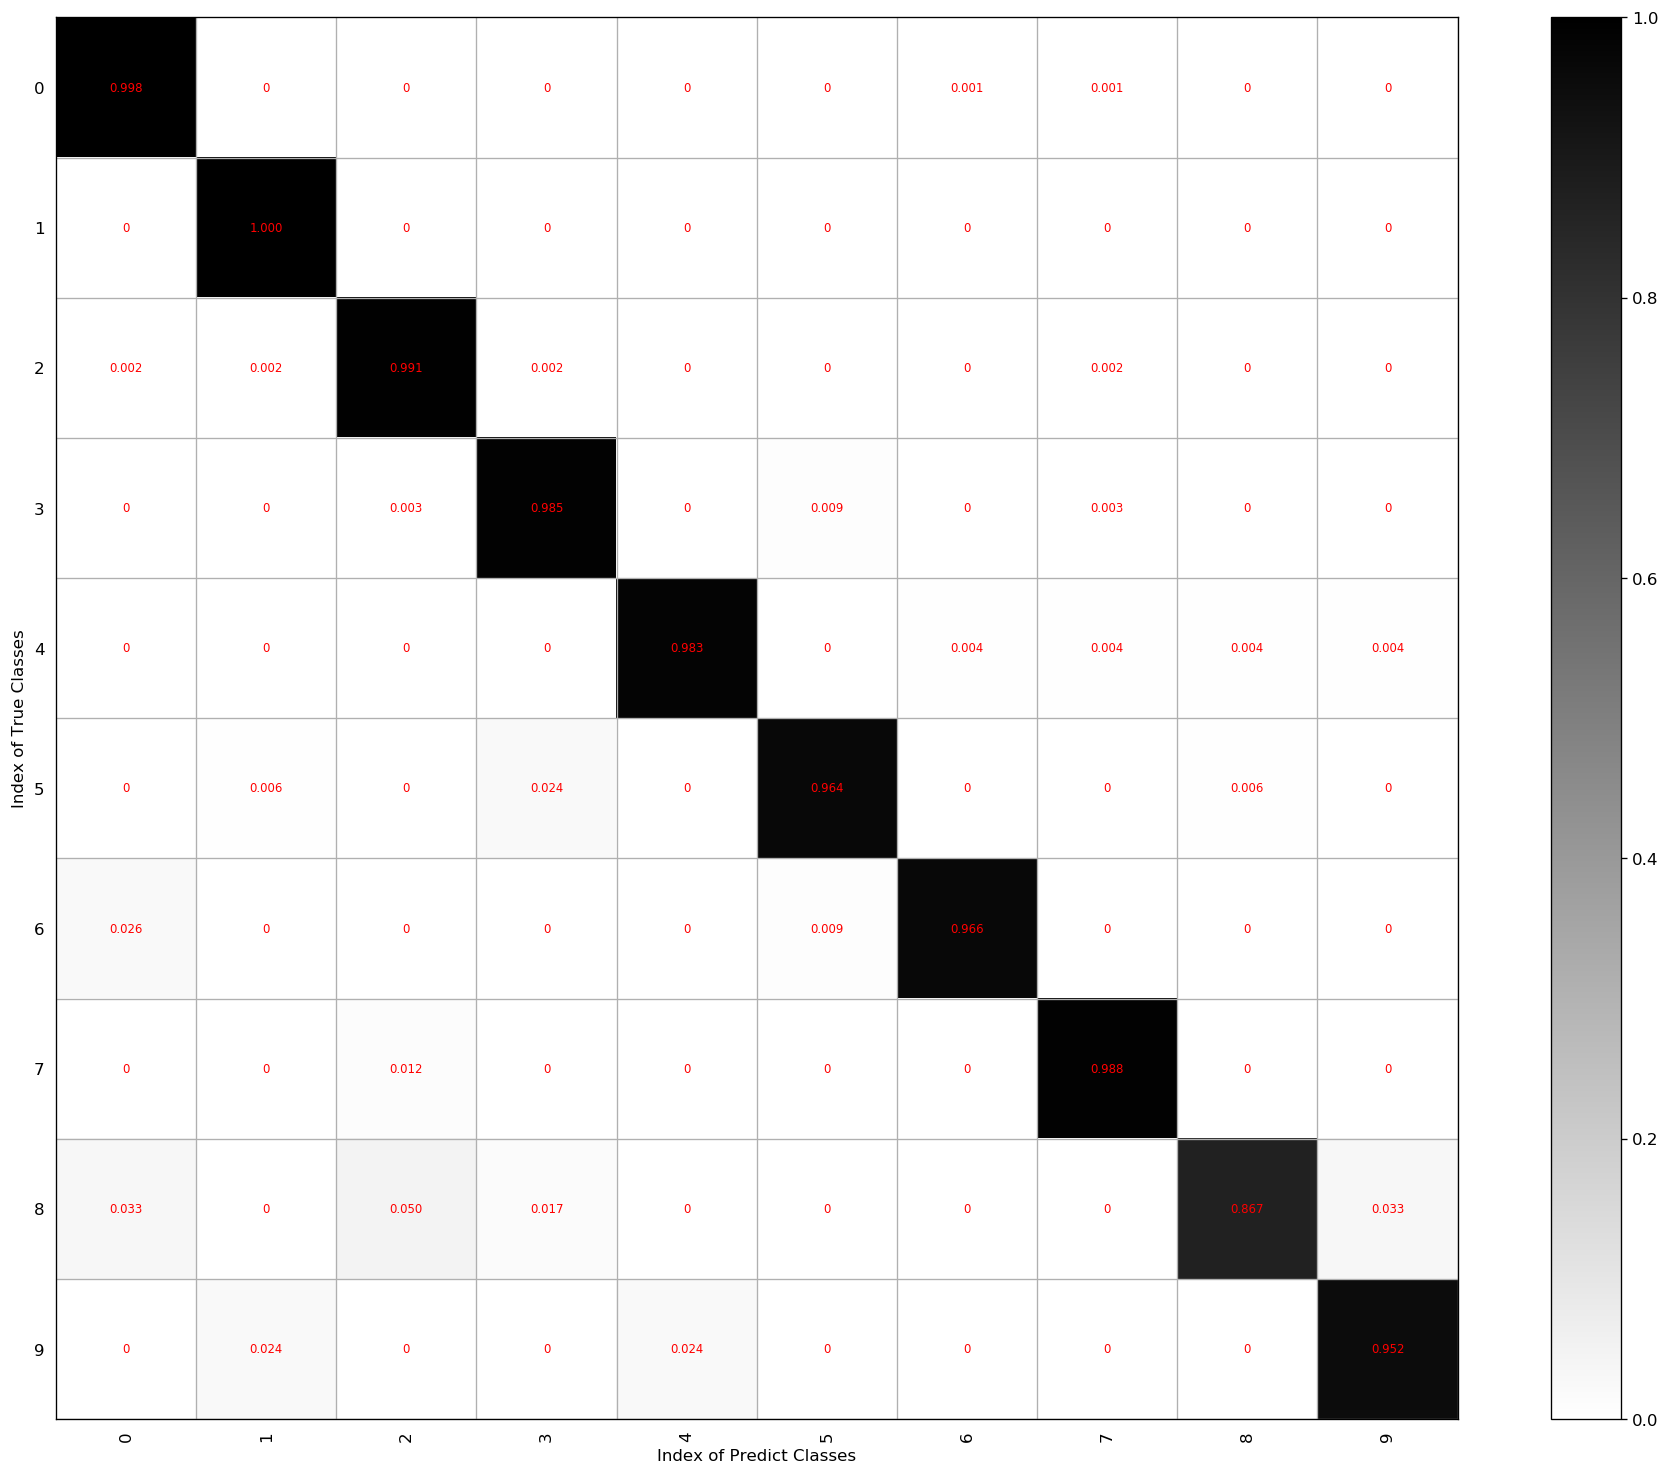

In [43]:
global_max_weight = np.max(distrs_used_for_training)
mnist_ds.backup()
for k, distr in enumerate(distrs_used_for_training):
    print('\n\nk = {}: Imposed distribution: {}'.format(k, np.round(np.array(distr), decimals=3)))
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
    mnist_ds.impose_distribution(np.array(distr), global_max_weight)
    lenet5_model = Lenet5(mnist_ds, "with_imposed_distr_{}_".format(k), epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1, learning_rate=0.001, drop_out_keep_prob=0.5)
    lenet5_model.train()

#### Use a subset of  MNIST dataset



k = 0: Imposed distribution: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2018-05-07 10:33:59,060 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        
2018-05-07 10:34:01,731 - Training will use num_examples = 9984 from training set size = 10000
2018-05-07 10:34:09,157 - EPOCH 1 --- Training: loss = 2.076, acc = 0.249; Validation: loss = 1.291, acc = 0.698;
2018-05-07 10:34:17,486 - EPOCH 2 --- Training: loss = 1.157, acc = 0.596; Validation: loss = 0.551, acc = 0.840;
2018-05-07 10:34:25,176 - EPOCH 3 --- Training: loss = 0.746, acc = 0.748; Validation: loss = 0.362, acc = 0.899;
2018-05-07 10:34:32,920 - EPOCH 4 --- Training: loss = 0.570, acc = 0.821

2018-05-07 10:42:44,029 - EPOCH 20 --- Training: loss = 0.100, acc = 0.972; Validation: loss = 0.080, acc = 0.979;
2018-05-07 10:42:53,019 - EPOCH 21 --- Training: loss = 0.100, acc = 0.971; Validation: loss = 0.077, acc = 0.981;
2018-05-07 10:43:01,565 - EPOCH 22 --- Training: loss = 0.098, acc = 0.971; Validation: loss = 0.071, acc = 0.981;
2018-05-07 10:43:09,757 - EPOCH 23 --- Training: loss = 0.085, acc = 0.976; Validation: loss = 0.071, acc = 0.978;
2018-05-07 10:43:17,951 - EPOCH 24 --- Training: loss = 0.086, acc = 0.975; Validation: loss = 0.074, acc = 0.980;
2018-05-07 10:43:26,287 - EPOCH 25 --- Training: loss = 0.084, acc = 0.976; Validation: loss = 0.072, acc = 0.982;
2018-05-07 10:43:34,631 - EPOCH 26 --- Training: loss = 0.079, acc = 0.976; Validation: loss = 0.081, acc = 0.979;
2018-05-07 10:43:42,974 - EPOCH 27 --- Training: loss = 0.076, acc = 0.978; Validation: loss = 0.076, acc = 0.980;
2018-05-07 10:43:51,069 - EPOCH 28 --- Training: loss = 0.073, acc = 0.979; Vali

2018-05-07 10:51:13,581 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.022 0.032 0.045 0.063 0.089 0.126 0.179 0.254 0.126 0.063]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.022 0.031 0.044 0.063 0.089 0.126 0.179 0.256 0.126 0.063]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.022 0.031 0.045 0.063 0.089 0.126 0.179 0.255 0.126 0.063]
        
2018-05-07 10:51:14,906 - Training will use num_examples = 9984 from training set size = 10000
2018-05-07 10:51:22,390 - EPOCH 1 --- Training: loss = 1.856, acc = 0.378; Validation: loss = 1.131, acc = 0.648;
2018-05-07 10:51:30,608 - EPOCH 2 --- Training: loss = 0.962, acc = 0.677; Validation: loss = 0.460, acc = 0.875;
2018-05-07 10:51:38,469 - EPOCH 3 --- Training: loss = 0.584, acc = 0.813; Validation: loss = 0.278, acc = 0.926;
2018-05-07 10:51:46,476 - EPOCH 4 --- Training: loss = 0.437, acc = 0.864; Validation:

2018-05-07 10:59:32,950 - EPOCH 20 --- Training: loss = 0.111, acc = 0.969; Validation: loss = 0.068, acc = 0.979;
2018-05-07 10:59:41,024 - EPOCH 21 --- Training: loss = 0.108, acc = 0.968; Validation: loss = 0.069, acc = 0.978;
2018-05-07 10:59:48,975 - EPOCH 22 --- Training: loss = 0.102, acc = 0.971; Validation: loss = 0.067, acc = 0.979;
2018-05-07 10:59:56,903 - EPOCH 23 --- Training: loss = 0.099, acc = 0.971; Validation: loss = 0.069, acc = 0.978;
2018-05-07 11:00:05,129 - EPOCH 24 --- Training: loss = 0.096, acc = 0.972; Validation: loss = 0.060, acc = 0.983;
2018-05-07 11:00:13,095 - EPOCH 25 --- Training: loss = 0.084, acc = 0.975; Validation: loss = 0.057, acc = 0.983;
2018-05-07 11:00:20,951 - EPOCH 26 --- Training: loss = 0.081, acc = 0.978; Validation: loss = 0.068, acc = 0.982;
2018-05-07 11:00:29,081 - EPOCH 27 --- Training: loss = 0.085, acc = 0.976; Validation: loss = 0.057, acc = 0.985;
2018-05-07 11:00:37,042 - EPOCH 28 --- Training: loss = 0.076, acc = 0.978; Vali

2018-05-07 11:08:19,114 - 
        training data set: images = (10000, 28, 28, 1), labels = (10000, 10), distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.298]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.297]
        
2018-05-07 11:08:20,708 - Training will use num_examples = 9984 from training set size = 10000
2018-05-07 11:08:29,186 - EPOCH 1 --- Training: loss = 1.942, acc = 0.310; Validation: loss = 1.389, acc = 0.689;
2018-05-07 11:08:38,215 - EPOCH 2 --- Training: loss = 1.116, acc = 0.653; Validation: loss = 0.567, acc = 0.815;
2018-05-07 11:08:46,631 - EPOCH 3 --- Training: loss = 0.645, acc = 0.788; Validation: loss = 0.327, acc = 0.907;
2018-05-07 11:08:55,287 - EPOCH 4 --- Training: loss = 0.458, acc = 0.859; Validation:

2018-05-07 11:17:09,671 - EPOCH 20 --- Training: loss = 0.073, acc = 0.979; Validation: loss = 0.063, acc = 0.983;
2018-05-07 11:17:18,198 - EPOCH 21 --- Training: loss = 0.069, acc = 0.980; Validation: loss = 0.066, acc = 0.982;
2018-05-07 11:17:27,047 - EPOCH 22 --- Training: loss = 0.065, acc = 0.979; Validation: loss = 0.074, acc = 0.982;
2018-05-07 11:17:35,817 - EPOCH 23 --- Training: loss = 0.062, acc = 0.982; Validation: loss = 0.068, acc = 0.982;
2018-05-07 11:17:44,436 - EPOCH 24 --- Training: loss = 0.063, acc = 0.983; Validation: loss = 0.062, acc = 0.982;
2018-05-07 11:17:53,165 - EPOCH 25 --- Training: loss = 0.063, acc = 0.981; Validation: loss = 0.062, acc = 0.980;
2018-05-07 11:18:01,746 - EPOCH 26 --- Training: loss = 0.054, acc = 0.984; Validation: loss = 0.061, acc = 0.982;
2018-05-07 11:18:10,356 - EPOCH 27 --- Training: loss = 0.050, acc = 0.985; Validation: loss = 0.063, acc = 0.983;
2018-05-07 11:18:19,030 - EPOCH 28 --- Training: loss = 0.052, acc = 0.983; Vali

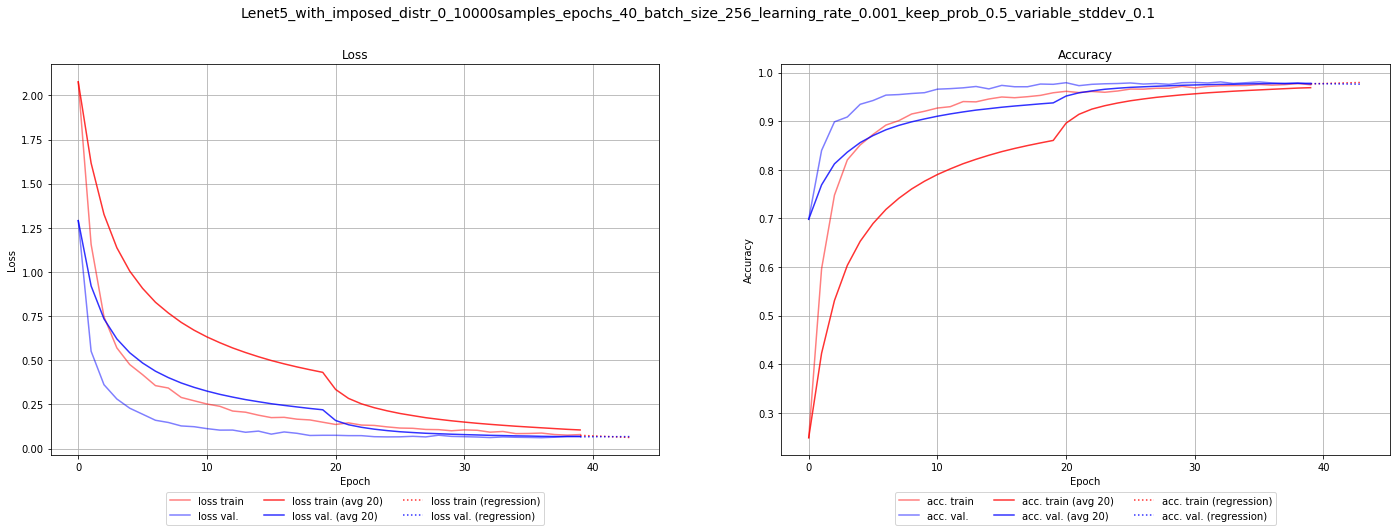

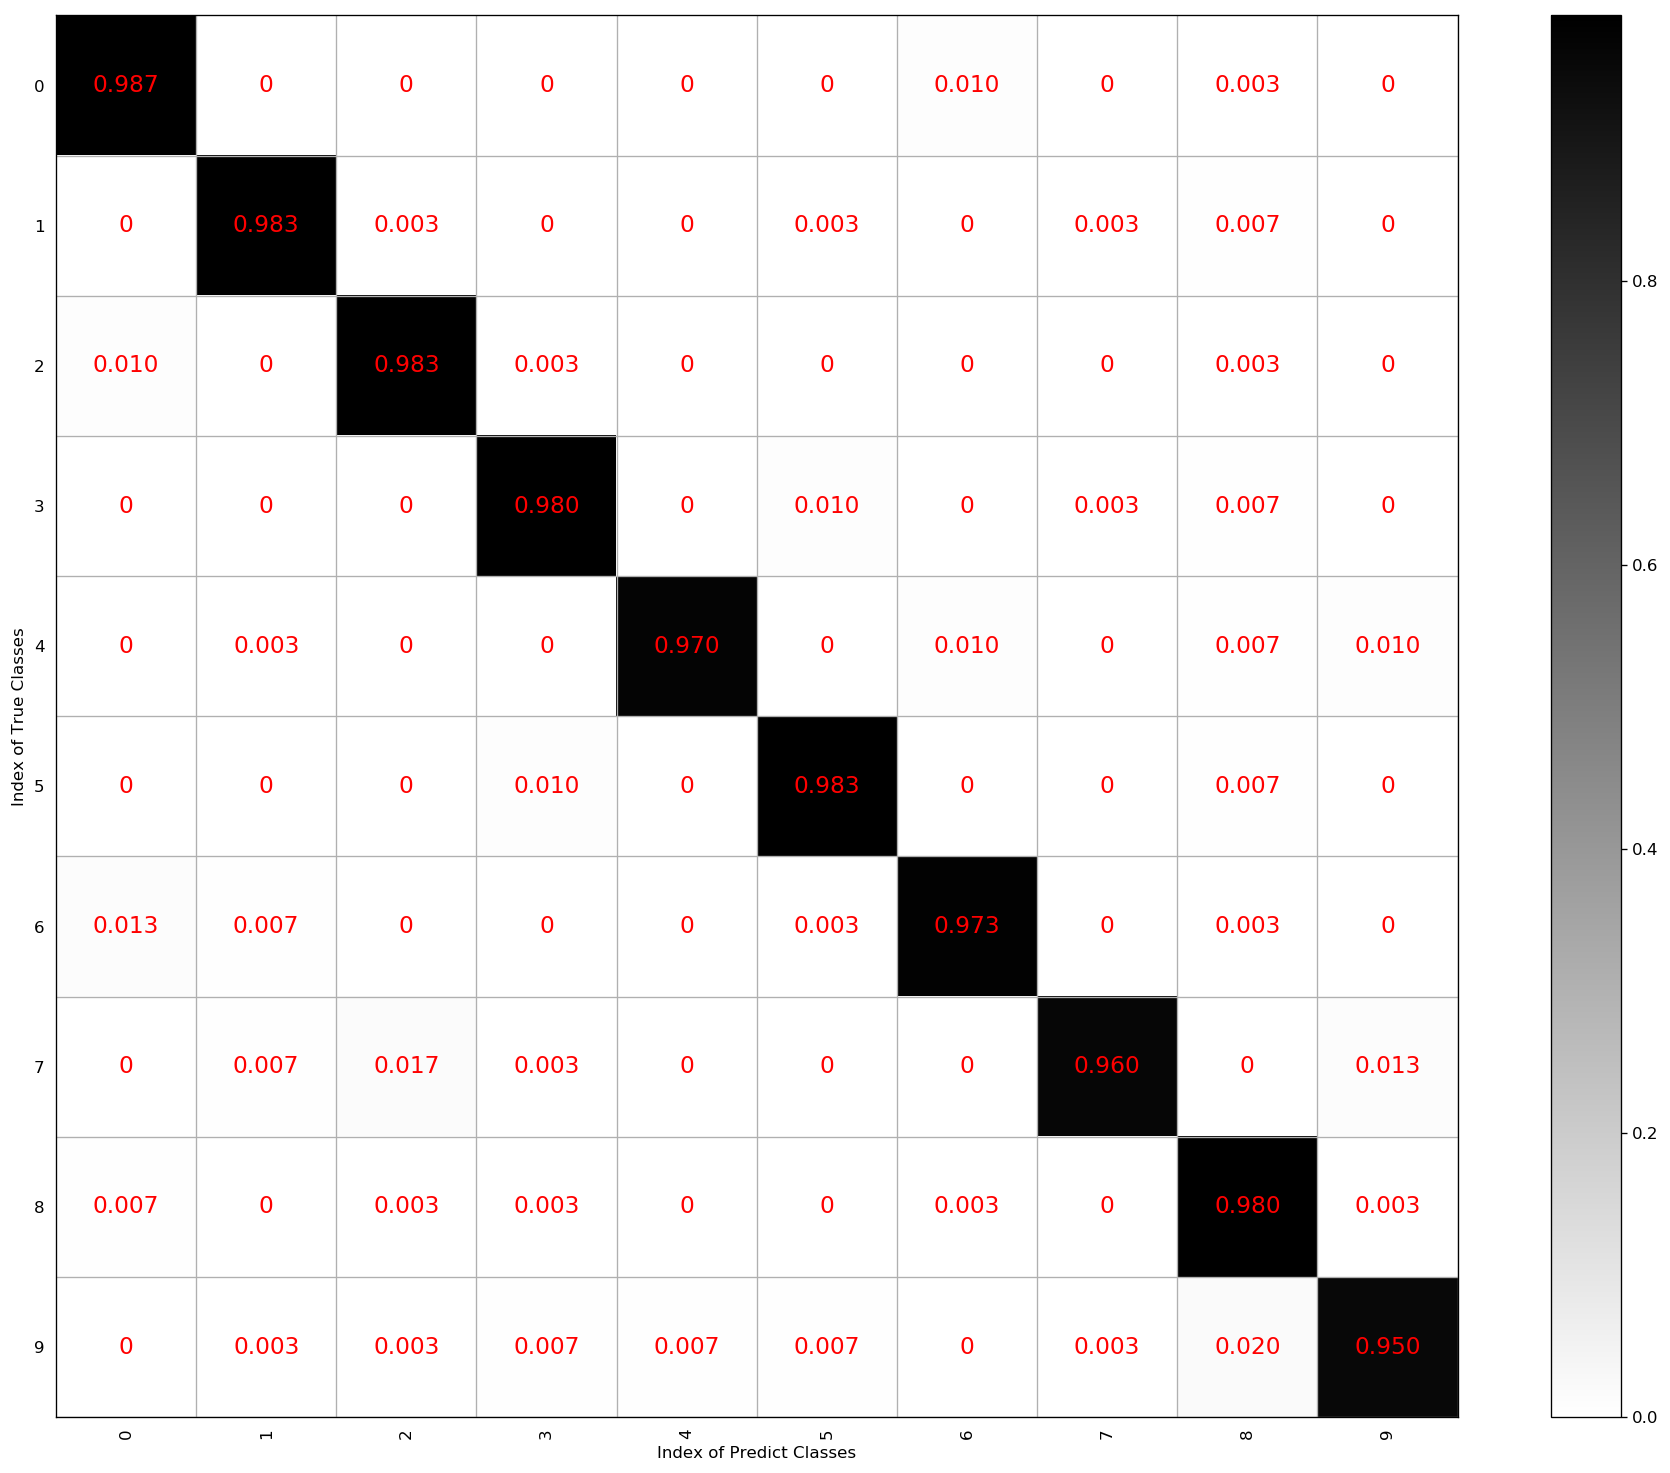

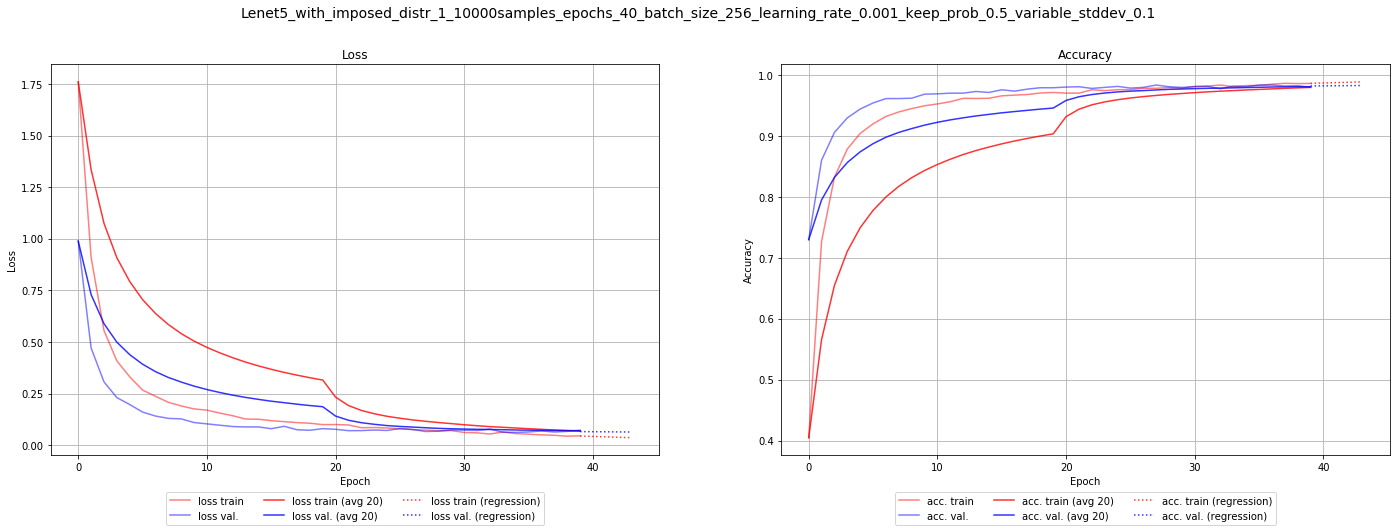

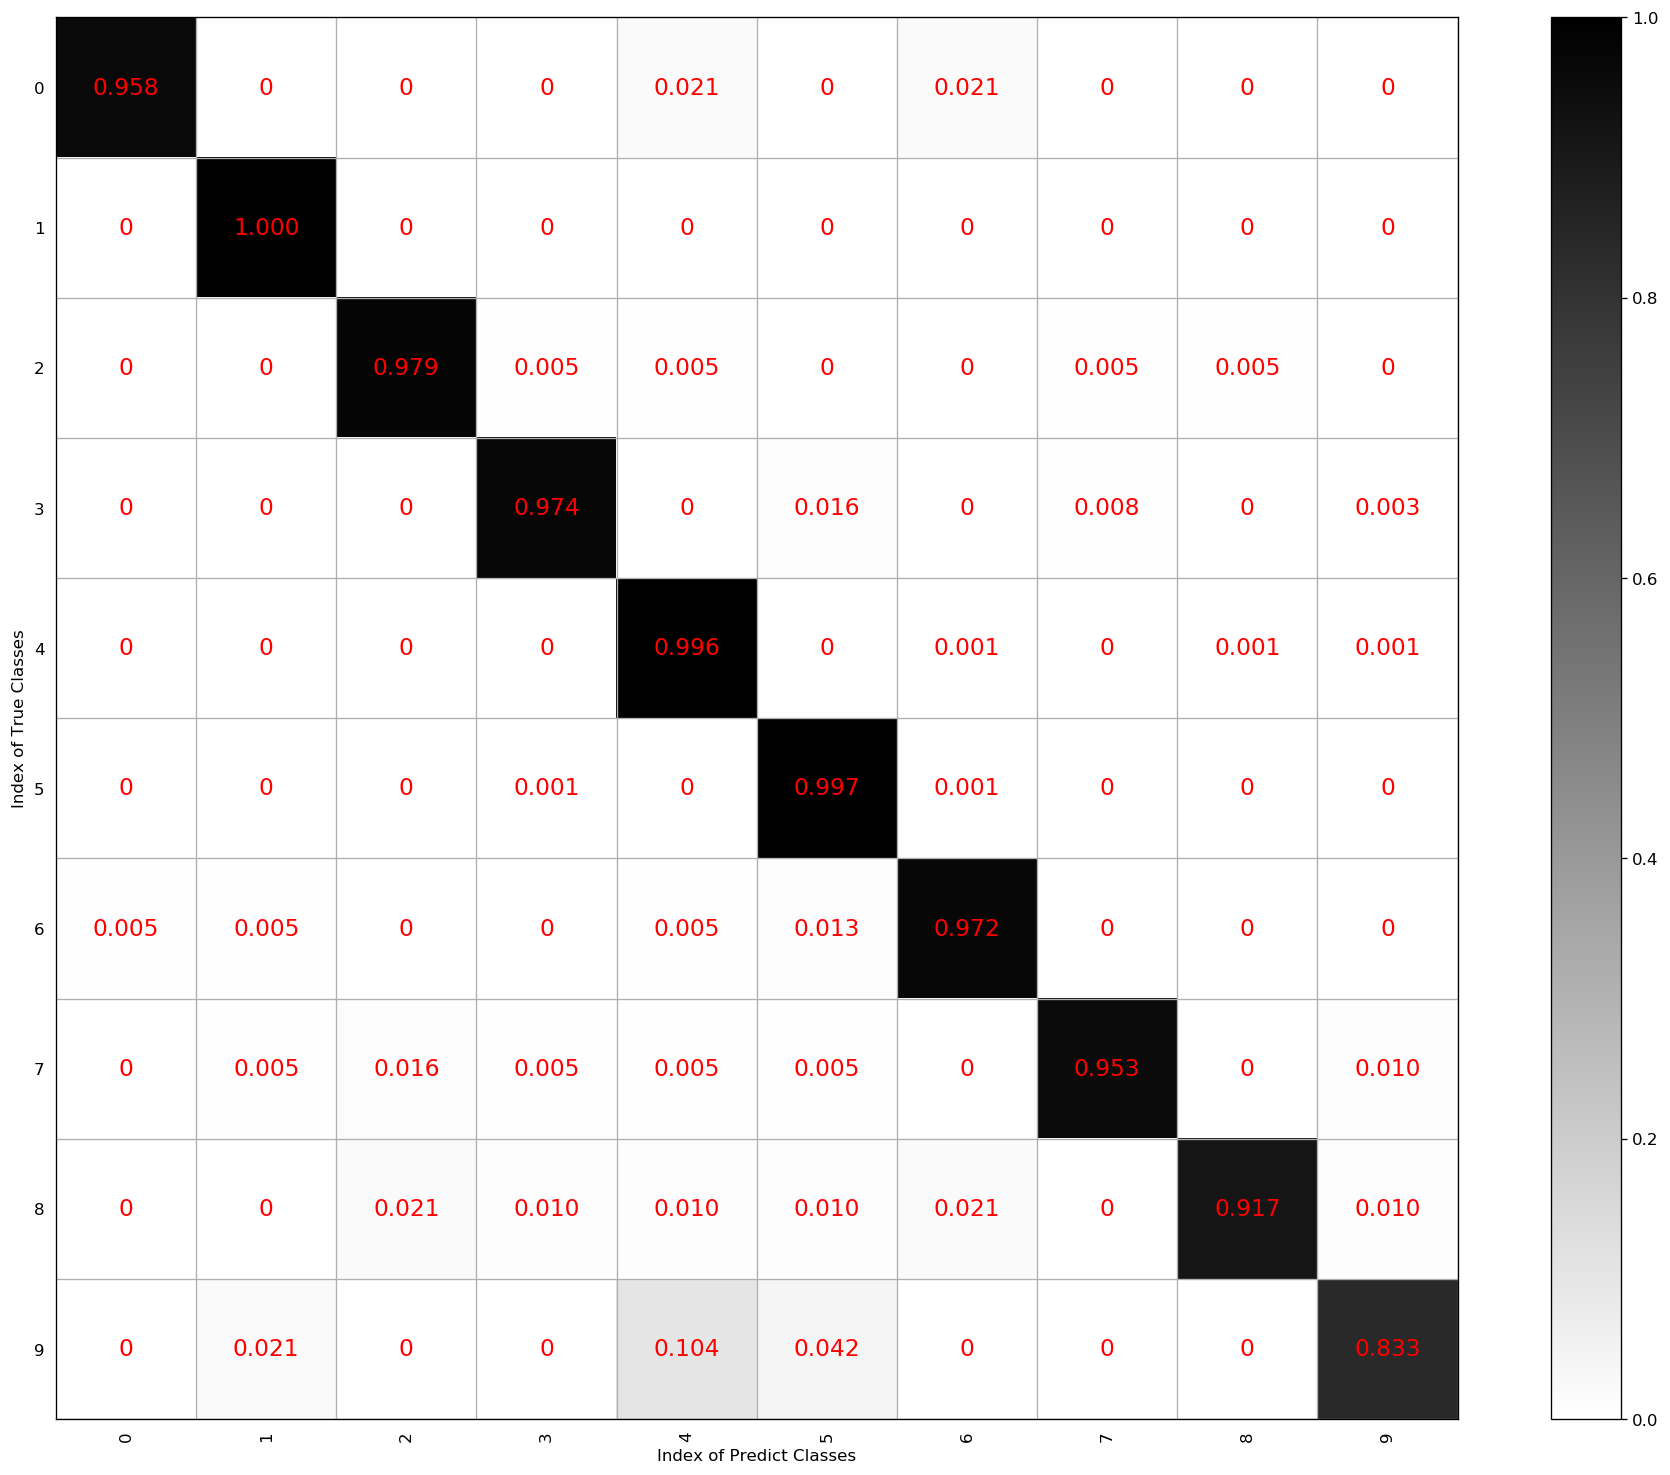

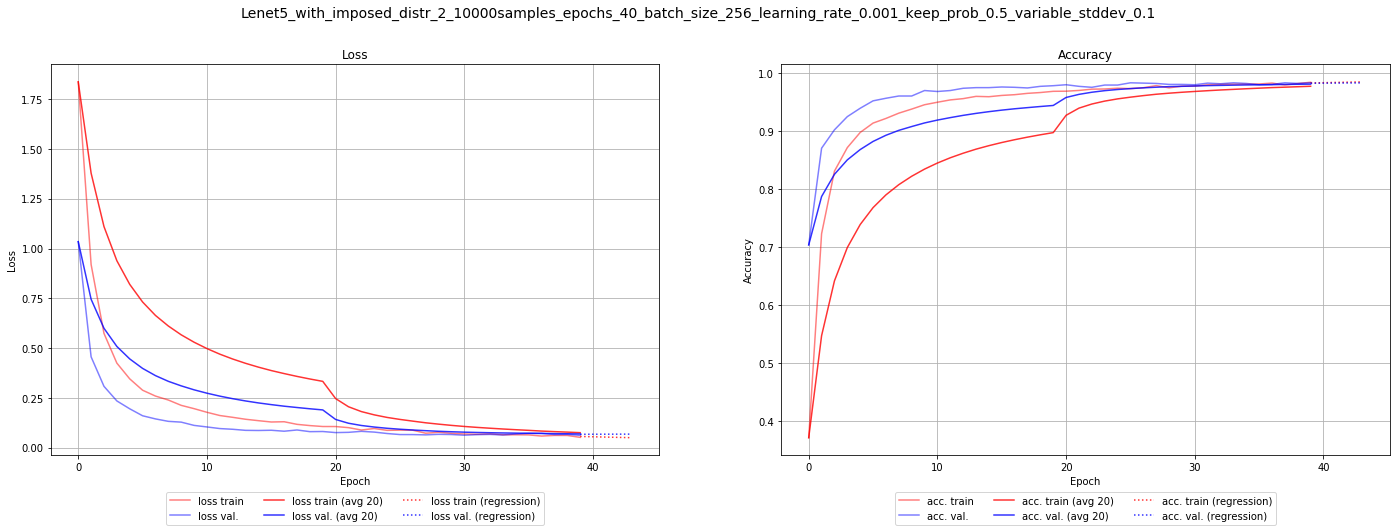

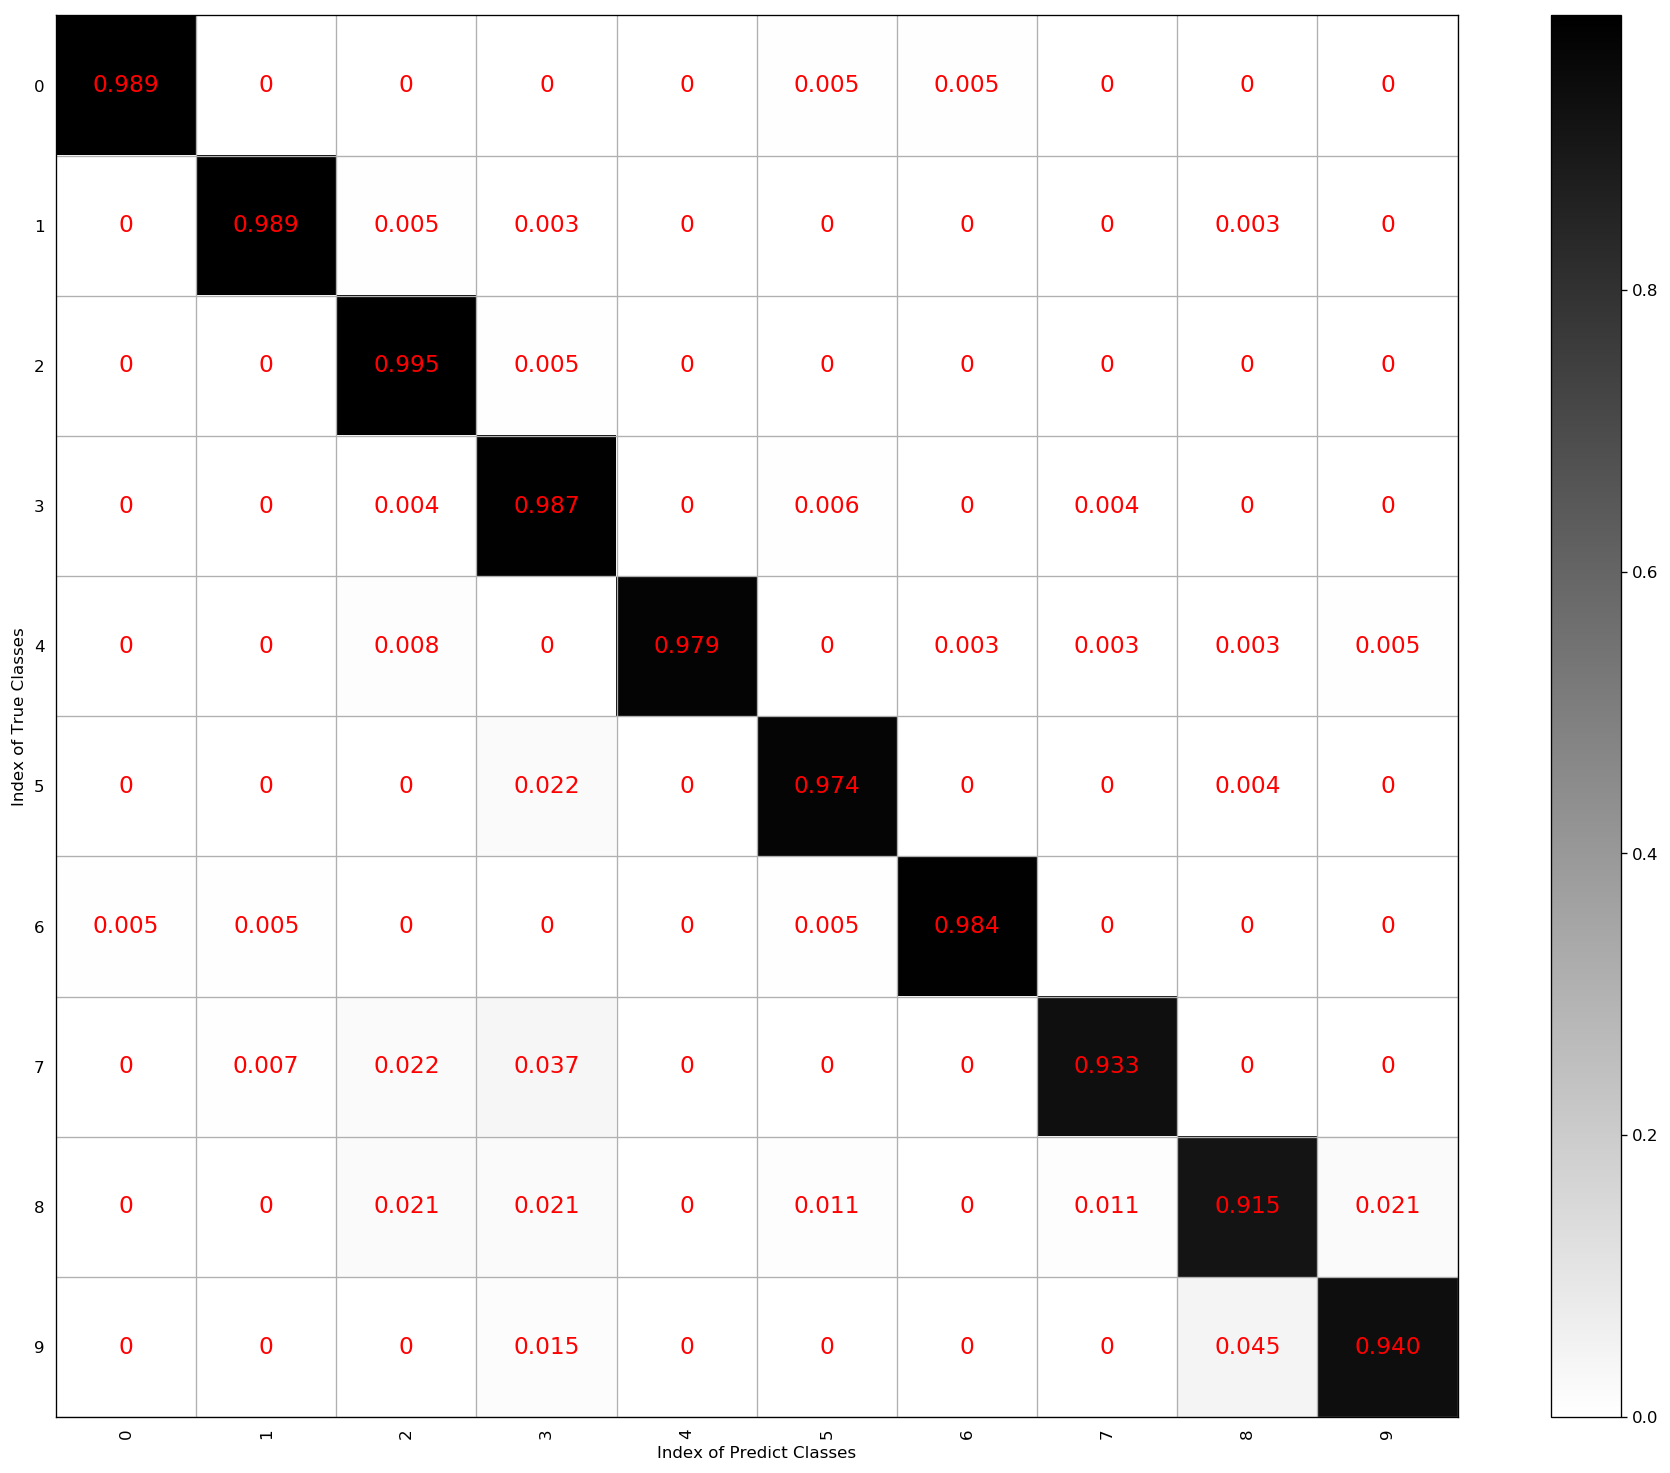

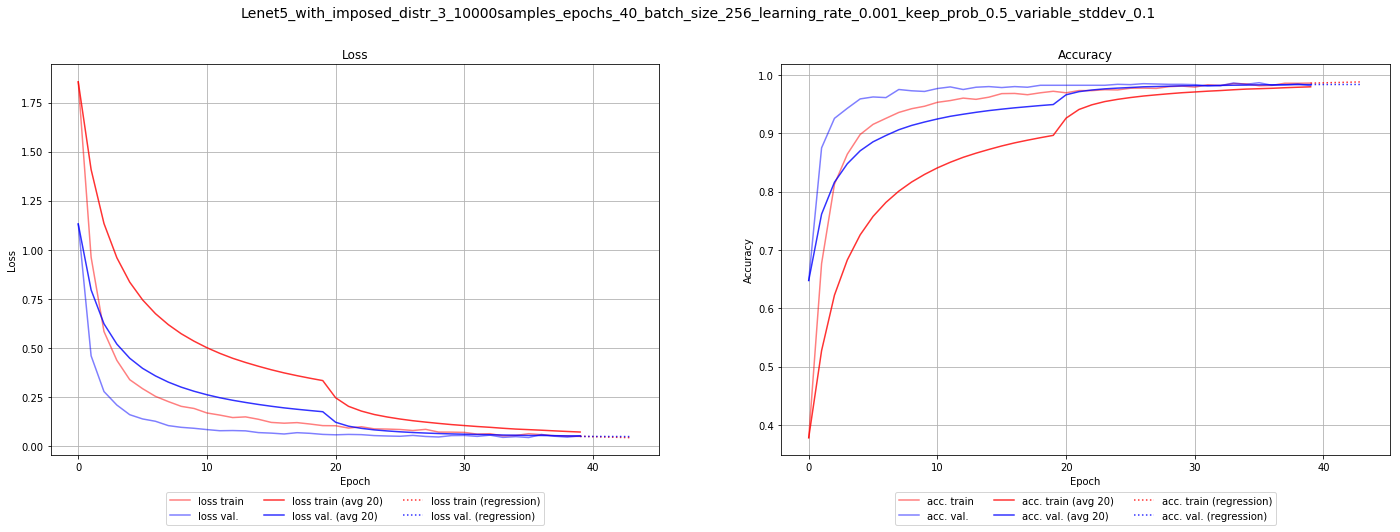

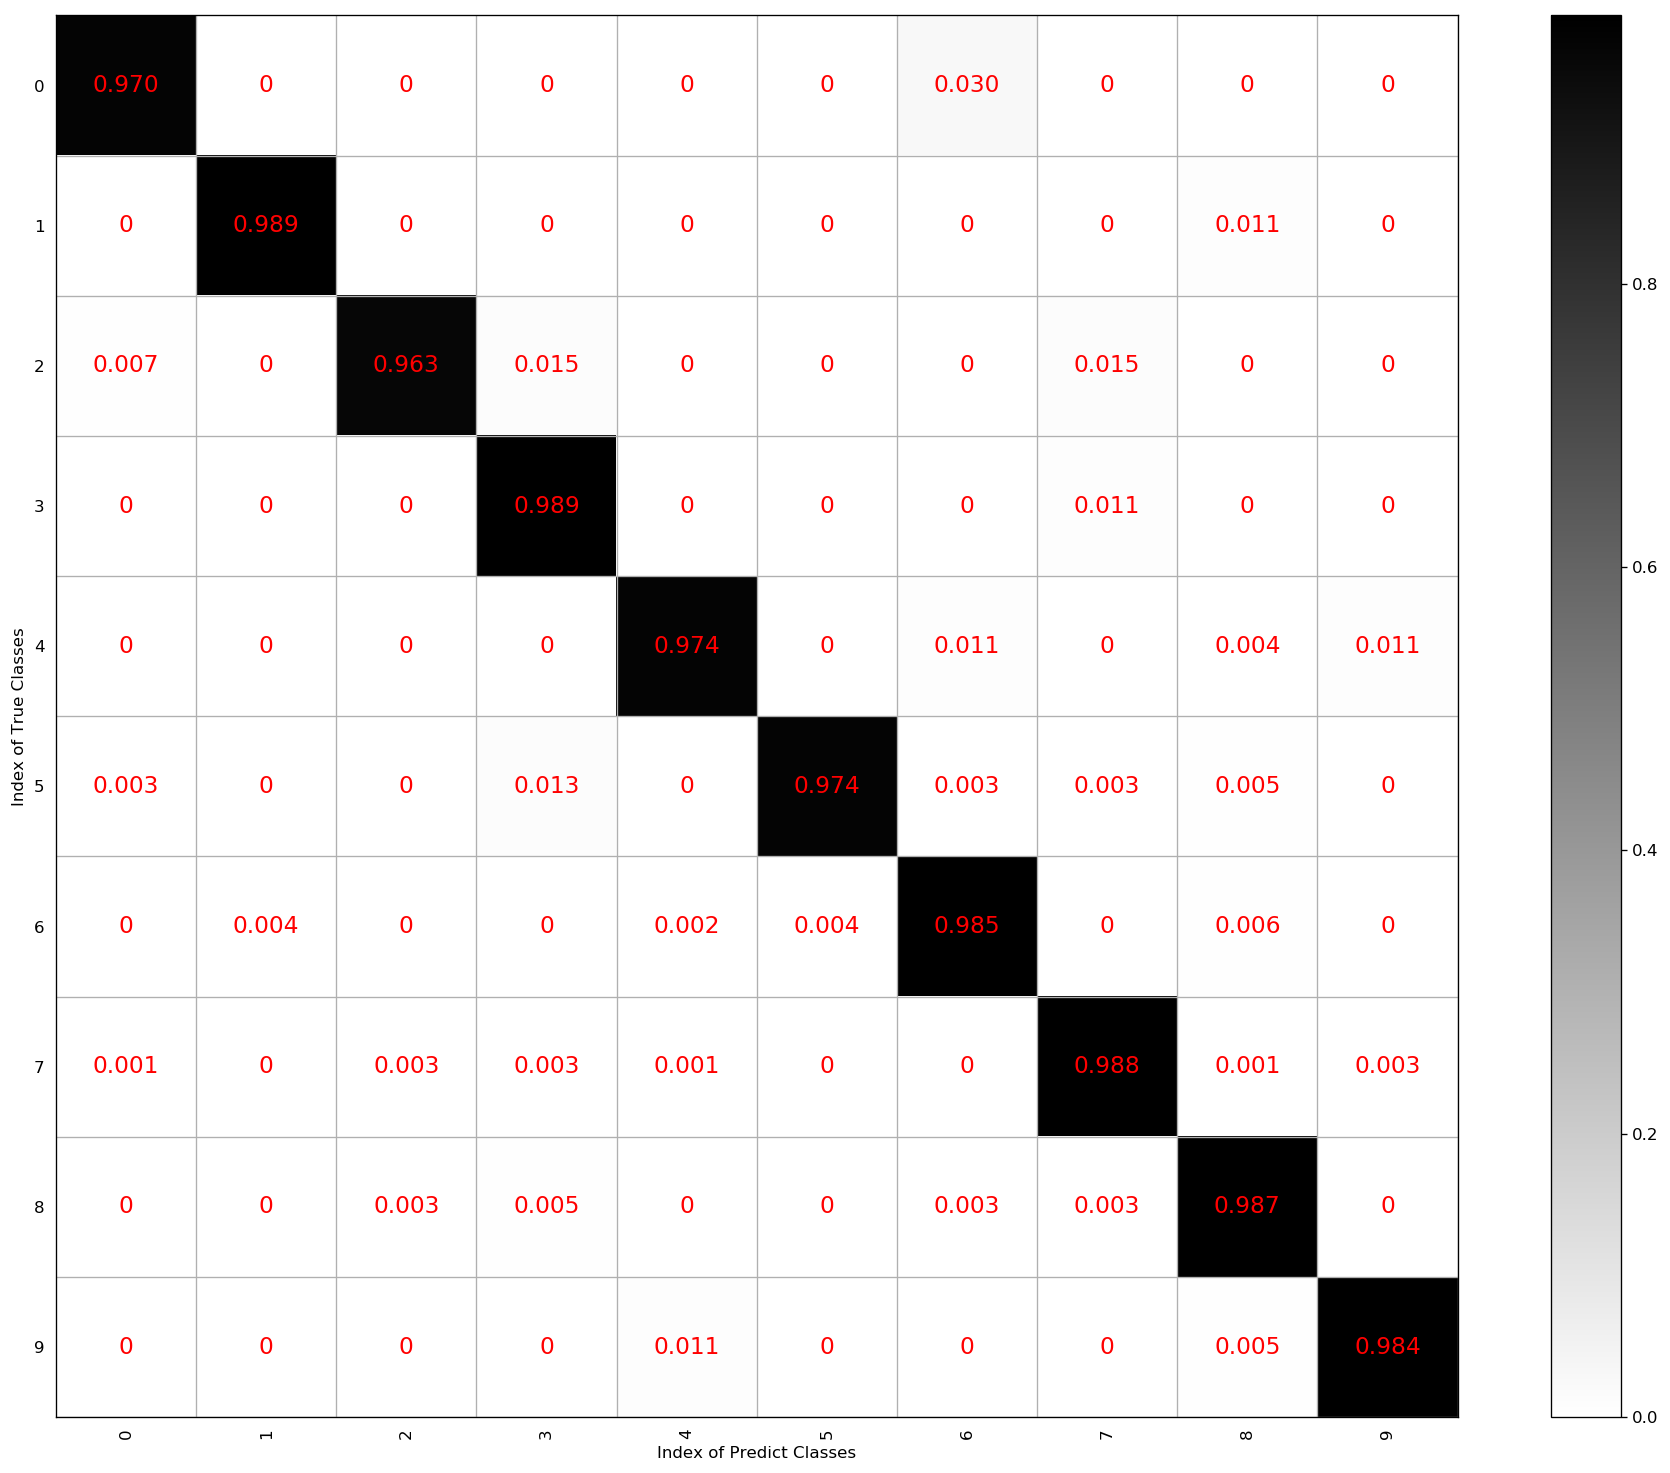

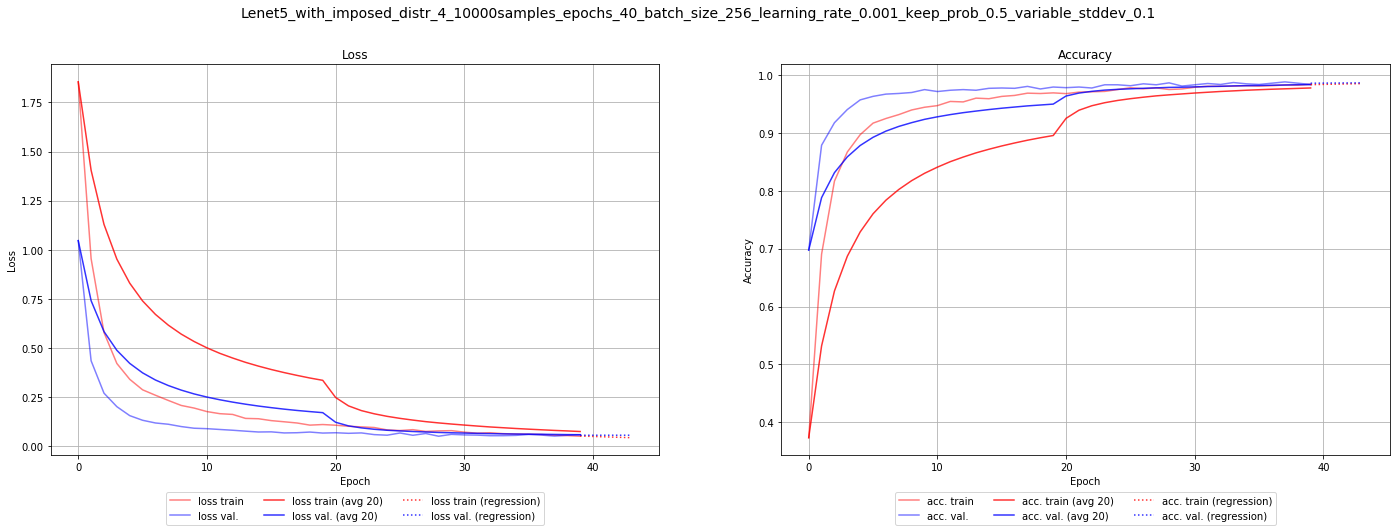

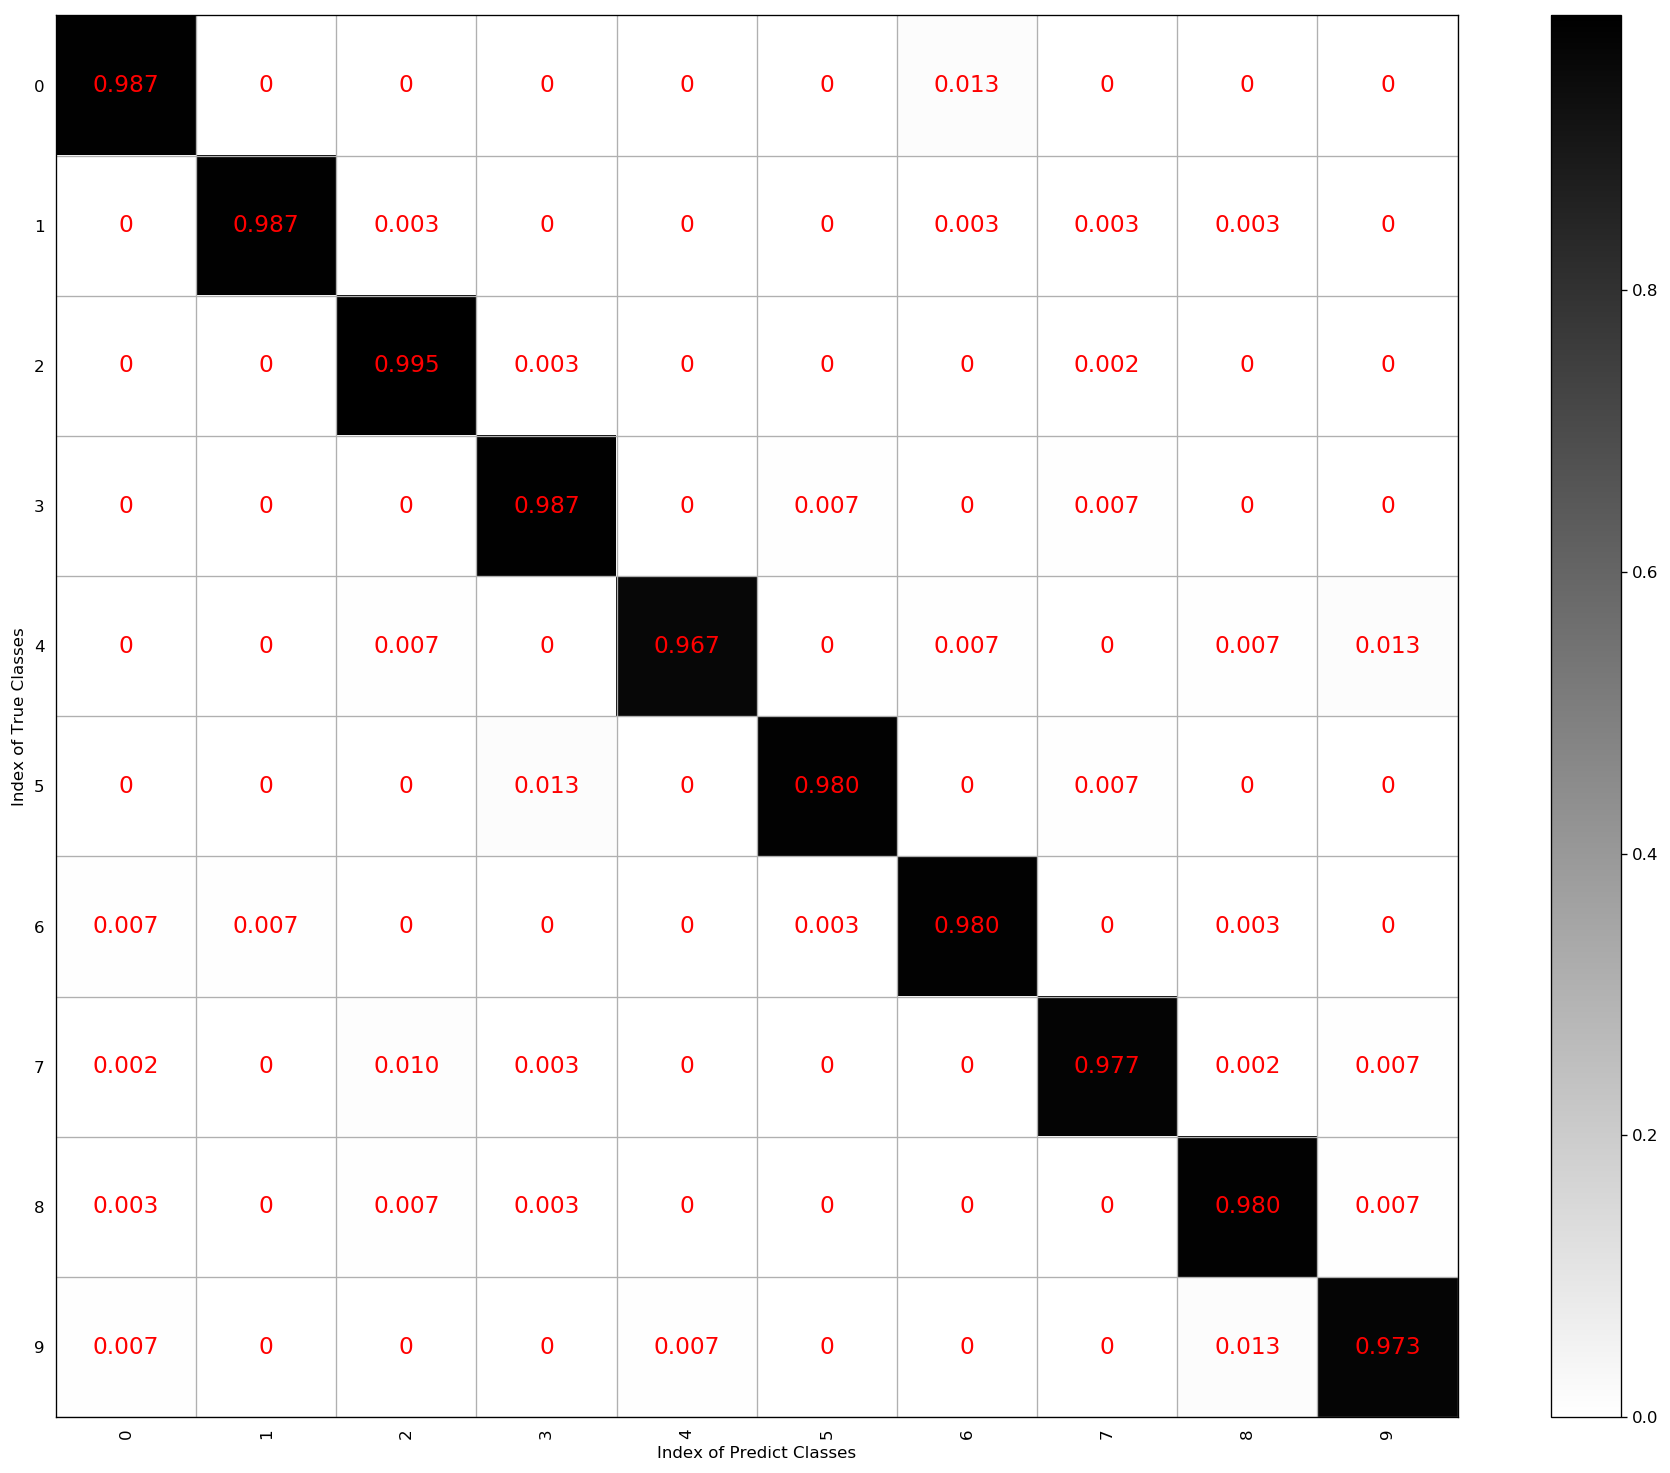

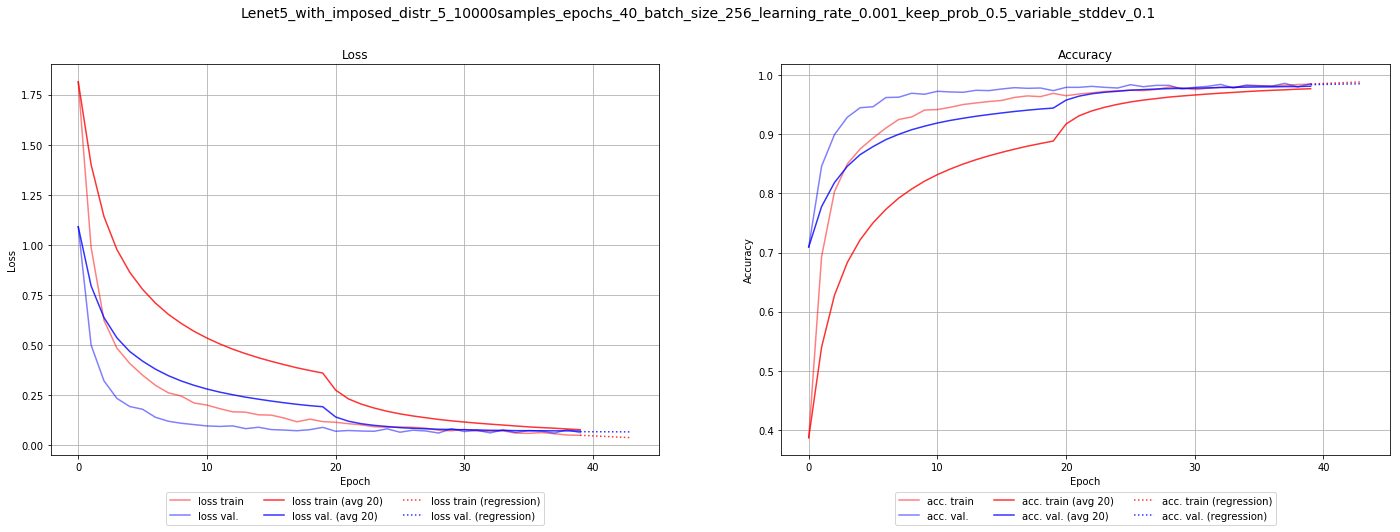

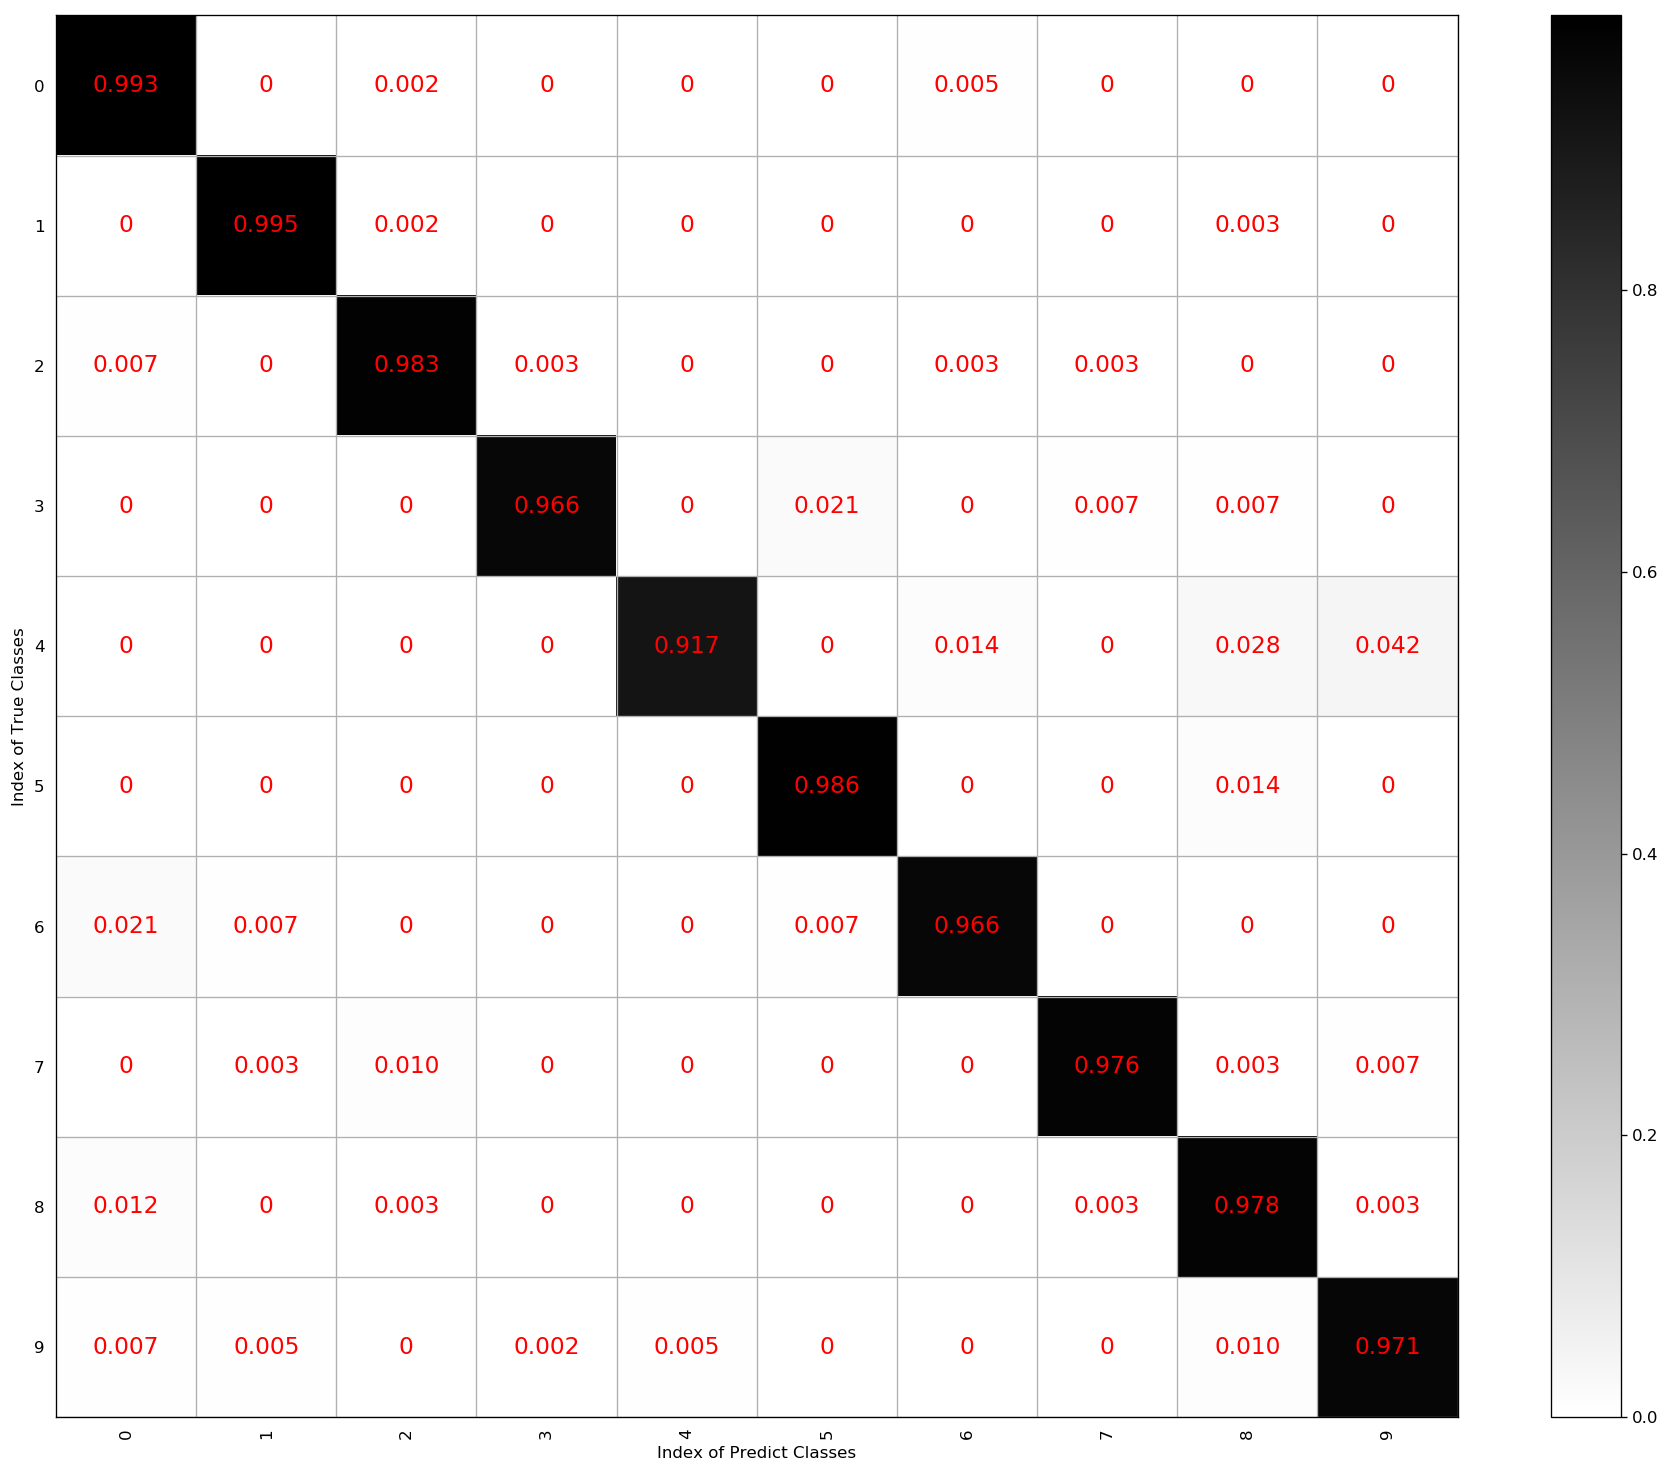

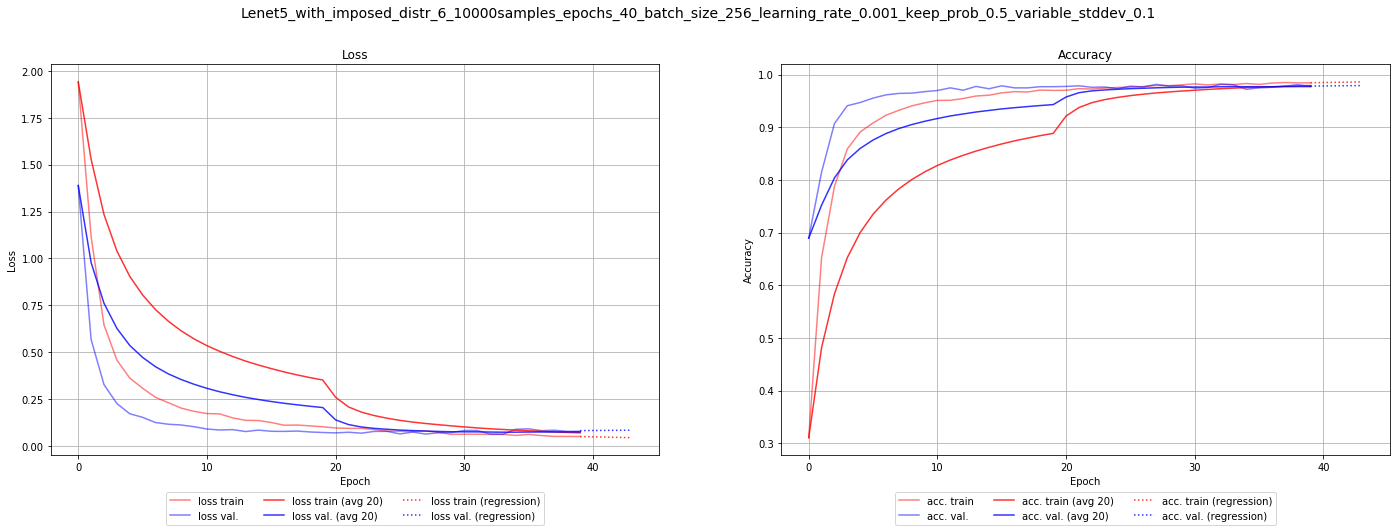

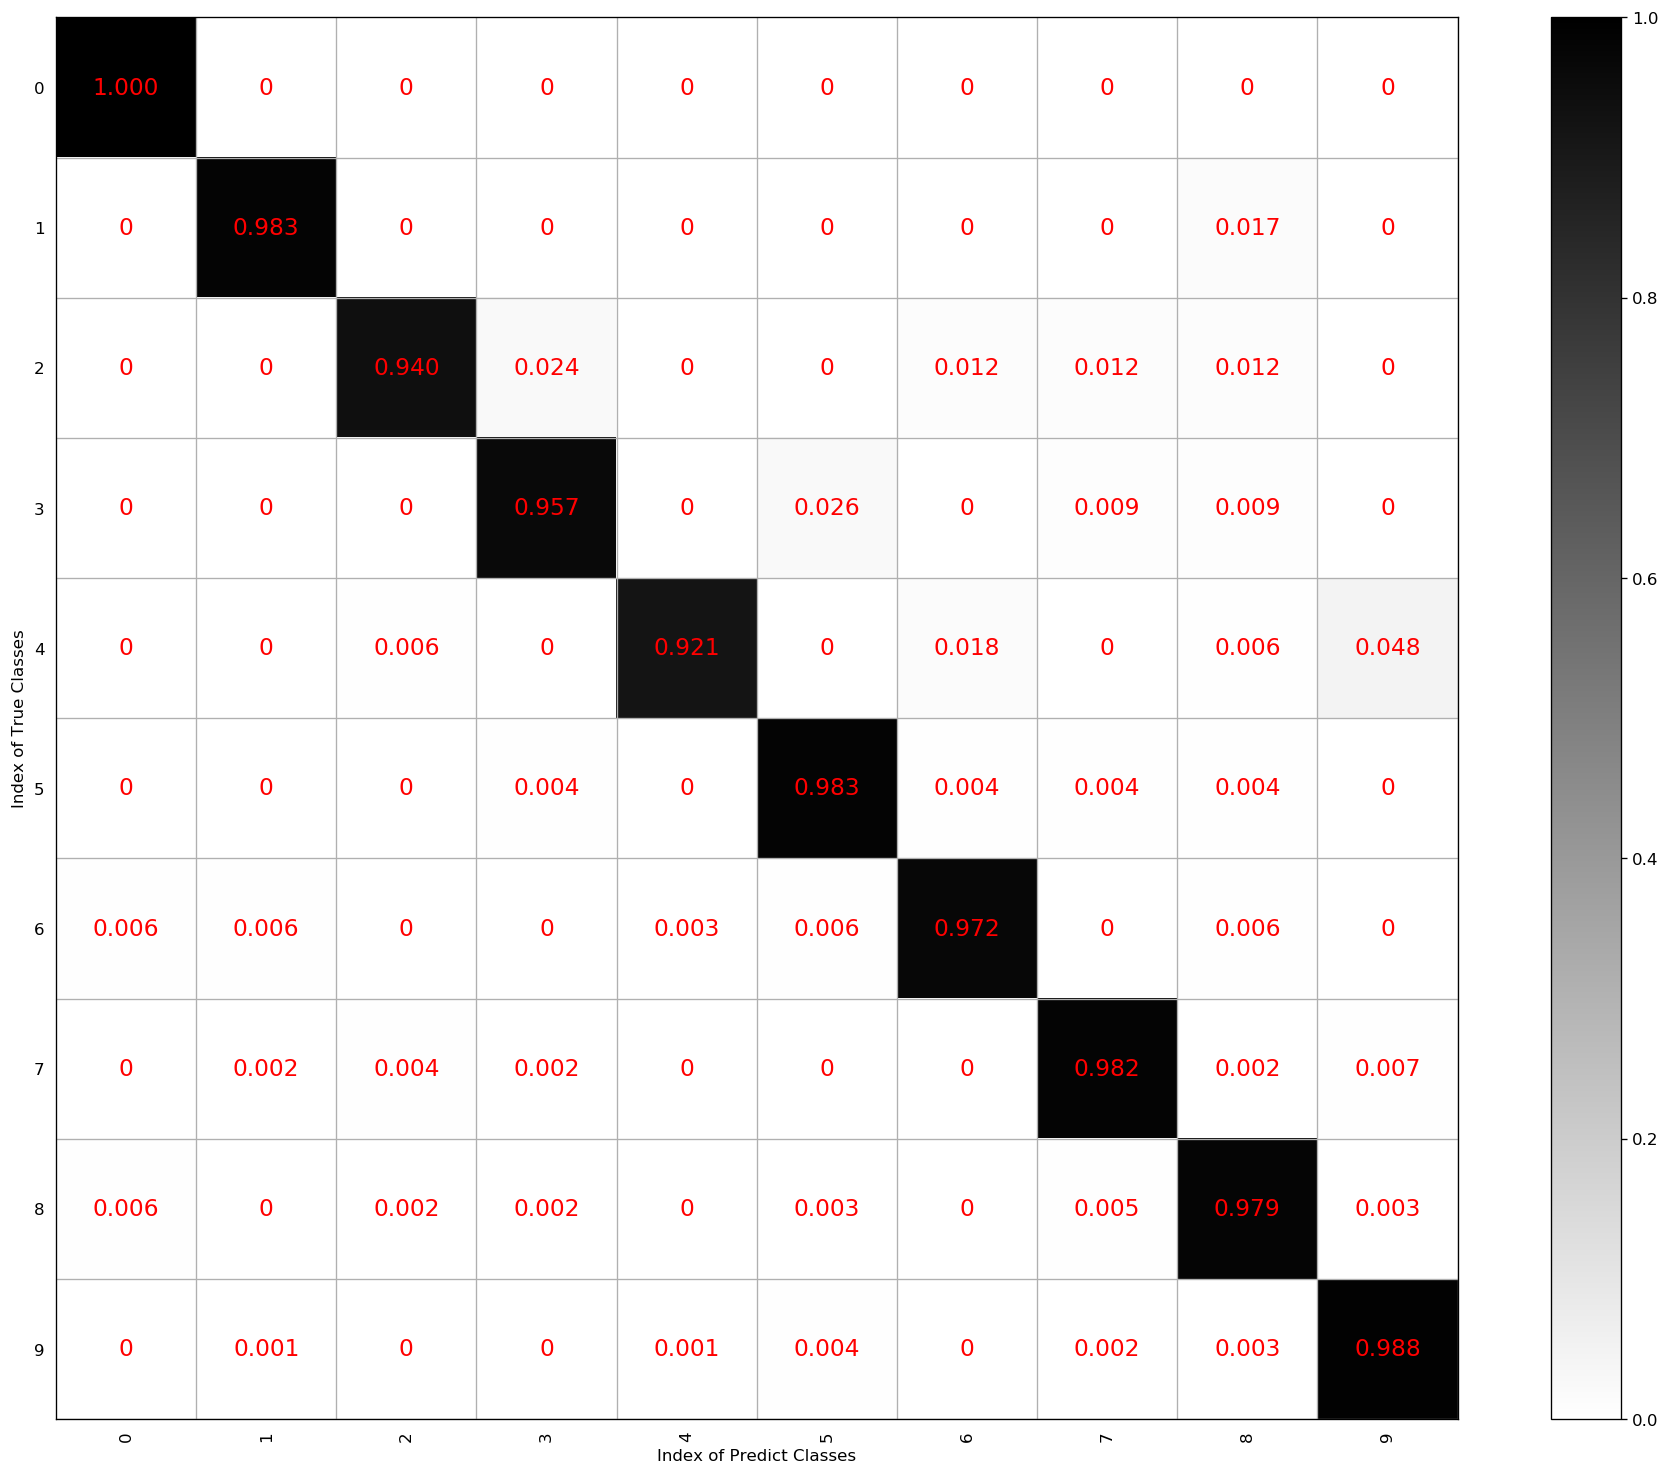

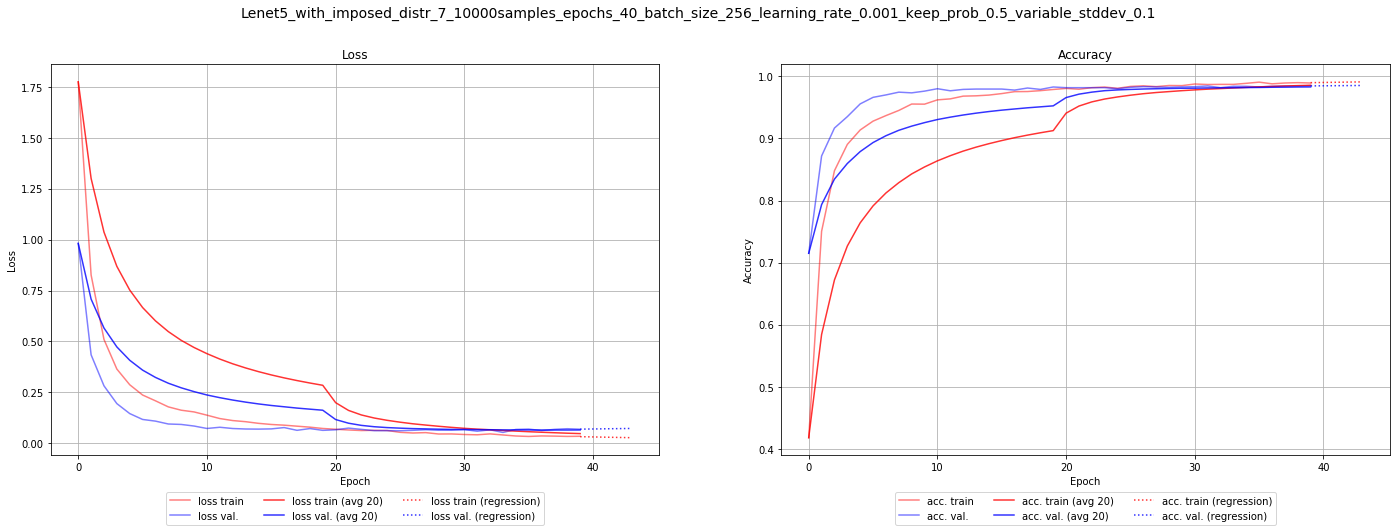

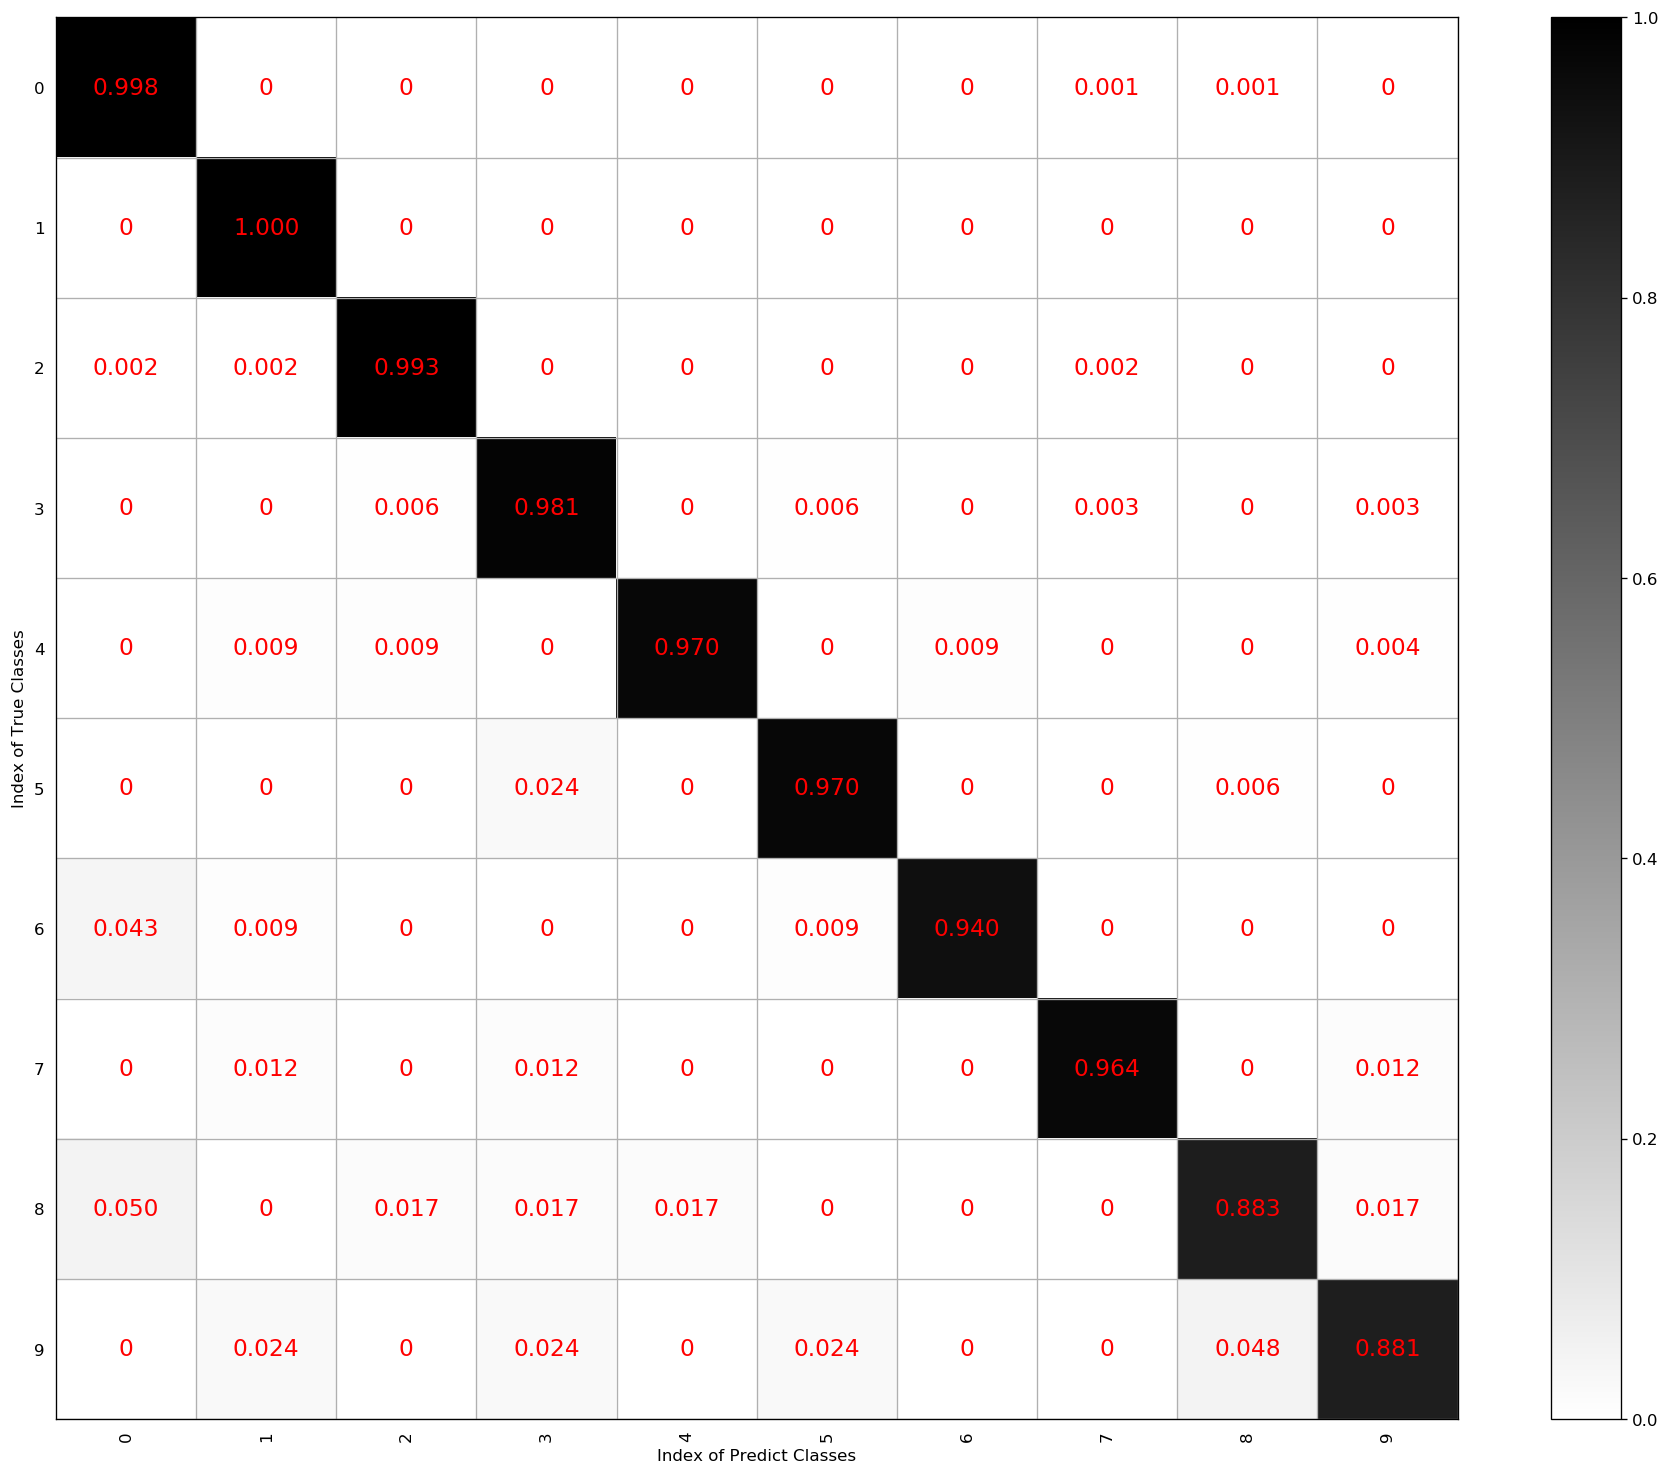

In [13]:
subset_size = 10000
global_max_weight = np.max(distrs_used_for_training)
for k, distr in enumerate(distrs_used_for_training):
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
#     mnist_ds.train.shuffle()
    print('\n\nk = {}: Imposed distribution: {}'.format(k, np.round(np.array(distr), decimals=3)))
    mnist_ds.impose_distribution(np.array(distr), global_max_weight, max_training_size=subset_size)
    lenet5_model = Lenet5(mnist_ds, "with_imposed_distr_{}_{}samples".format(k, subset_size), epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1, learning_rate=0.001, drop_out_keep_prob=0.5)
    lenet5_model.train()



k = 0: Imposed distribution: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
2018-05-07 11:45:16,804 - 
        training data set: images = (5000, 28, 28, 1), labels = (5000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
        
2018-05-07 11:45:18,352 - Training will use num_examples = 4864 from training set size = 5000
2018-05-07 11:45:22,310 - EPOCH 1 --- Training: loss = 2.227, acc = 0.202; Validation: loss = 1.998, acc = 0.516;
2018-05-07 11:45:27,050 - EPOCH 2 --- Training: loss = 1.770, acc = 0.410; Validation: loss = 1.104, acc = 0.741;
2018-05-07 11:45:31,466 - EPOCH 3 --- Training: loss = 1.177, acc = 0.595; Validation: loss = 0.611, acc = 0.838;
2018-05-07 11:45:35,904 - EPOCH 4 --- Training: loss = 0.846, acc = 0.716; V

2018-05-07 11:50:35,239 - EPOCH 20 --- Training: loss = 0.143, acc = 0.955; Validation: loss = 0.107, acc = 0.974;
2018-05-07 11:50:40,587 - EPOCH 21 --- Training: loss = 0.135, acc = 0.959; Validation: loss = 0.103, acc = 0.973;
2018-05-07 11:50:46,642 - EPOCH 22 --- Training: loss = 0.138, acc = 0.961; Validation: loss = 0.101, acc = 0.972;
2018-05-07 11:50:51,331 - EPOCH 23 --- Training: loss = 0.124, acc = 0.963; Validation: loss = 0.096, acc = 0.973;
2018-05-07 11:50:56,274 - EPOCH 24 --- Training: loss = 0.117, acc = 0.965; Validation: loss = 0.103, acc = 0.974;
2018-05-07 11:51:01,226 - EPOCH 25 --- Training: loss = 0.113, acc = 0.966; Validation: loss = 0.094, acc = 0.974;
2018-05-07 11:51:06,027 - EPOCH 26 --- Training: loss = 0.111, acc = 0.969; Validation: loss = 0.092, acc = 0.974;
2018-05-07 11:51:10,524 - EPOCH 27 --- Training: loss = 0.120, acc = 0.964; Validation: loss = 0.089, acc = 0.973;
2018-05-07 11:51:15,063 - EPOCH 28 --- Training: loss = 0.110, acc = 0.969; Vali

2018-05-07 11:55:19,893 - 
        training data set: images = (5000, 28, 28, 1), labels = (5000, 10), distr = [0.022 0.032 0.045 0.063 0.089 0.126 0.179 0.254 0.126 0.063]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.022 0.031 0.044 0.063 0.089 0.126 0.179 0.256 0.126 0.063]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.022 0.031 0.045 0.063 0.089 0.126 0.179 0.255 0.126 0.063]
        
2018-05-07 11:55:21,027 - Training will use num_examples = 4864 from training set size = 5000
2018-05-07 11:55:24,849 - EPOCH 1 --- Training: loss = 2.110, acc = 0.273; Validation: loss = 1.807, acc = 0.413;
2018-05-07 11:55:29,459 - EPOCH 2 --- Training: loss = 1.655, acc = 0.468; Validation: loss = 1.190, acc = 0.636;
2018-05-07 11:55:33,906 - EPOCH 3 --- Training: loss = 1.178, acc = 0.623; Validation: loss = 0.746, acc = 0.766;
2018-05-07 11:55:38,344 - EPOCH 4 --- Training: loss = 0.844, acc = 0.720; Validation: lo

2018-05-07 12:00:02,932 - EPOCH 20 --- Training: loss = 0.240, acc = 0.927; Validation: loss = 0.129, acc = 0.964;
2018-05-07 12:00:07,658 - EPOCH 21 --- Training: loss = 0.216, acc = 0.936; Validation: loss = 0.131, acc = 0.963;
2018-05-07 12:00:12,548 - EPOCH 22 --- Training: loss = 0.213, acc = 0.937; Validation: loss = 0.127, acc = 0.961;
2018-05-07 12:00:19,420 - EPOCH 23 --- Training: loss = 0.199, acc = 0.944; Validation: loss = 0.129, acc = 0.963;
2018-05-07 12:00:24,058 - EPOCH 24 --- Training: loss = 0.184, acc = 0.946; Validation: loss = 0.123, acc = 0.965;
2018-05-07 12:00:28,786 - EPOCH 25 --- Training: loss = 0.181, acc = 0.947; Validation: loss = 0.119, acc = 0.966;
2018-05-07 12:00:34,946 - EPOCH 26 --- Training: loss = 0.170, acc = 0.950; Validation: loss = 0.127, acc = 0.967;
2018-05-07 12:00:40,971 - EPOCH 27 --- Training: loss = 0.170, acc = 0.948; Validation: loss = 0.127, acc = 0.966;
2018-05-07 12:00:47,125 - EPOCH 28 --- Training: loss = 0.151, acc = 0.957; Vali

2018-05-07 12:05:07,731 - 
        training data set: images = (5000, 28, 28, 1), labels = (5000, 10), distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.297]
        validation data set: images = (1800, 28, 28, 1), labels = (1800, 10), distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.298]
        testing data set: images = (3000, 28, 28, 1), labels = (3000, 10), distr = [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.297]
        
2018-05-07 12:05:08,883 - Training will use num_examples = 4864 from training set size = 5000
2018-05-07 12:05:12,906 - EPOCH 1 --- Training: loss = 2.023, acc = 0.302; Validation: loss = 1.676, acc = 0.529;
2018-05-07 12:05:17,674 - EPOCH 2 --- Training: loss = 1.557, acc = 0.481; Validation: loss = 1.070, acc = 0.698;
2018-05-07 12:05:22,657 - EPOCH 3 --- Training: loss = 1.103, acc = 0.649; Validation: loss = 0.730, acc = 0.764;
2018-05-07 12:05:28,026 - EPOCH 4 --- Training: loss = 0.829, acc = 0.732; Validation: lo

2018-05-07 12:10:05,007 - EPOCH 20 --- Training: loss = 0.135, acc = 0.960; Validation: loss = 0.094, acc = 0.973;
2018-05-07 12:10:09,843 - EPOCH 21 --- Training: loss = 0.122, acc = 0.962; Validation: loss = 0.090, acc = 0.974;
2018-05-07 12:10:14,434 - EPOCH 22 --- Training: loss = 0.121, acc = 0.966; Validation: loss = 0.086, acc = 0.974;
2018-05-07 12:10:19,286 - EPOCH 23 --- Training: loss = 0.124, acc = 0.960; Validation: loss = 0.088, acc = 0.974;
2018-05-07 12:10:24,064 - EPOCH 24 --- Training: loss = 0.107, acc = 0.970; Validation: loss = 0.086, acc = 0.976;
2018-05-07 12:10:28,598 - EPOCH 25 --- Training: loss = 0.115, acc = 0.963; Validation: loss = 0.082, acc = 0.976;
2018-05-07 12:10:33,736 - EPOCH 26 --- Training: loss = 0.108, acc = 0.967; Validation: loss = 0.083, acc = 0.976;
2018-05-07 12:10:38,179 - EPOCH 27 --- Training: loss = 0.101, acc = 0.971; Validation: loss = 0.077, acc = 0.981;
2018-05-07 12:10:42,668 - EPOCH 28 --- Training: loss = 0.102, acc = 0.966; Vali

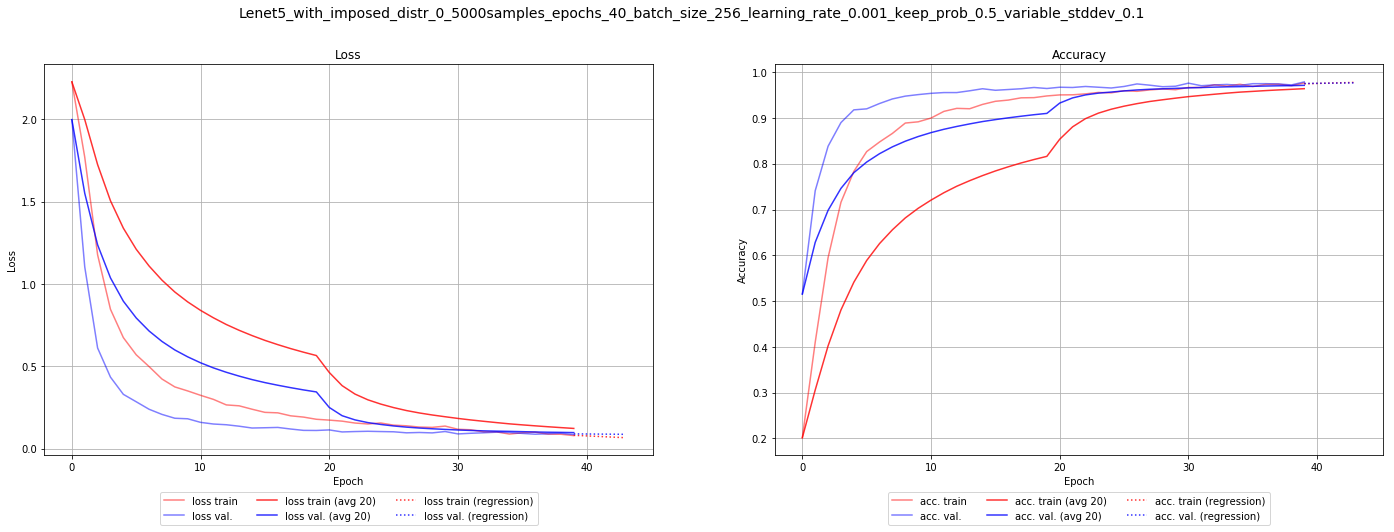

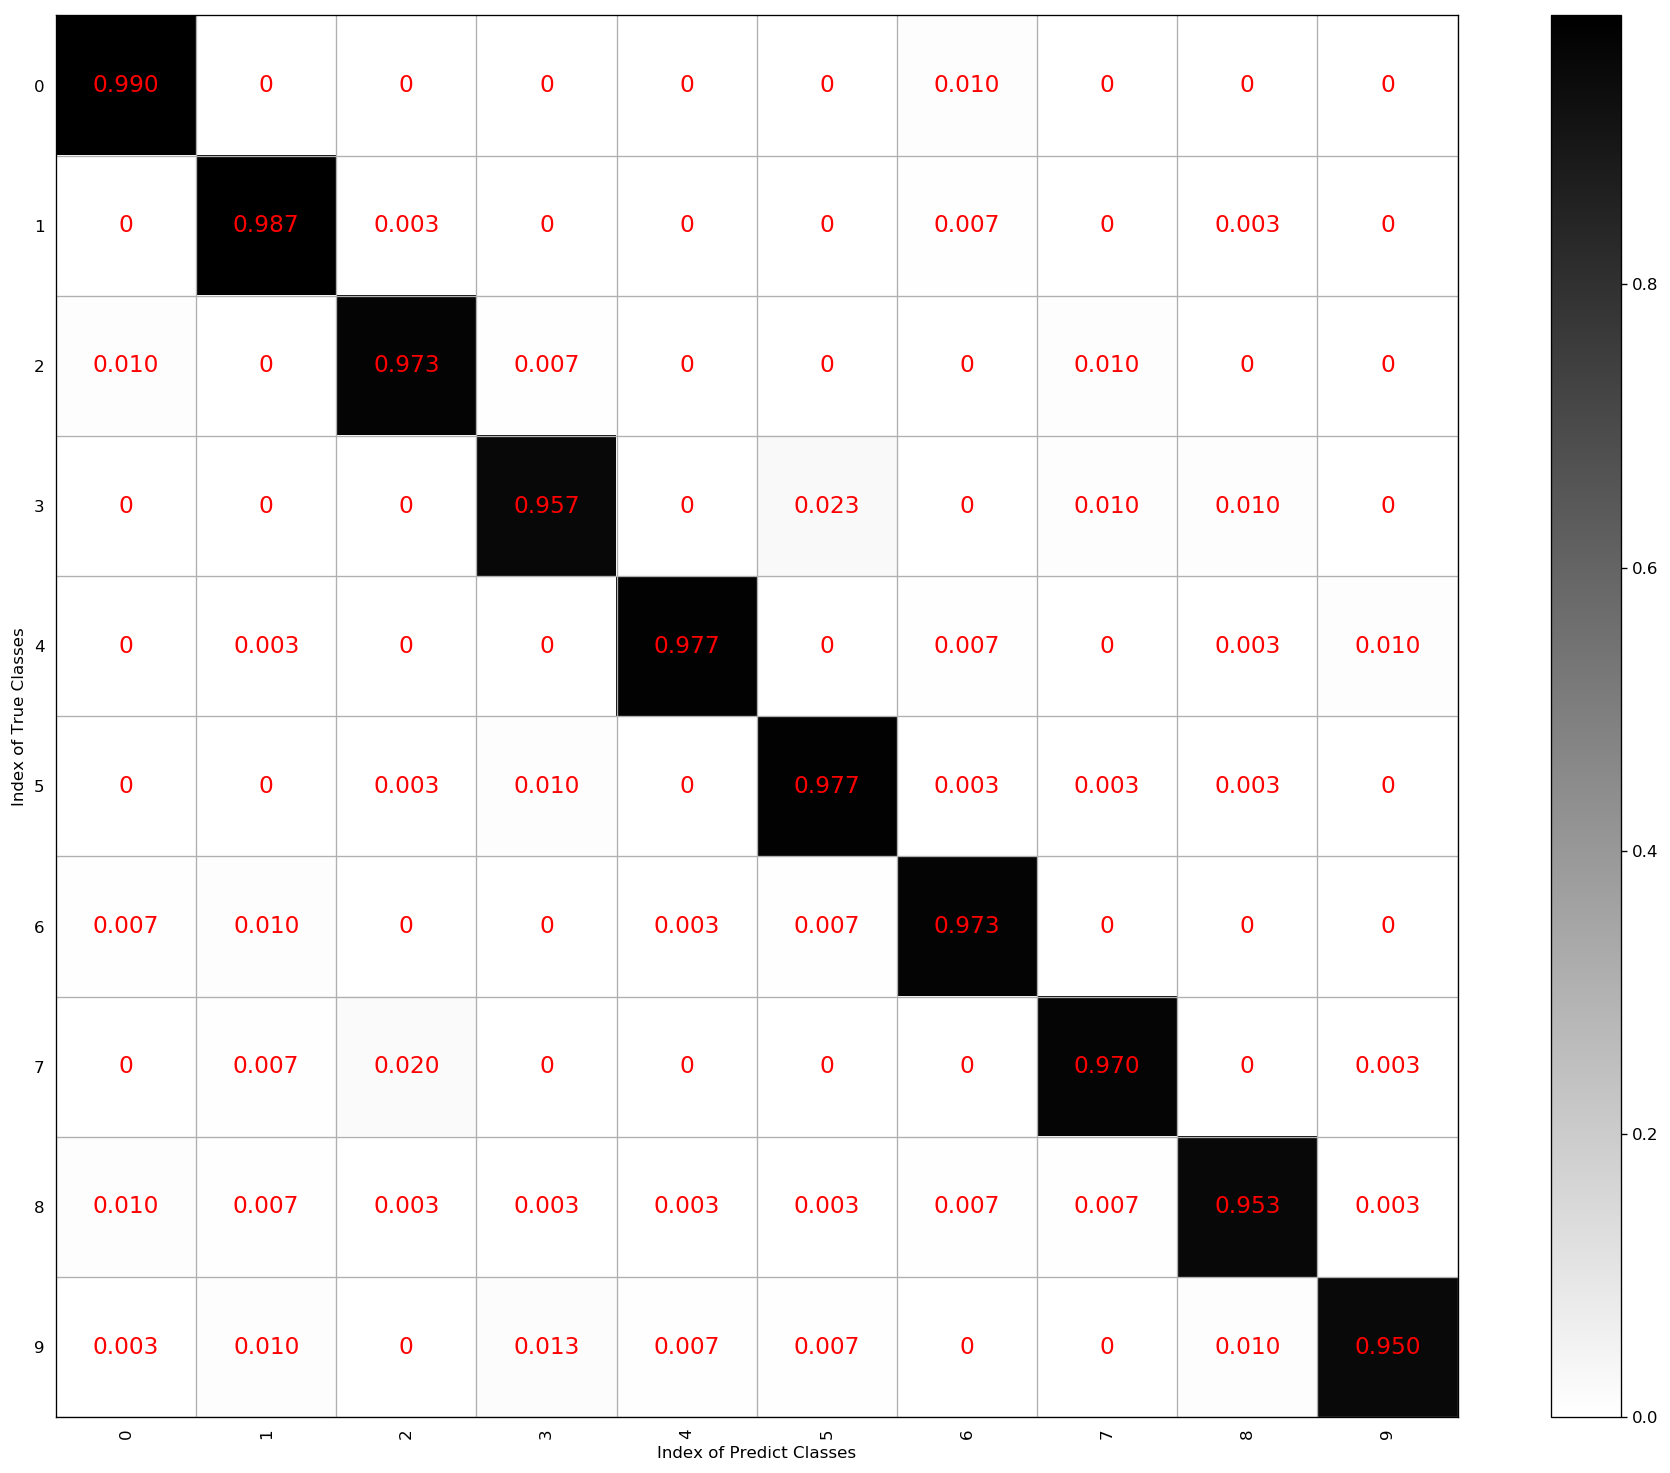

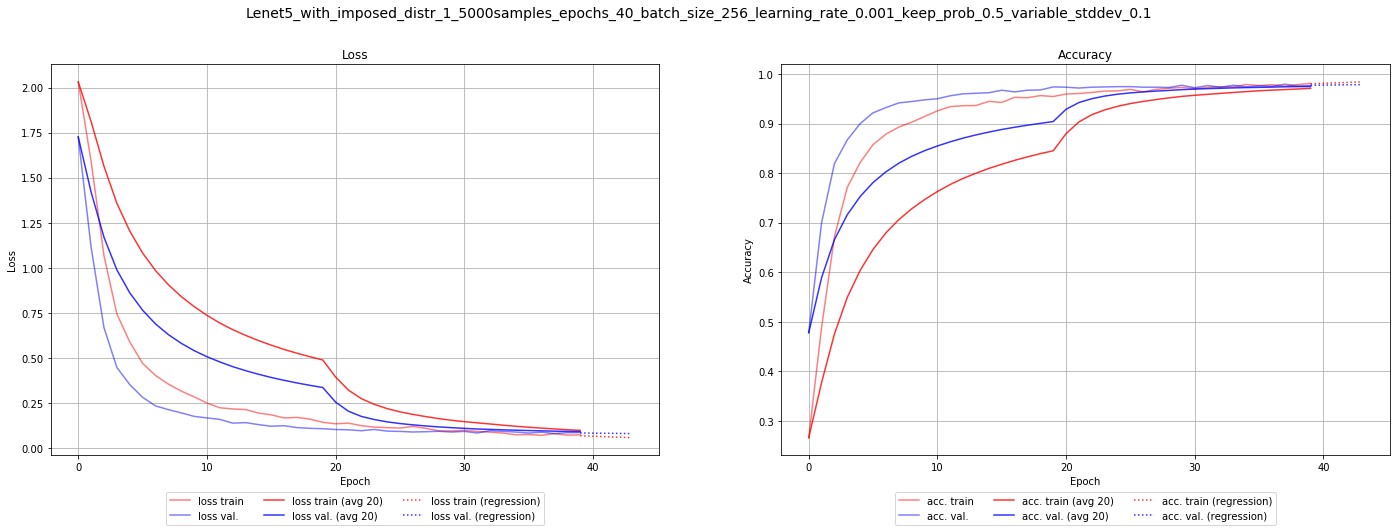

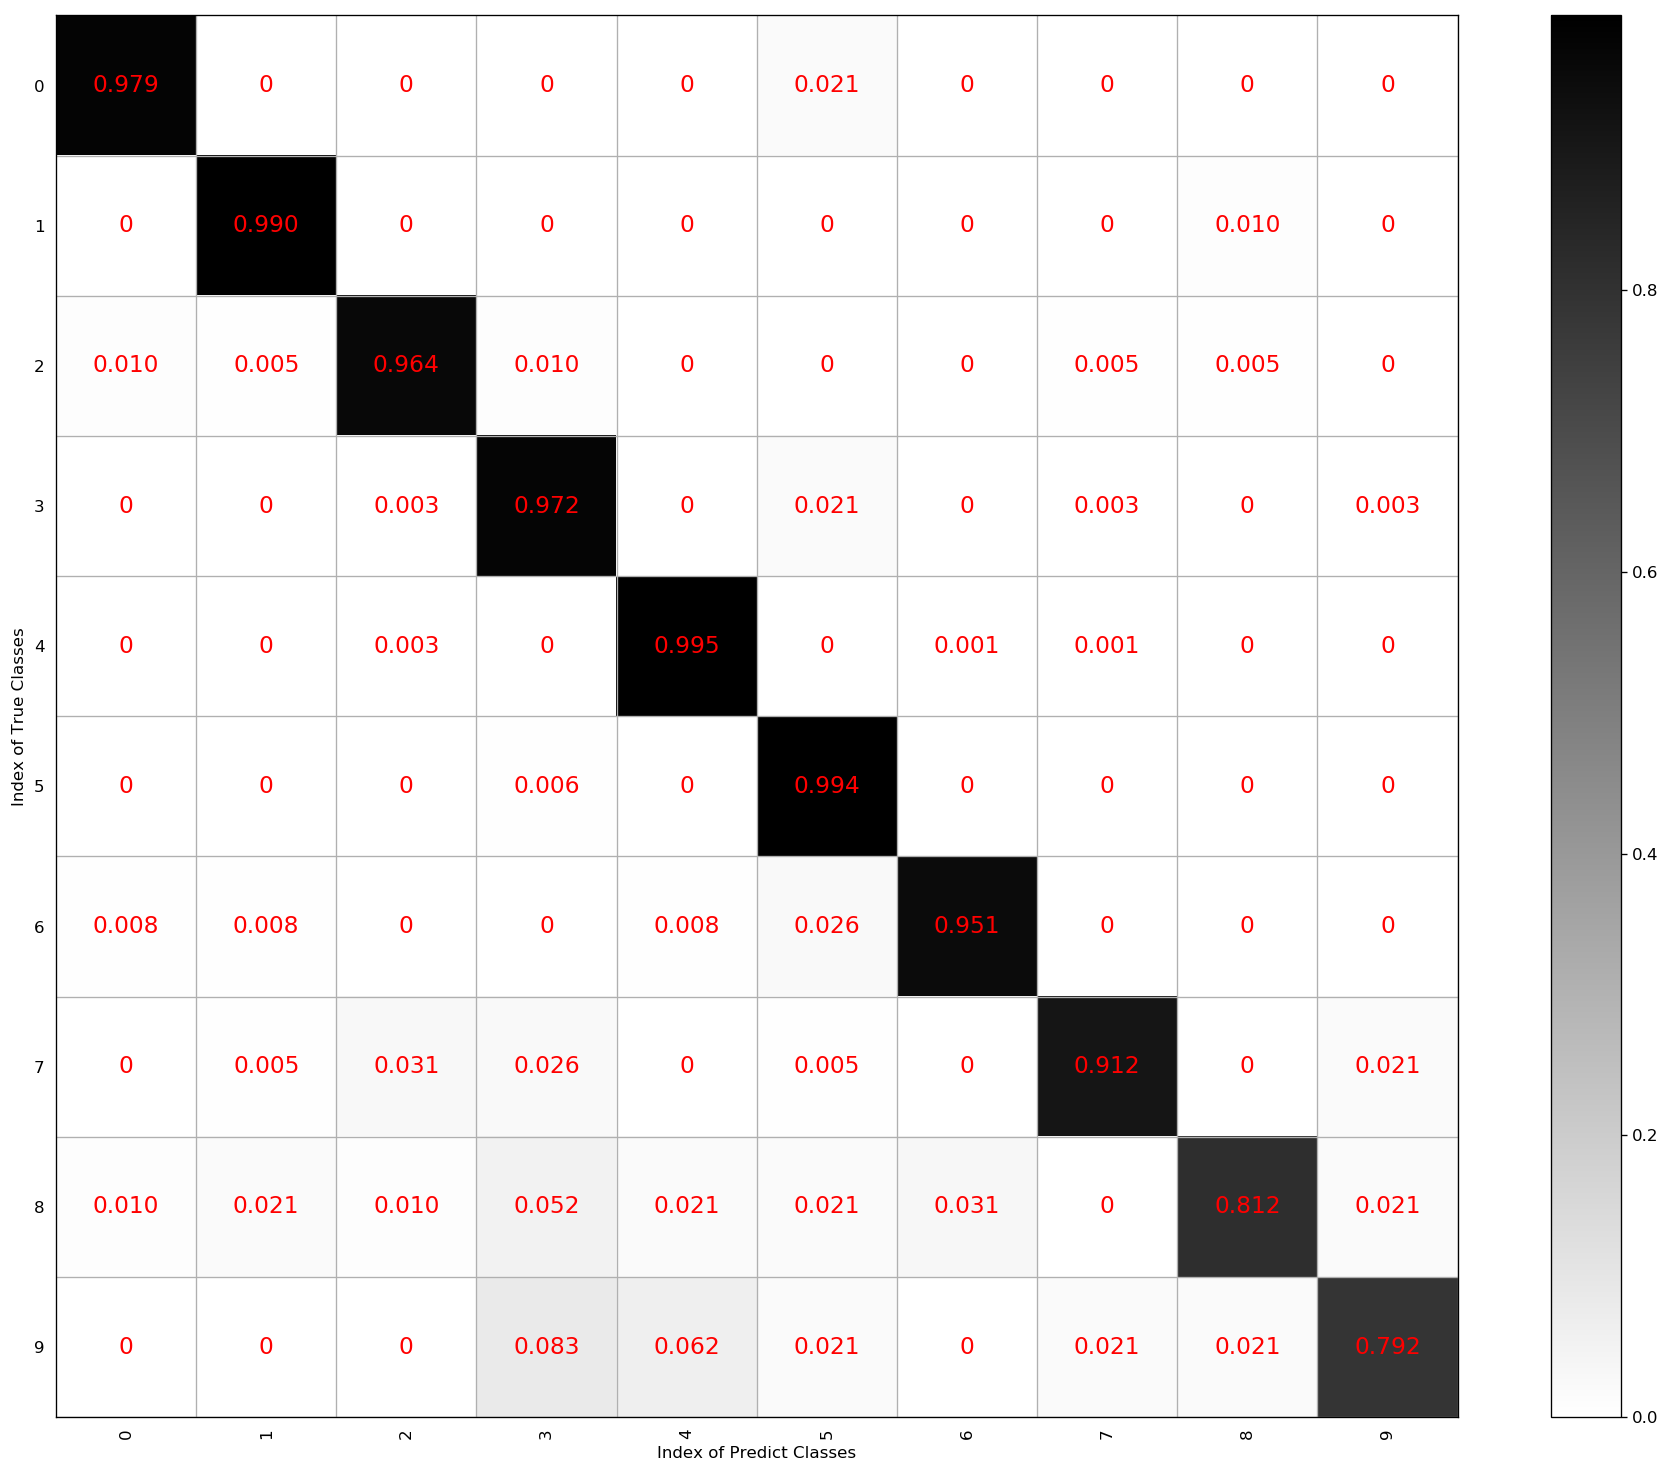

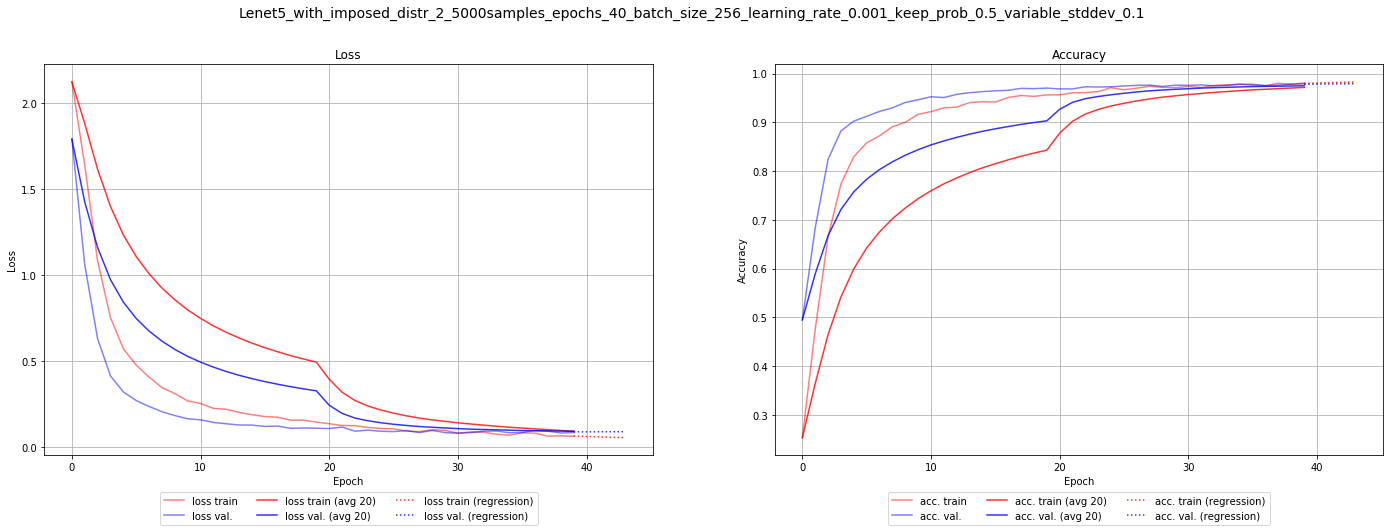

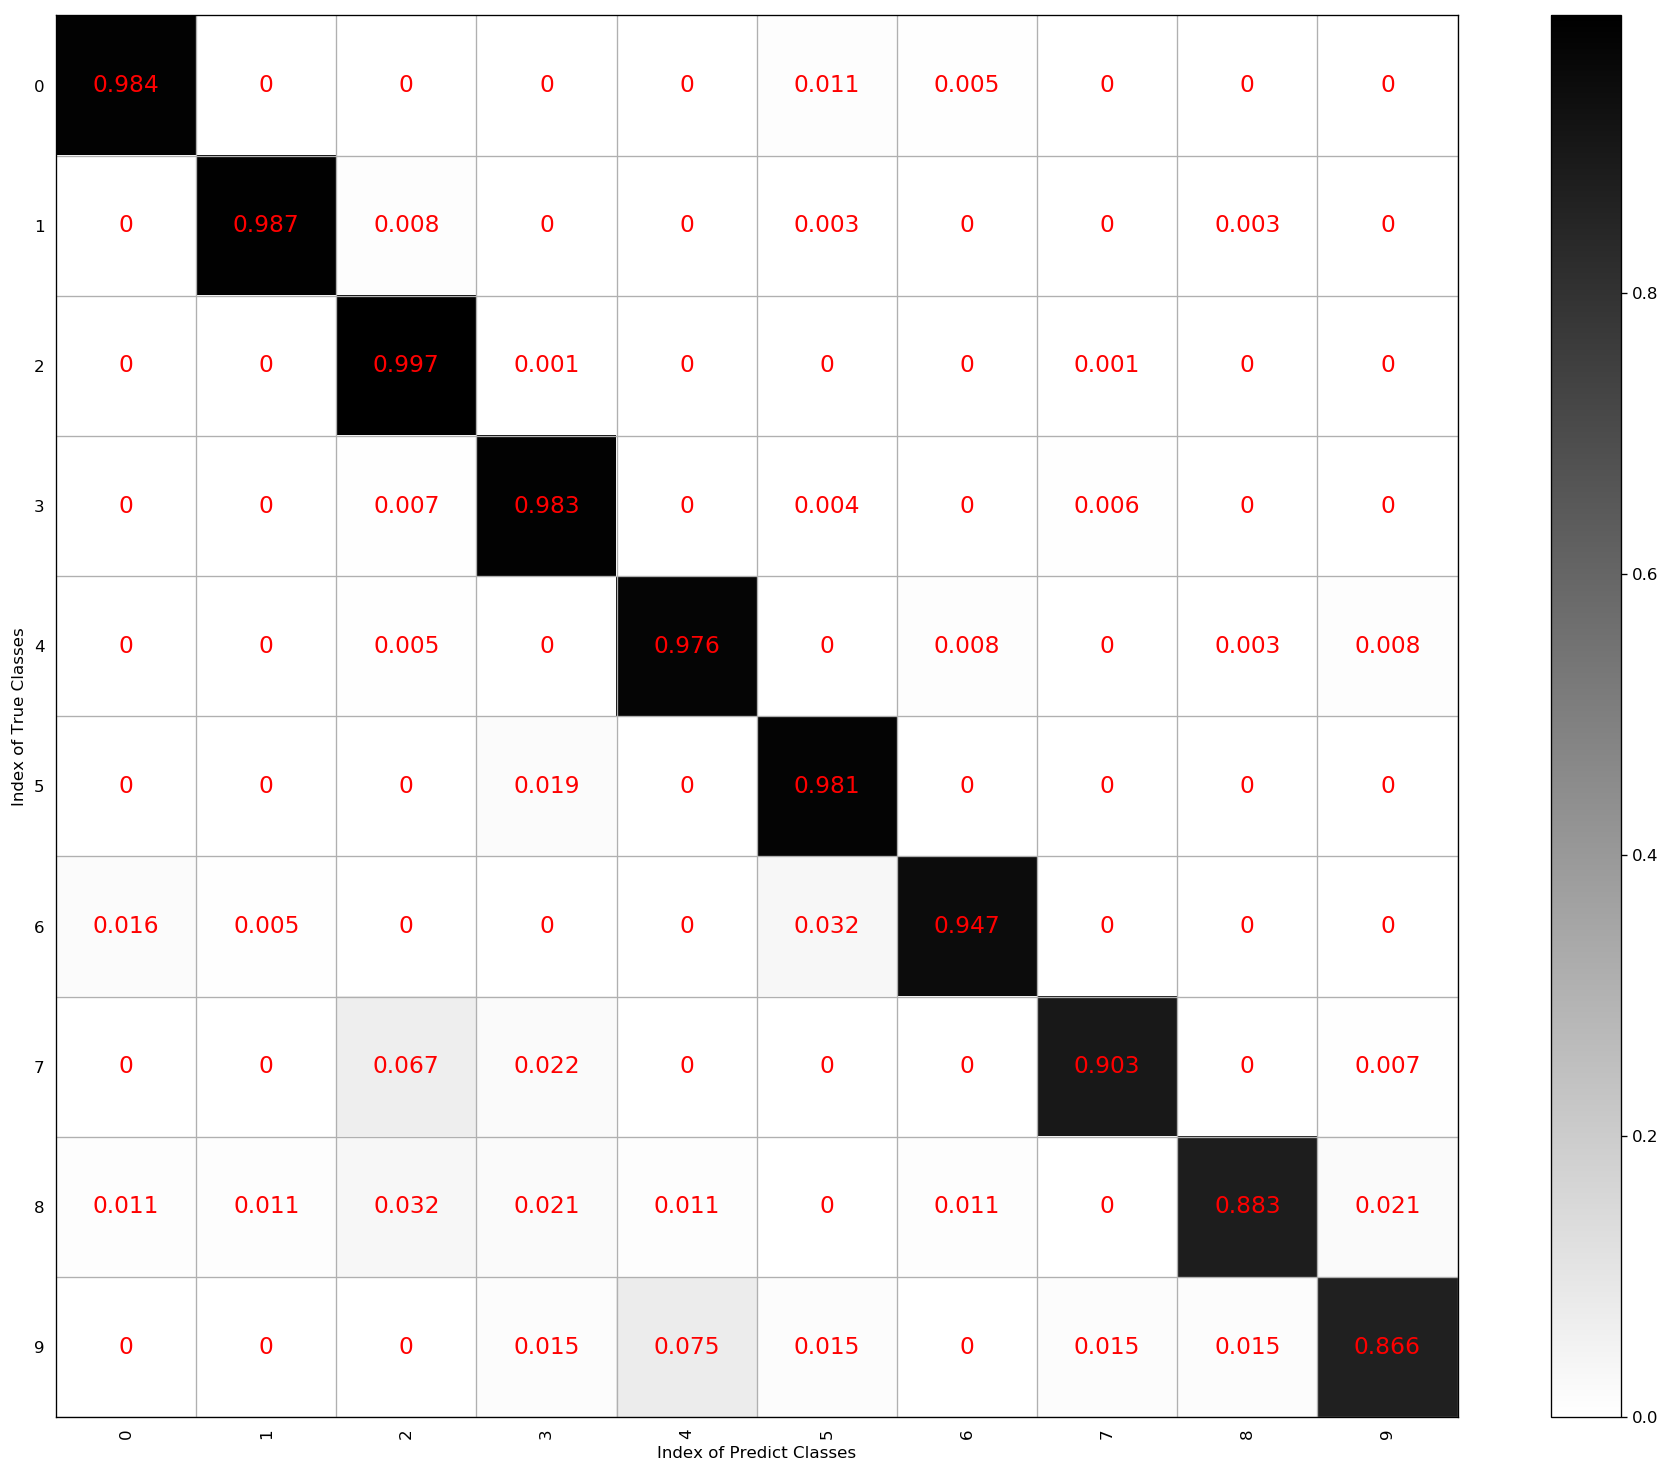

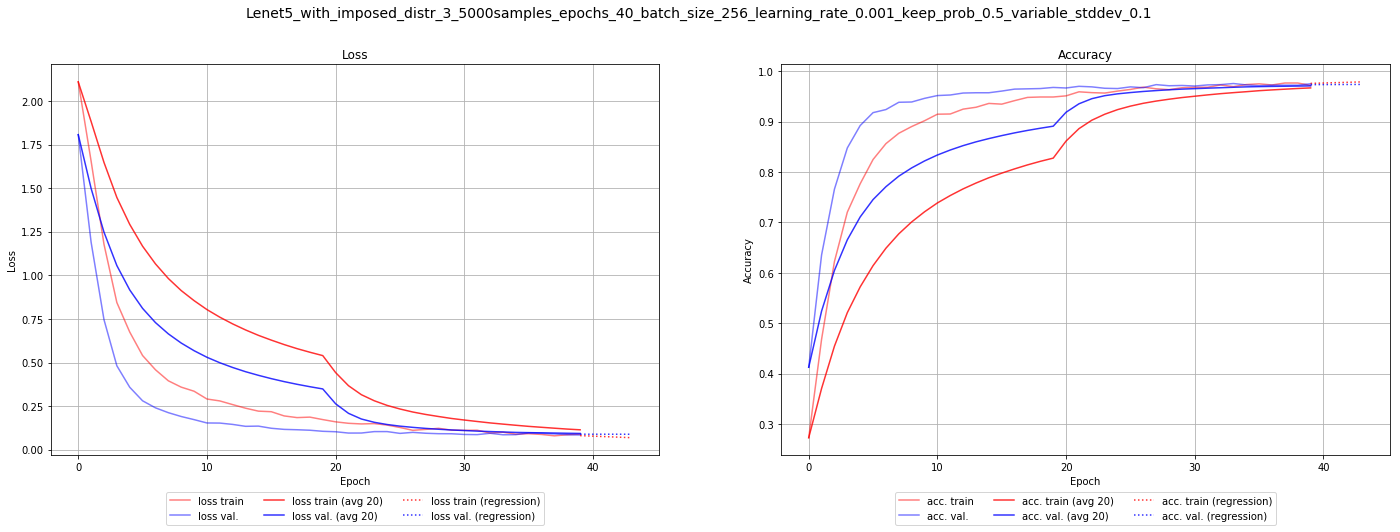

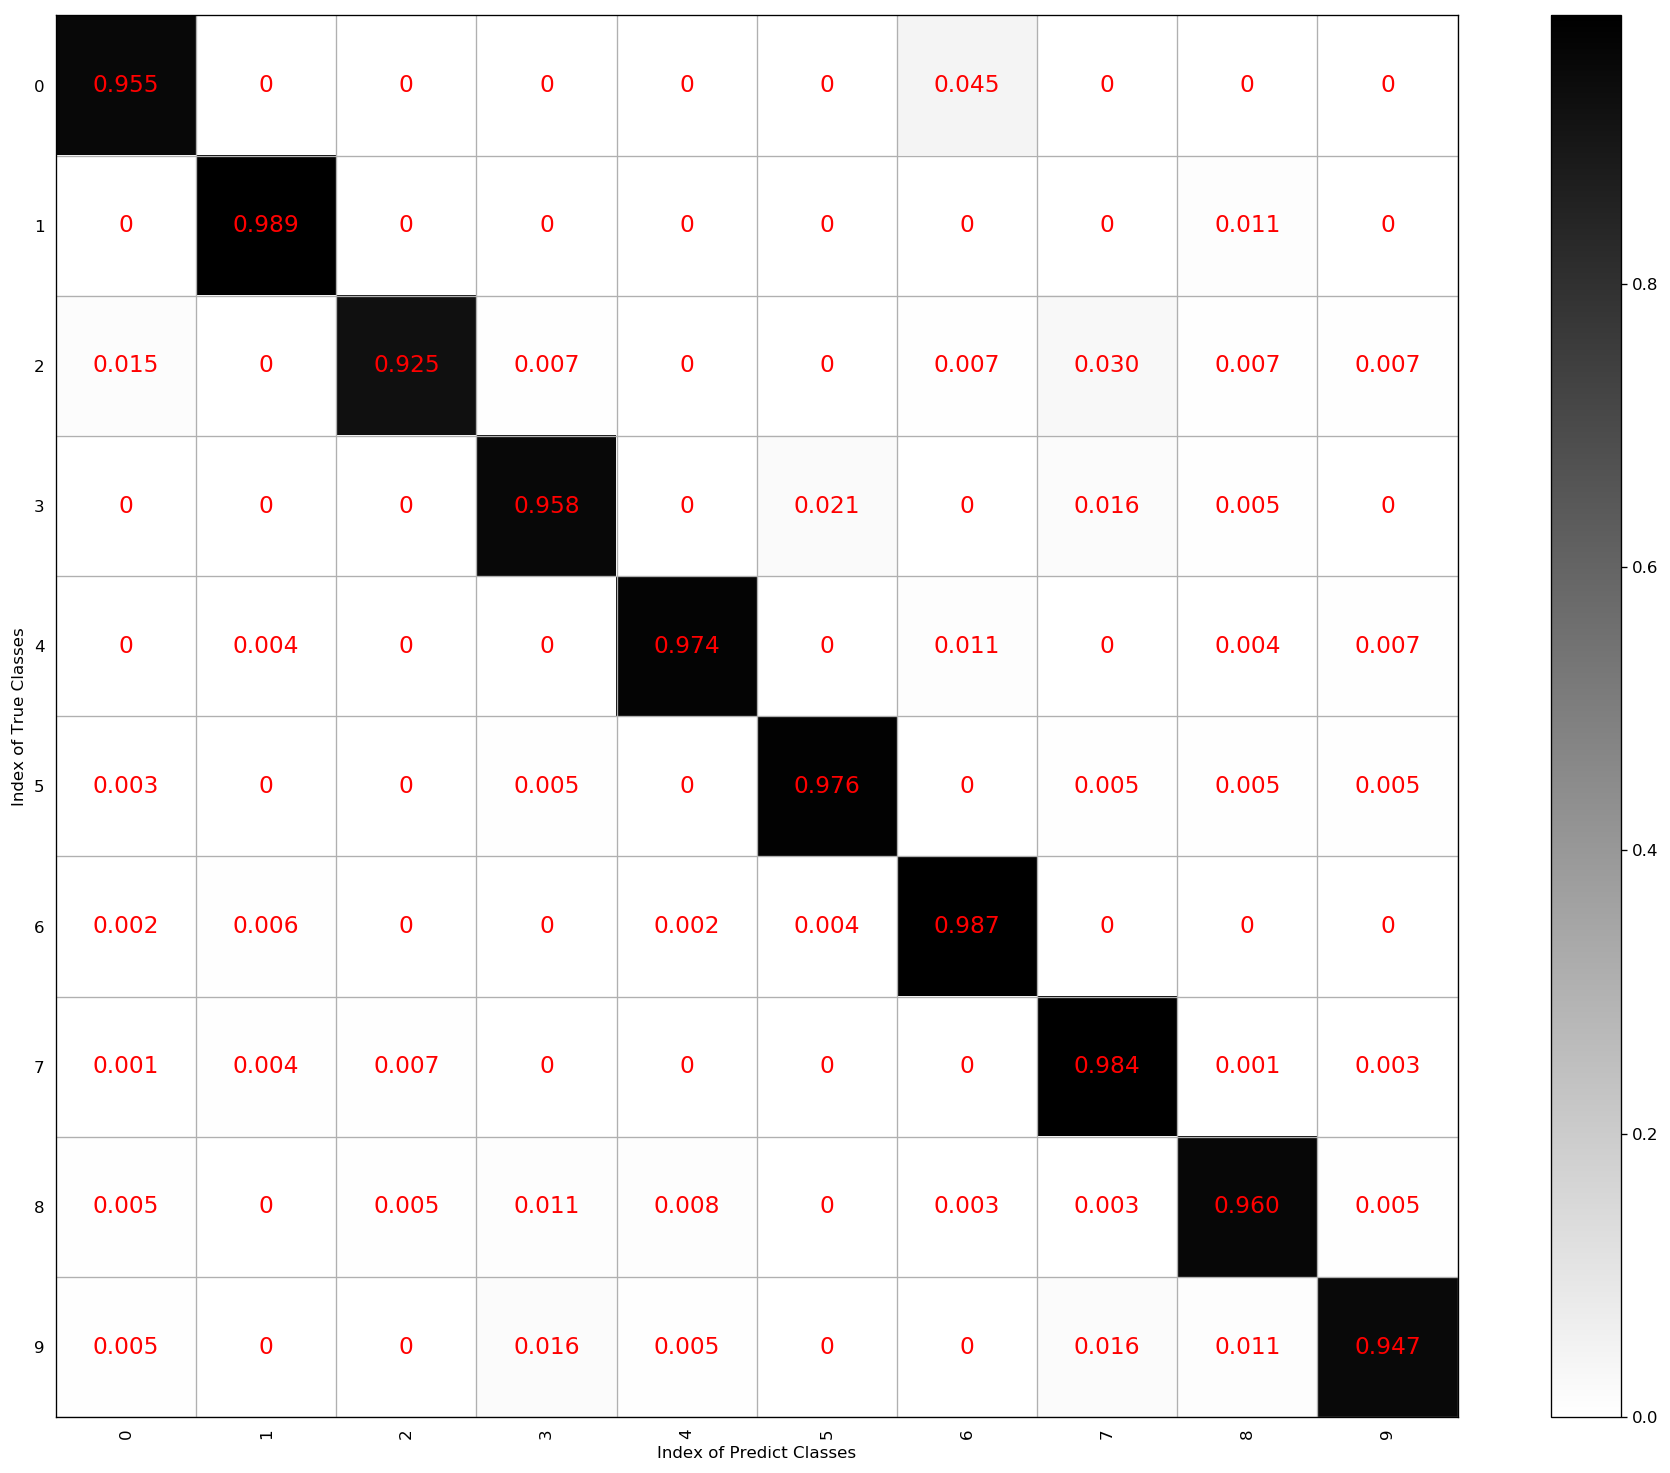

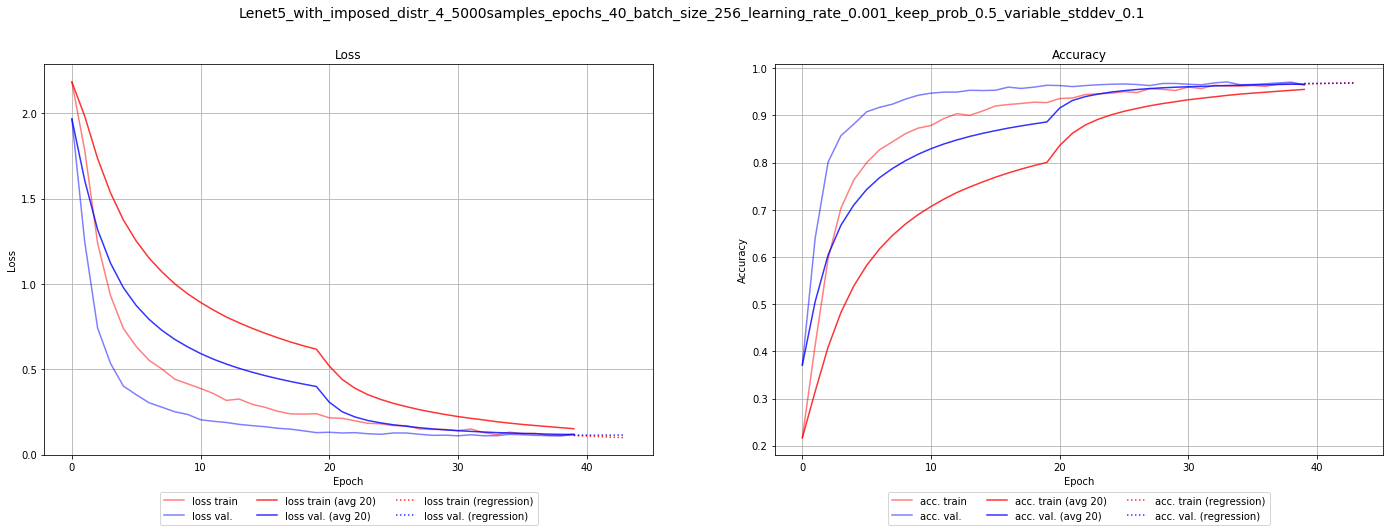

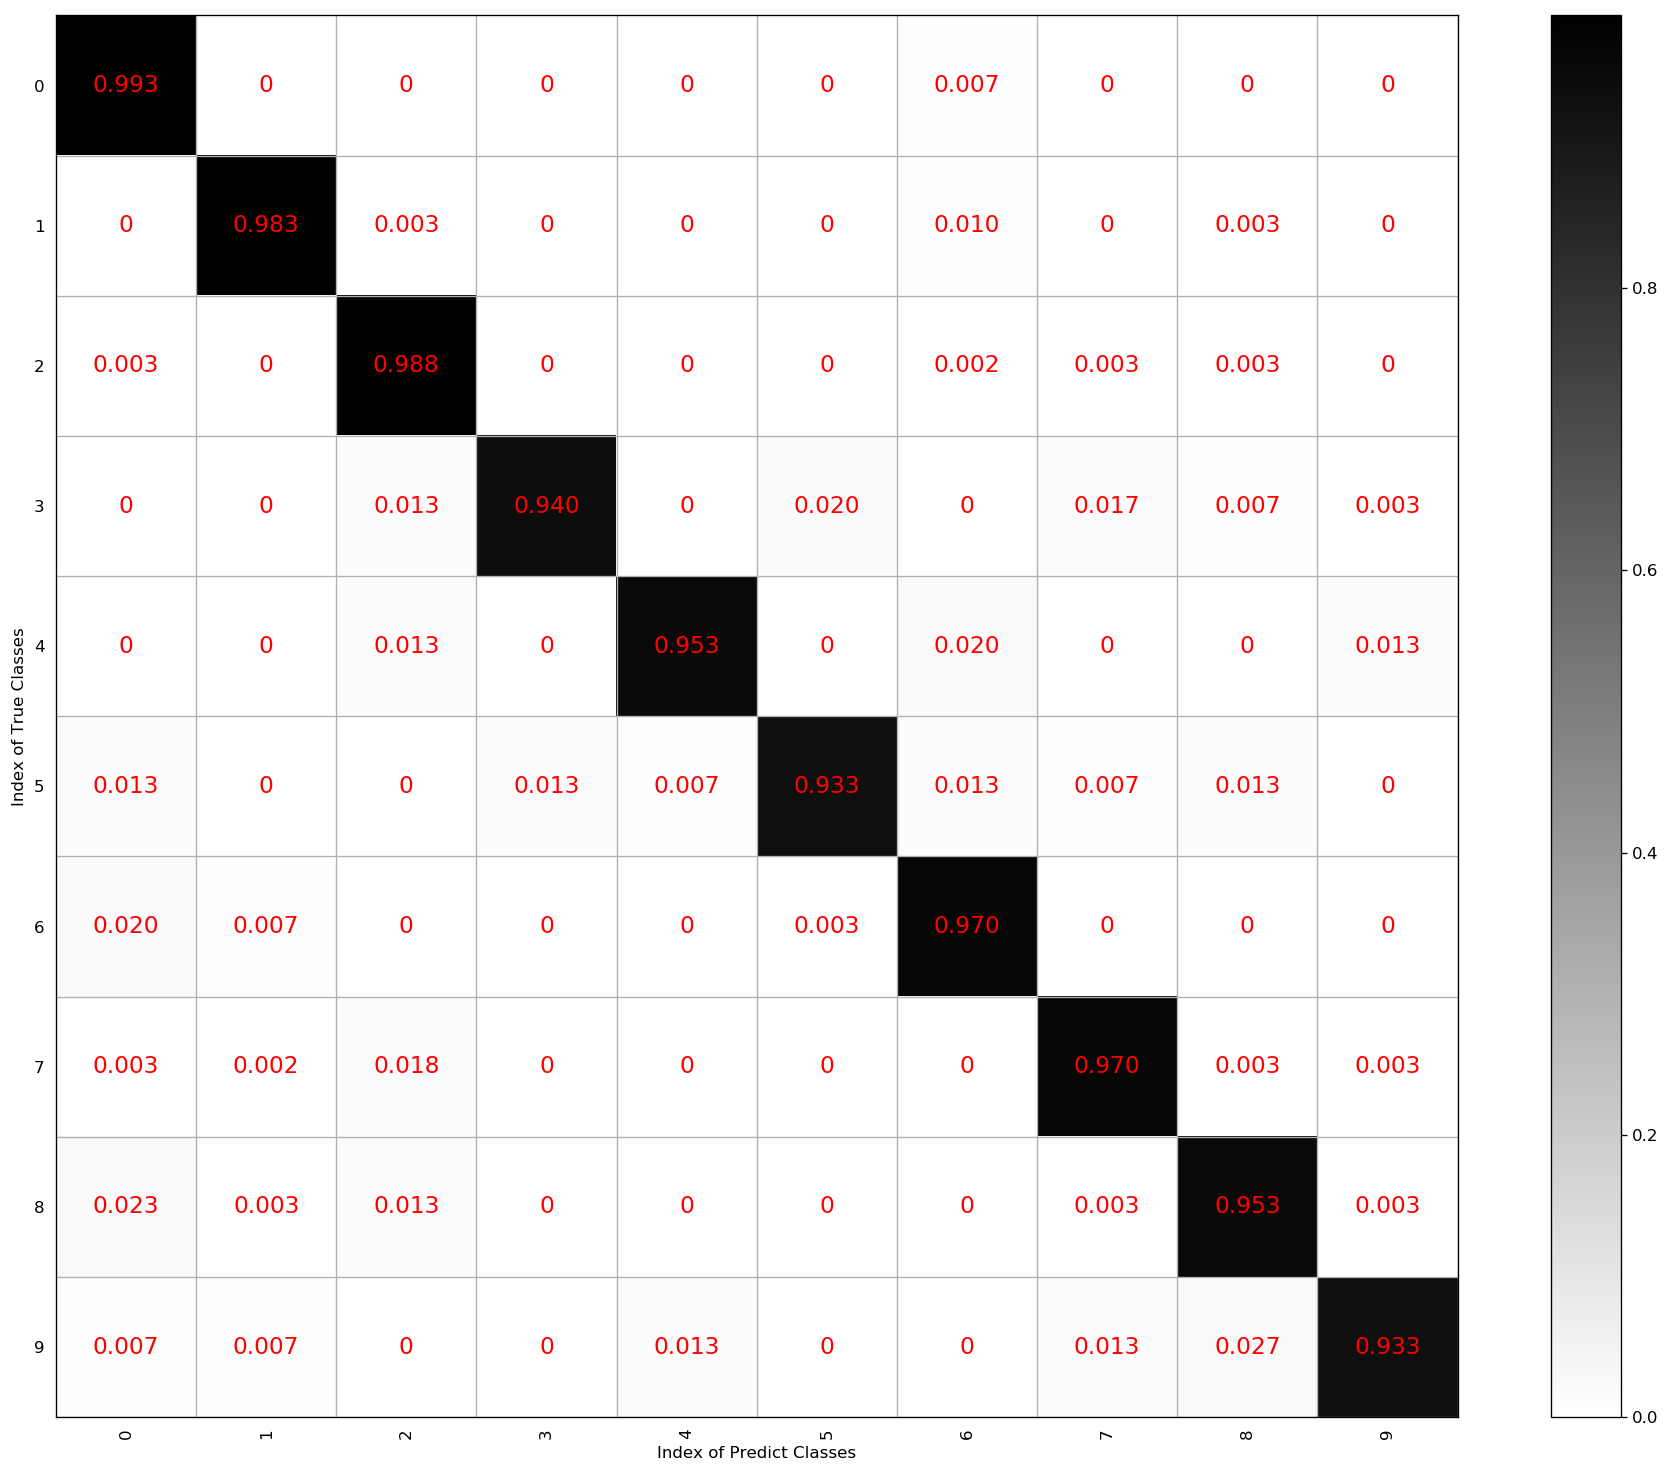

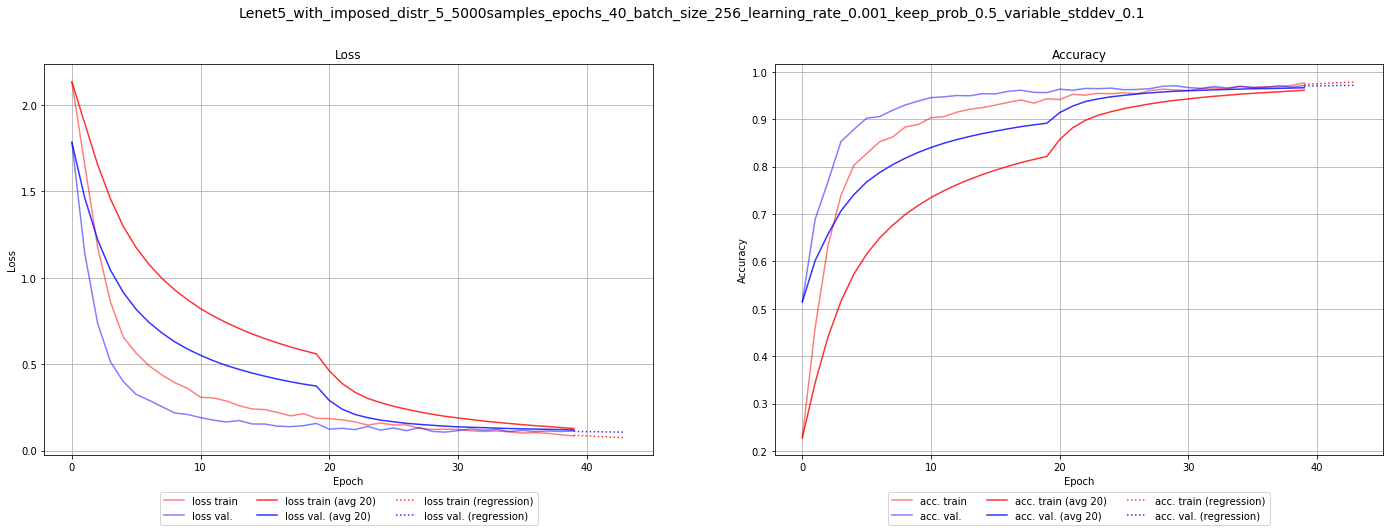

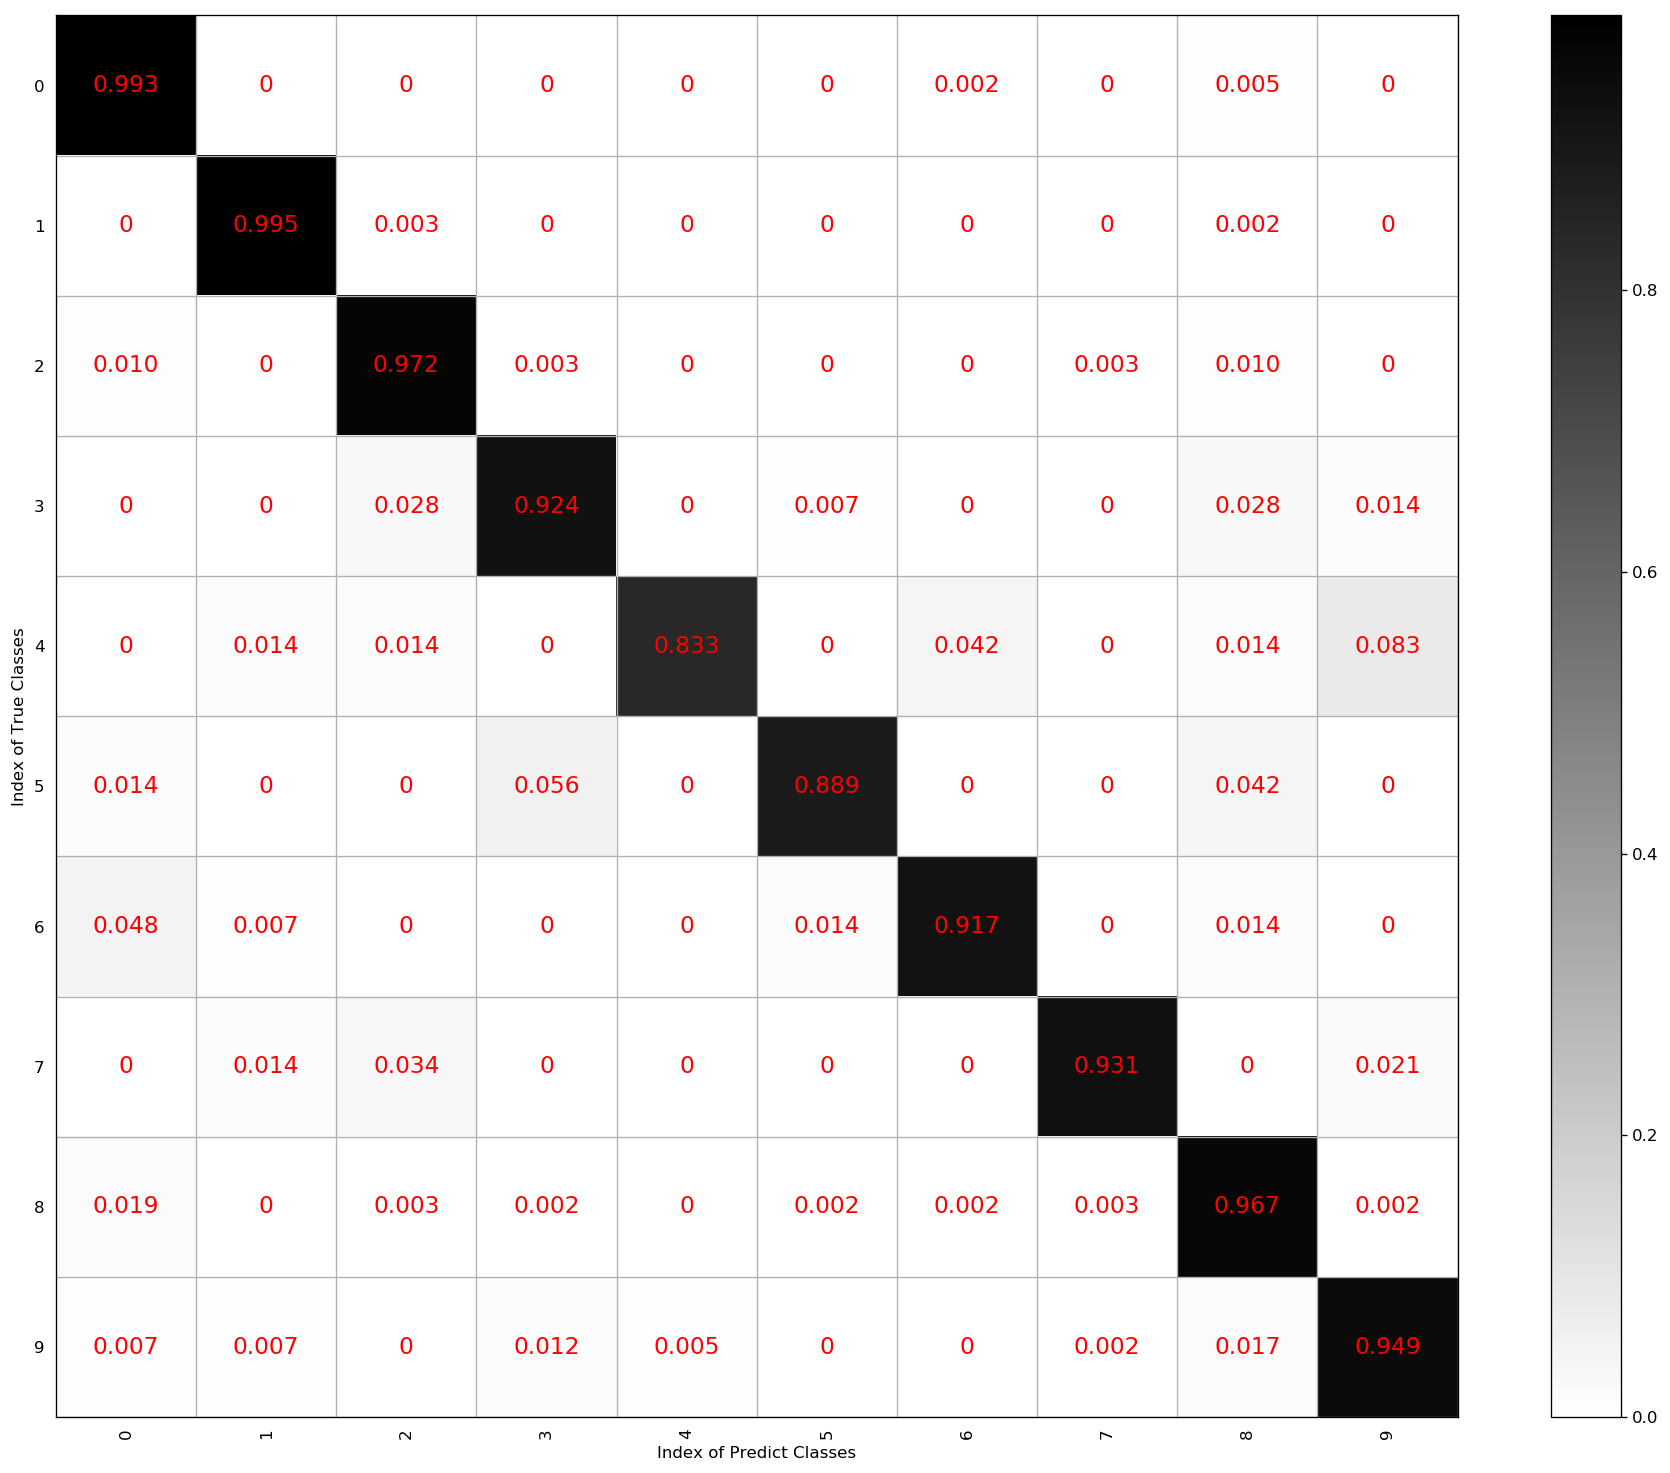

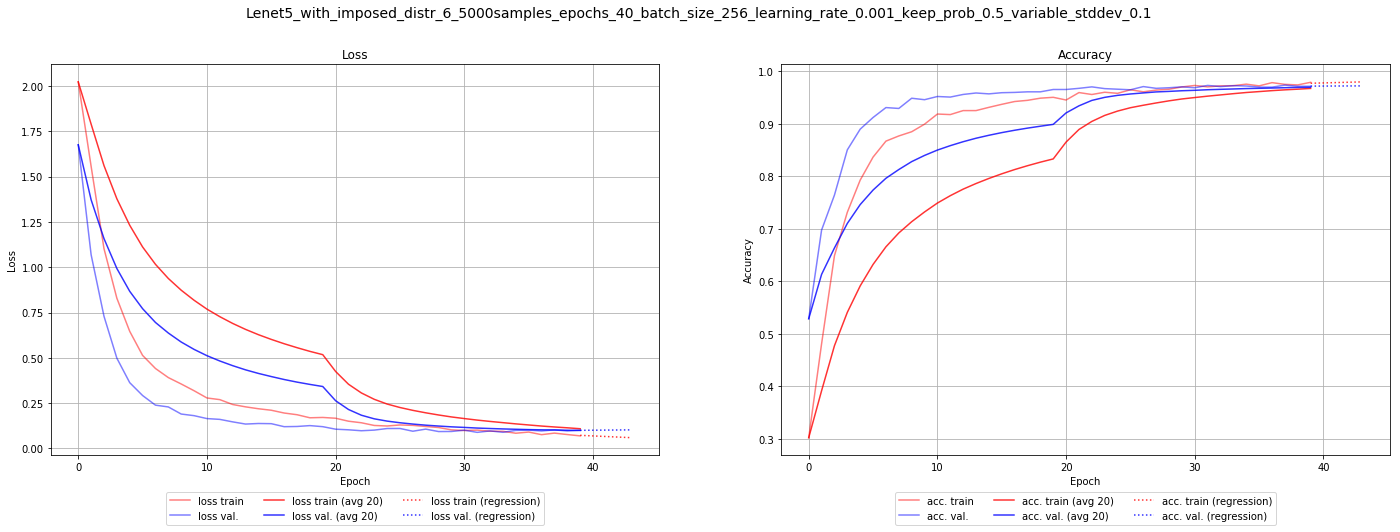

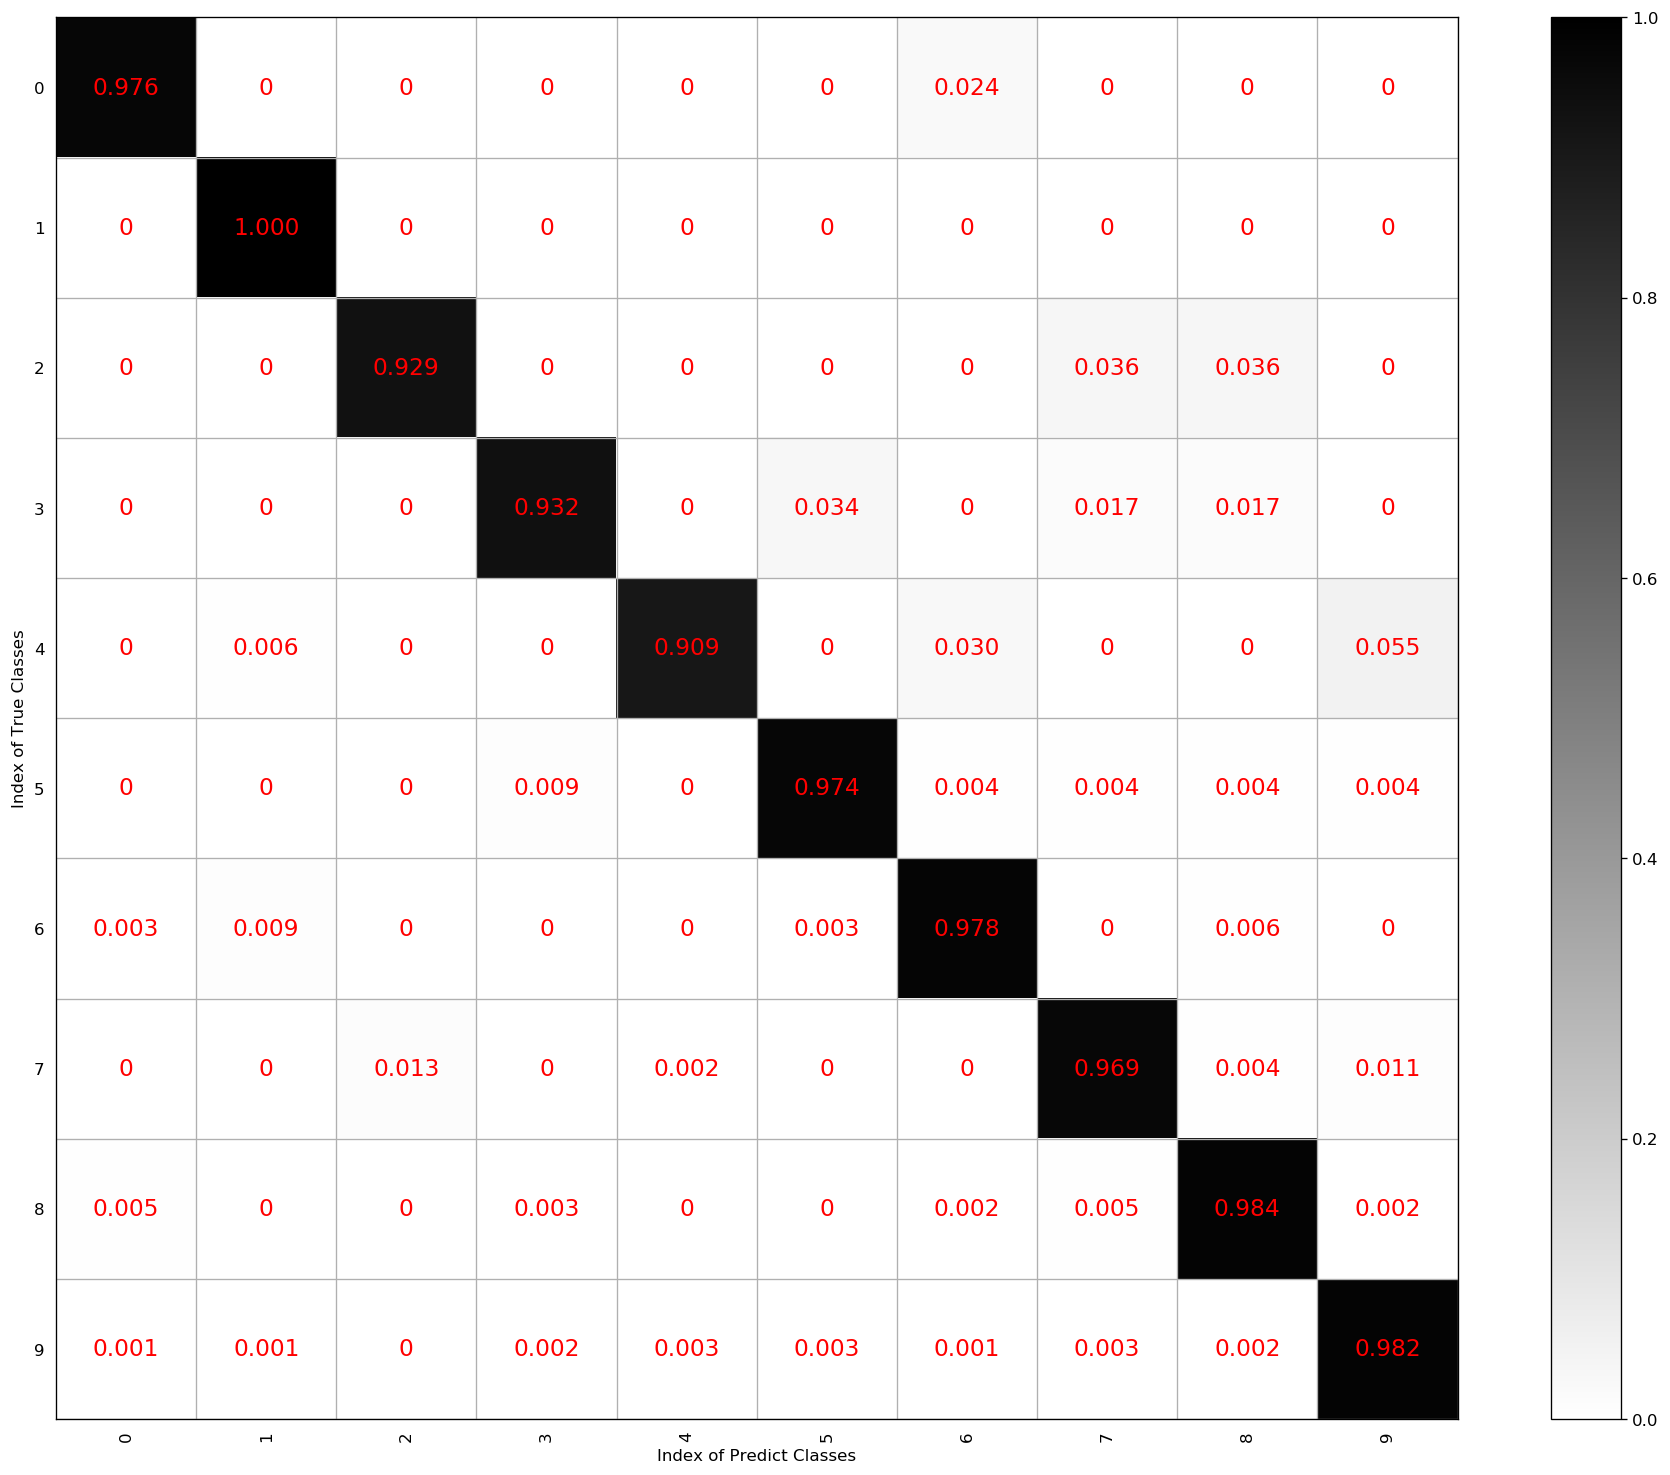

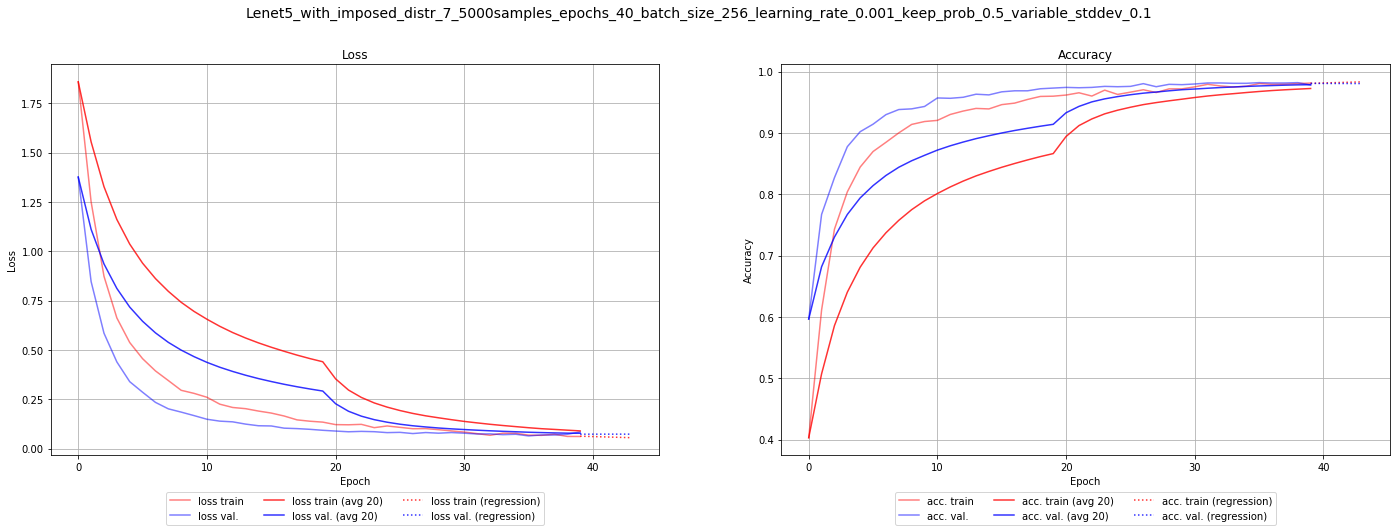

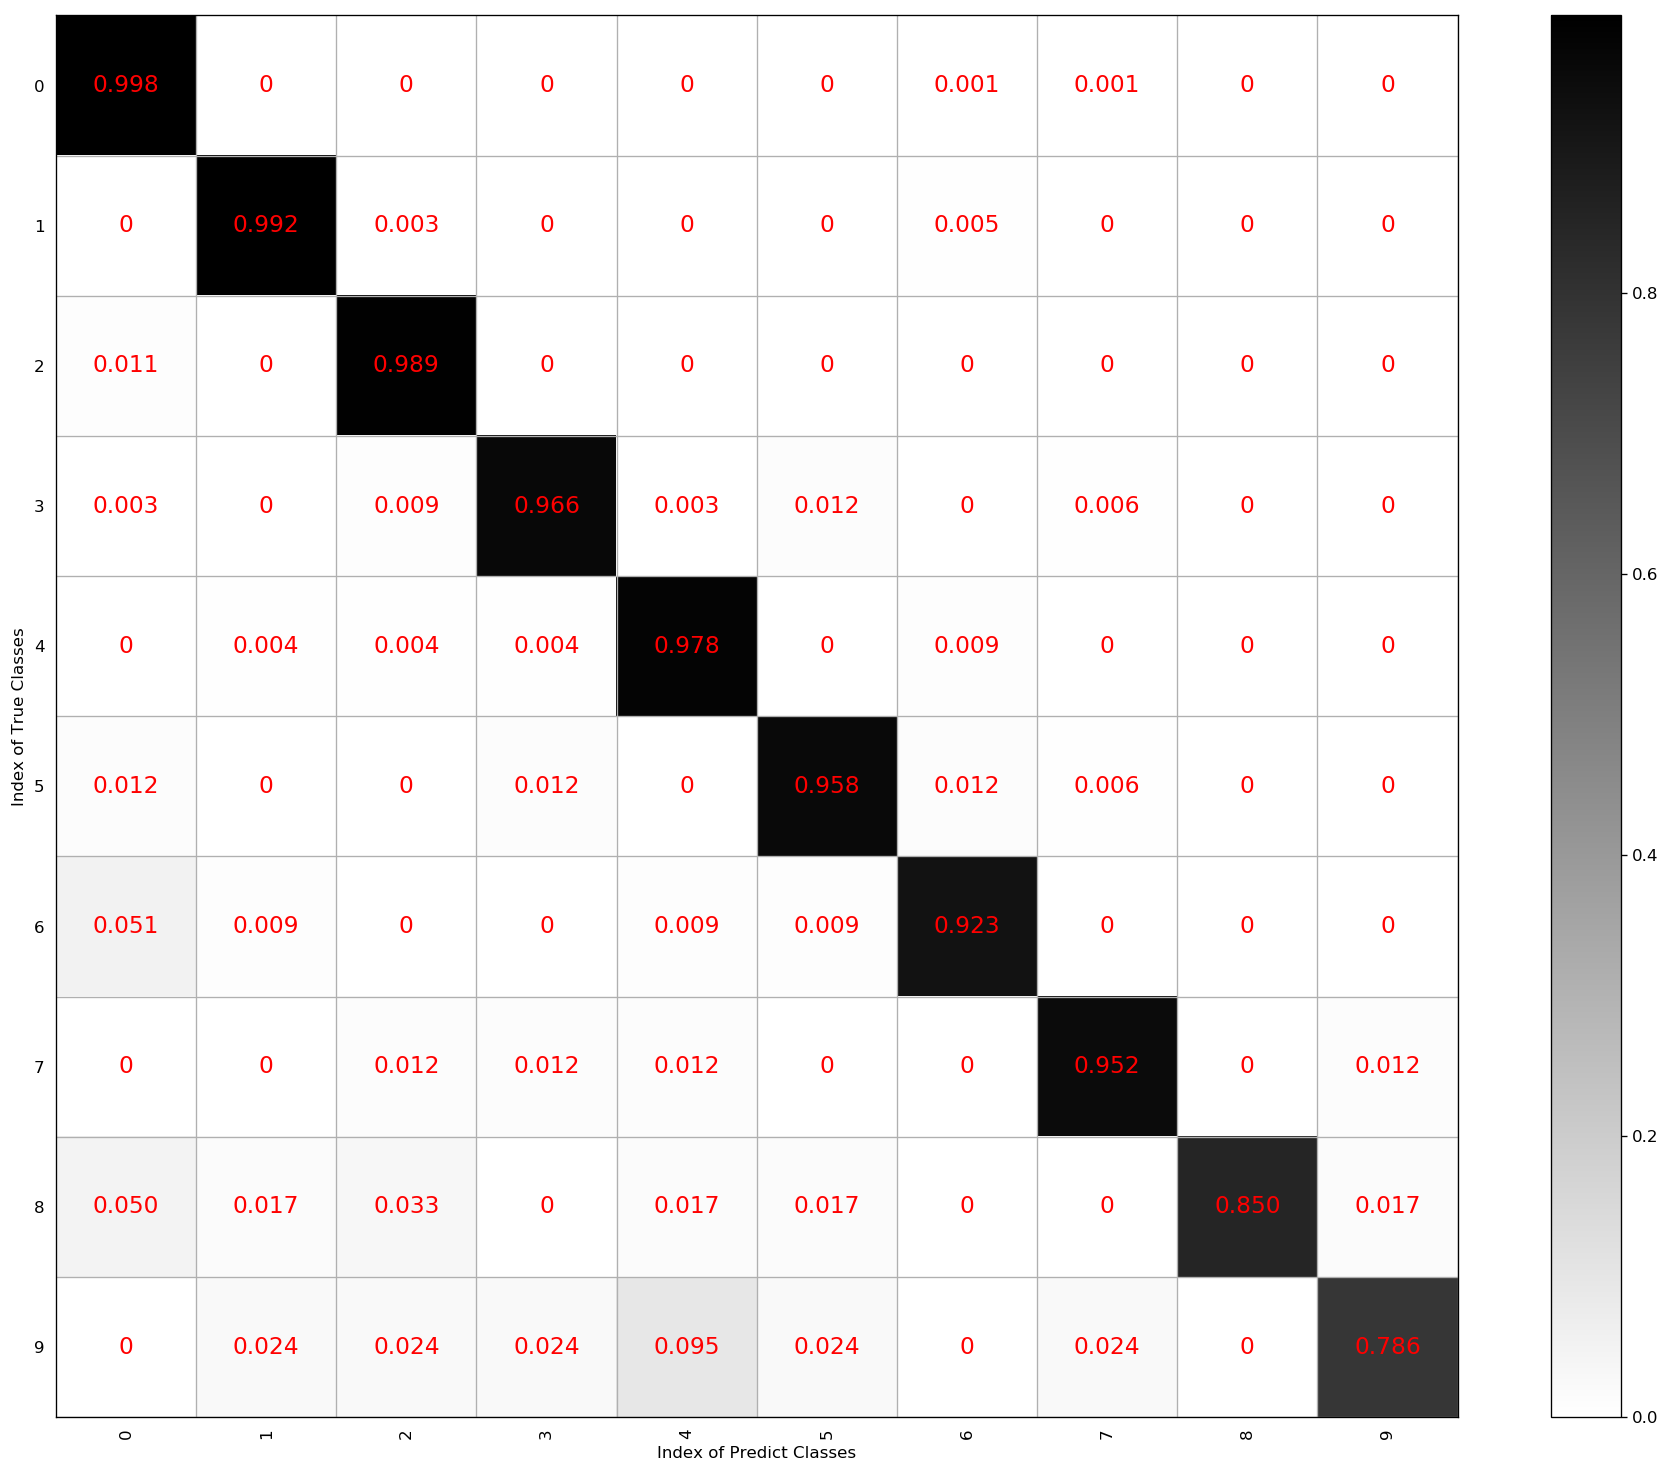

In [23]:
subset_size = 5000
global_max_weight = np.max(distrs_used_for_training)
for k, distr in enumerate(distrs_used_for_training):
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
#     mnist_ds.train.shuffle()
    print('\n\nk = {}: Imposed distribution: {}'.format(k, np.round(np.array(distr), decimals=3)))
    mnist_ds.impose_distribution(np.array(distr), global_max_weight, max_training_size=subset_size)
    lenet5_model = Lenet5(mnist_ds, "with_imposed_distr_{}_{}samples".format(k, subset_size), epochs=40, batch_size=256, variable_mean=0, variable_stddev=0.1, learning_rate=0.001, drop_out_keep_prob=0.5)
    lenet5_model.train()

### 3. Test the train models again on their test data and on data which respects the other distributions

In order to summarize the results, we will build a matrix, similar to a confusion matrix, as following:
- take each trained model and test it again on his initial test set
- then test each model on the data that respects, by turn, the other distributions considered
- save these results into a dictionary and then to disk for reuse them later
- finally, build a matrix where an element $m_{ij}$ represents the test accuracy of model $i$ evaluated on the subset with distribution $j$


In [9]:
def get_all_files_from_dir_ending_with(directory, ending, without_file_extension = False):
    file_list = []
    files = os.listdir(directory)
    files.sort(key=lambda fn: os.path.getmtime(os.path.join(directory, fn))) # sort by date
    for file in files:
        if file.endswith(ending):
            if without_file_extension:
                file_list.append(os.path.splitext(file)[0])
            else:
                file_list.append(file)
    return file_list

In [18]:
# ckpt_dir = "./results/PriorProbabilityShift_experiment_5_augmented/"
ckpt_dir = "./results/PriorProbabilityShift_experiment_5_10000samples/"
# ckpt_dir = "./results/PriorProbabilityShift_experiment_5_5000samples/"
ckpt_file_list = get_all_files_from_dir_ending_with(ckpt_dir, "ckpt.meta", without_file_extension=True)
perf_dict = {'idx_model':[], 'idx_distr':[], 'test_loss':[], 'test_acc':[], 'total_predict':[], 'total_actual':[], 'correct_predicted_distr':[], 'wrong_predicted_distr':[], 'wrong_actual_distr':[], 'train_distr':[], 'test_distr':[], 'ckpt_file':[]}

# build a list with all ditributions considered in training phase
distrs_used_for_training = []
for idx_model, ckpt_file in enumerate(ckpt_file_list):
    print('Restoring model {} from {}'.format(idx_model, ckpt_file))
    temp_model = Lenet5(mnist_dataset=mnist_ds, display_summary=False)
    temp_model.restore_session(ckpt_dir=ckpt_dir, ckpt_filename=ckpt_file)
    current_model_train_distr = temp_model.session.run(temp_model.train_distr)
    distrs_used_for_training.append(current_model_train_distr)   
    print('The restored model {} was trained using distr: {}\n'.format(idx_model, current_model_train_distr))

# test each model on each of the above distributions
print('\n\n\n--- test each model on all the above distributions ---\n')
for idx_model, ckpt_file in enumerate(ckpt_file_list):
    for idx_distr, distr in enumerate(distrs_used_for_training):
        # reload every time the original dataset in order to ensure that we build the subset starting from the same point
        mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
#         mnist_ds.test.shuffle()
#         mnist_ds.test.shuffle()
#         mnist_ds.test.shuffle()
        temp_model = Lenet5(mnist_ds, display_summary=False)
        temp_model.restore_session(ckpt_dir=ckpt_dir, ckpt_filename=ckpt_file)
        restored_train_distr = temp_model.session.run(temp_model.train_distr)
        print('Restoring model from {}'.format(ckpt_file))
        temp_model.restore_session(ckpt_dir=ckpt_dir, ckpt_filename=ckpt_file)
        print('train_distr: {}'.format(restored_train_distr))
        print('test_distr: {}'.format(distr))
        mnist_ds.impose_distribution(np.array(distr), np.max(distrs_used_for_training))
        test_loss, test_acc, total_predict, total_actual, wrong_predict_images, _= temp_model.test_data(mnist_ds.test, use_only_one_batch=True)
        perf_dict['idx_model'].append(idx_model)
        perf_dict['idx_distr'].append(idx_distr)
        perf_dict['test_loss'].append(test_loss)
        perf_dict['test_acc'].append(test_acc)
        perf_dict['total_predict'].append(total_predict)
        perf_dict['total_actual'].append(total_actual)
        correct_predict = total_predict[total_actual == total_predict]
        wrong_predict = total_predict[total_actual != total_predict]
        wrong_actual = total_actual[total_actual != total_predict]
        perf_dict['correct_predicted_distr'].append(np.histogram(correct_predict)[0])
        perf_dict['wrong_predicted_distr'].append(np.histogram(wrong_predict)[0])
        perf_dict['wrong_actual_distr'].append(np.histogram(wrong_actual)[0])
        perf_dict['train_distr'].append(distr)
        perf_dict['test_distr'].append(mnist_ds.test.label_distr)
        perf_dict['ckpt_file'].append(ckpt_file)
        print('idx_model = {}, idx_distr = {}: test_loss = {:.3f}, test_acc = {:.3f} ({}/{})\n\n\n'.format(idx_model, idx_distr, test_loss, test_acc, mnist_ds.test.num_examples - len(wrong_predict_images), mnist_ds.test.num_examples))
        
# save the above results dictionary to file
filename = 'results_{}.dict.pickle'.format(Utils.now_as_str())
full_filepath = os.path.join(ckpt_dir, filename)
filehandler = open(full_filepath, 'wb') 
pickle.dump(perf_dict, filehandler)
print('Results dictionary was succesfully saved to: {}'.format(full_filepath))
filehandler.close()


Restoring model 0 from Lenet5_with_imposed_distr_0_10000samples_2018_05_07---10_33.model.ckpt
The restored model 0 was trained using distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]

Restoring model 1 from Lenet5_with_imposed_distr_1_10000samples_2018_05_07---10_39.model.ckpt
The restored model 1 was trained using distr: [0.016 0.032 0.065 0.129 0.258 0.258 0.129 0.065 0.032 0.016]

Restoring model 2 from Lenet5_with_imposed_distr_2_10000samples_2018_05_07---10_45.model.ckpt
The restored model 2 was trained using distr: [0.063 0.127 0.254 0.179 0.127 0.089 0.063 0.045 0.032 0.022]

Restoring model 3 from Lenet5_with_imposed_distr_3_10000samples_2018_05_07---10_51.model.ckpt
The restored model 3 was trained using distr: [0.022 0.032 0.045 0.063 0.089 0.127 0.179 0.254 0.127 0.063]

Restoring model 4 from Lenet5_with_imposed_distr_4_10000samples_2018_05_07---10_56.model.ckpt
The restored model 4 was trained using distr: [0.05 0.1  0.2  0.1  0.05 0.05 0.1  0.2  0.1  0.05]

Restoring model

train_distr: [0.063 0.127 0.254 0.179 0.127 0.089 0.063 0.045 0.032 0.022]
test_distr: [0.137 0.194 0.097 0.048 0.024 0.024 0.048 0.097 0.194 0.137]
idx_model = 2, idx_distr = 5: test_loss = 0.135, test_acc = 0.965 (2895/3000)



Restoring model from Lenet5_with_imposed_distr_2_10000samples_2018_05_07---10_45.model.ckpt
train_distr: [0.063 0.127 0.254 0.179 0.127 0.089 0.063 0.045 0.032 0.022]
test_distr: [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]
idx_model = 2, idx_distr = 6: test_loss = 0.177, test_acc = 0.955 (2866/3000)



Restoring model from Lenet5_with_imposed_distr_2_10000samples_2018_05_07---10_45.model.ckpt
train_distr: [0.063 0.127 0.254 0.179 0.127 0.089 0.063 0.045 0.032 0.022]
test_distr: [0.296 0.211 0.151 0.108 0.077 0.055 0.039 0.028 0.02  0.014]
idx_model = 2, idx_distr = 7: test_loss = 0.054, test_acc = 0.983 (2948/3000)



Restoring model from Lenet5_with_imposed_distr_3_10000samples_2018_05_07---10_51.model.ckpt
train_distr: [0.022 0.032 0.045 0.

train_distr: [0.137 0.194 0.097 0.048 0.024 0.024 0.048 0.097 0.194 0.137]
test_distr: [0.296 0.211 0.151 0.108 0.077 0.055 0.039 0.028 0.02  0.014]
idx_model = 5, idx_distr = 7: test_loss = 0.078, test_acc = 0.981 (2942/3000)



Restoring model from Lenet5_with_imposed_distr_6_10000samples_2018_05_07---11_08.model.ckpt
train_distr: [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]
test_distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
idx_model = 6, idx_distr = 0: test_loss = 0.133, test_acc = 0.964 (2893/3000)



Restoring model from Lenet5_with_imposed_distr_6_10000samples_2018_05_07---11_08.model.ckpt
train_distr: [0.014 0.02  0.028 0.039 0.055 0.077 0.108 0.151 0.211 0.296]
test_distr: [0.016 0.032 0.065 0.129 0.258 0.258 0.129 0.065 0.032 0.016]
idx_model = 6, idx_distr = 1: test_loss = 0.129, test_acc = 0.966 (2898/3000)



Restoring model from Lenet5_with_imposed_distr_6_10000samples_2018_05_07---11_08.model.ckpt
train_distr: [0.014 0.02  0.028 0.039 0.055 0.077 0.10

Results dictionary was succesfully restored from: results_2018_05_08---01_03.dict.pickle


idx_model  idx_distr  test_loss  test_acc
count     64.000     64.000     64.000    64.000
mean       3.500      3.500      0.110     0.972
std        2.309      2.309      0.047     0.010
min        0.000      0.000      0.053     0.937
25%        1.750      1.750      0.077     0.967
50%        3.500      3.500      0.101     0.975
75%        5.250      5.250      0.133     0.979
max        7.000      7.000      0.301     0.986

idx_model  idx_distr  test_loss  test_acc  \
0           0          0      0.091     0.975   
1           0          1      0.084     0.978   
2           0          2      0.076     0.977   
3           0          3      0.092     0.976   
4           0          4      0.083     0.977   
5           0          5      0.083     0.977   
6           0          6      0.105     0.971   
7           0          7      0.067     0.984   
8           1          0      0.150     0.960   
9           1          1      0.075     0.981   
10          1          2      0.099     0.973   
11          1          3      0.135     0.967   
12          1          4      0.142     0.964   
13          1          5      0.189     0.951   
14          1          6      0.214     0.945   
15          1          7      0.098     0.973   
16          2          0      0.115     0.970   
17          2          1      0.081     0.978   
18          2          2      0.061     0.981   
19          2          3      0.124     0.968   
20          2          4      0.103     0.972   
21          2          5      0.135     0.965   
22          2          6      0.177     0.955   
23          2          7      0.054     0.983   
24          3          0      0.094     0.976   
25          3          1      0.069     0.981   
26          3          2      0.102     0.975   
27          3          3      0.066     0.983   
28          3          4      0.088     0.977   
29          3          5      0.090     0.977   
..        ...        ...        ...       ...   
34          4          2      0.062     0.985   
35          4          3      0.077     0.982   
36          4          4      0.055     0.983   
37          4          5      0.053     0.984   
38          4          6      0.077     0.978   
39          4          7      0.054     0.986   
40          5          0      0.119     0.972   
41          5          1      0.147     0.966   
42          5          2      0.108     0.974   
43          5          3      0.129     0.970   
44          5          4      0.107     0.975   
45          5          5      0.078     0.980   
46          5          6      0.117     0.972   
47          5          7      0.078     0.981   
48          6          0      0.133     0.964   
49          6          1      0.129     0.966   
50          6          2      0.161     0.957   
51          6          3      0.103     0.972   
52          6          4      0.120     0.967   
53          6          5      0.102     0.971   
54          6          6      0.068     0.977   
55          6          7      0.141     0.963   
56          7          0      0.178     0.961   
57          7          1      0.137     0.969   
58          7          2      0.087     0.977   
59          7          3      0.222     0.950   
60          7          4      0.175     0.960   
61          7          5      0.196     0.960   
62          7          6      0.301     0.937   
63          7          7      0.060     0.985   

                                        total_predict  \
0   [7.0, 3.0, 3.0, 0.0, 6.0, 7.0, 5.0, 9.0, 7.0, ...   
1   [5.0, 4.0, 4.0, 5.0, 5.0, 6.0, 5.0, 2.0, 6.0, ...   
2   [4.0, 2.0, 2.0, 4.0, 4.0, 5.0, 3.0, 7.0, 5.0, ...   
3   [7.0, 6.0, 6.0, 7.0, 7.0, 7.0, 6.0, 8.0, 7.0, ...   
4   [7.0, 3.0, 3.0, 7.0, 6.0, 7.0, 5.0, 8.0, 7.0, ...   
5   [8.0, 2.0, 2.0, 8.0, 7.0, 3.0, 5.0, 9.0, 8.0, ...   
6   [9.0, 7.0, 7.0, 8.0, 8.0, 9.0, 8.0, 9.0, 9.0, ...   
7   [3.0, 1.0, 1.0, 3.0, 2.0, 4.0, 2.0, 6.0, 4.0, ...   
8   [7.0, 3.0, 3.0, 6.0, 6.0, 7.0, 5.0, 9.0, 7.0, ...   
9   [5.0, 4.0, 4.0, 5.0, 5.0, 6.0, 5.0, 2.0, 6.0, ...   
10  [4.0, 2.0, 2.0, 4.0, 4.0, 5.0, 3.0, 7.0, 5.0, ...   
11  [7.0, 6.0, 6.0, 7.0, 7.0, 7.0, 6.0, 8.0, 7.0, ...   
12  [7.0, 3.0, 3.0, 7.0, 6.0, 7.0, 5.0, 8.0, 7.0, ...   
13  [4.0, 2.0, 2.0, 8.0, 7.0, 3.0, 5.0, 4.0, 8.0, ...   
14  [9.0, 7.0, 7.0, 8.0, 8.0, 9.0, 8.0, 9.0, 9.0, ...   
15  [3.0, 1.0, 1.0, 3.0, 2.0, 4.0, 2.0, 6.0, 4.0, ...

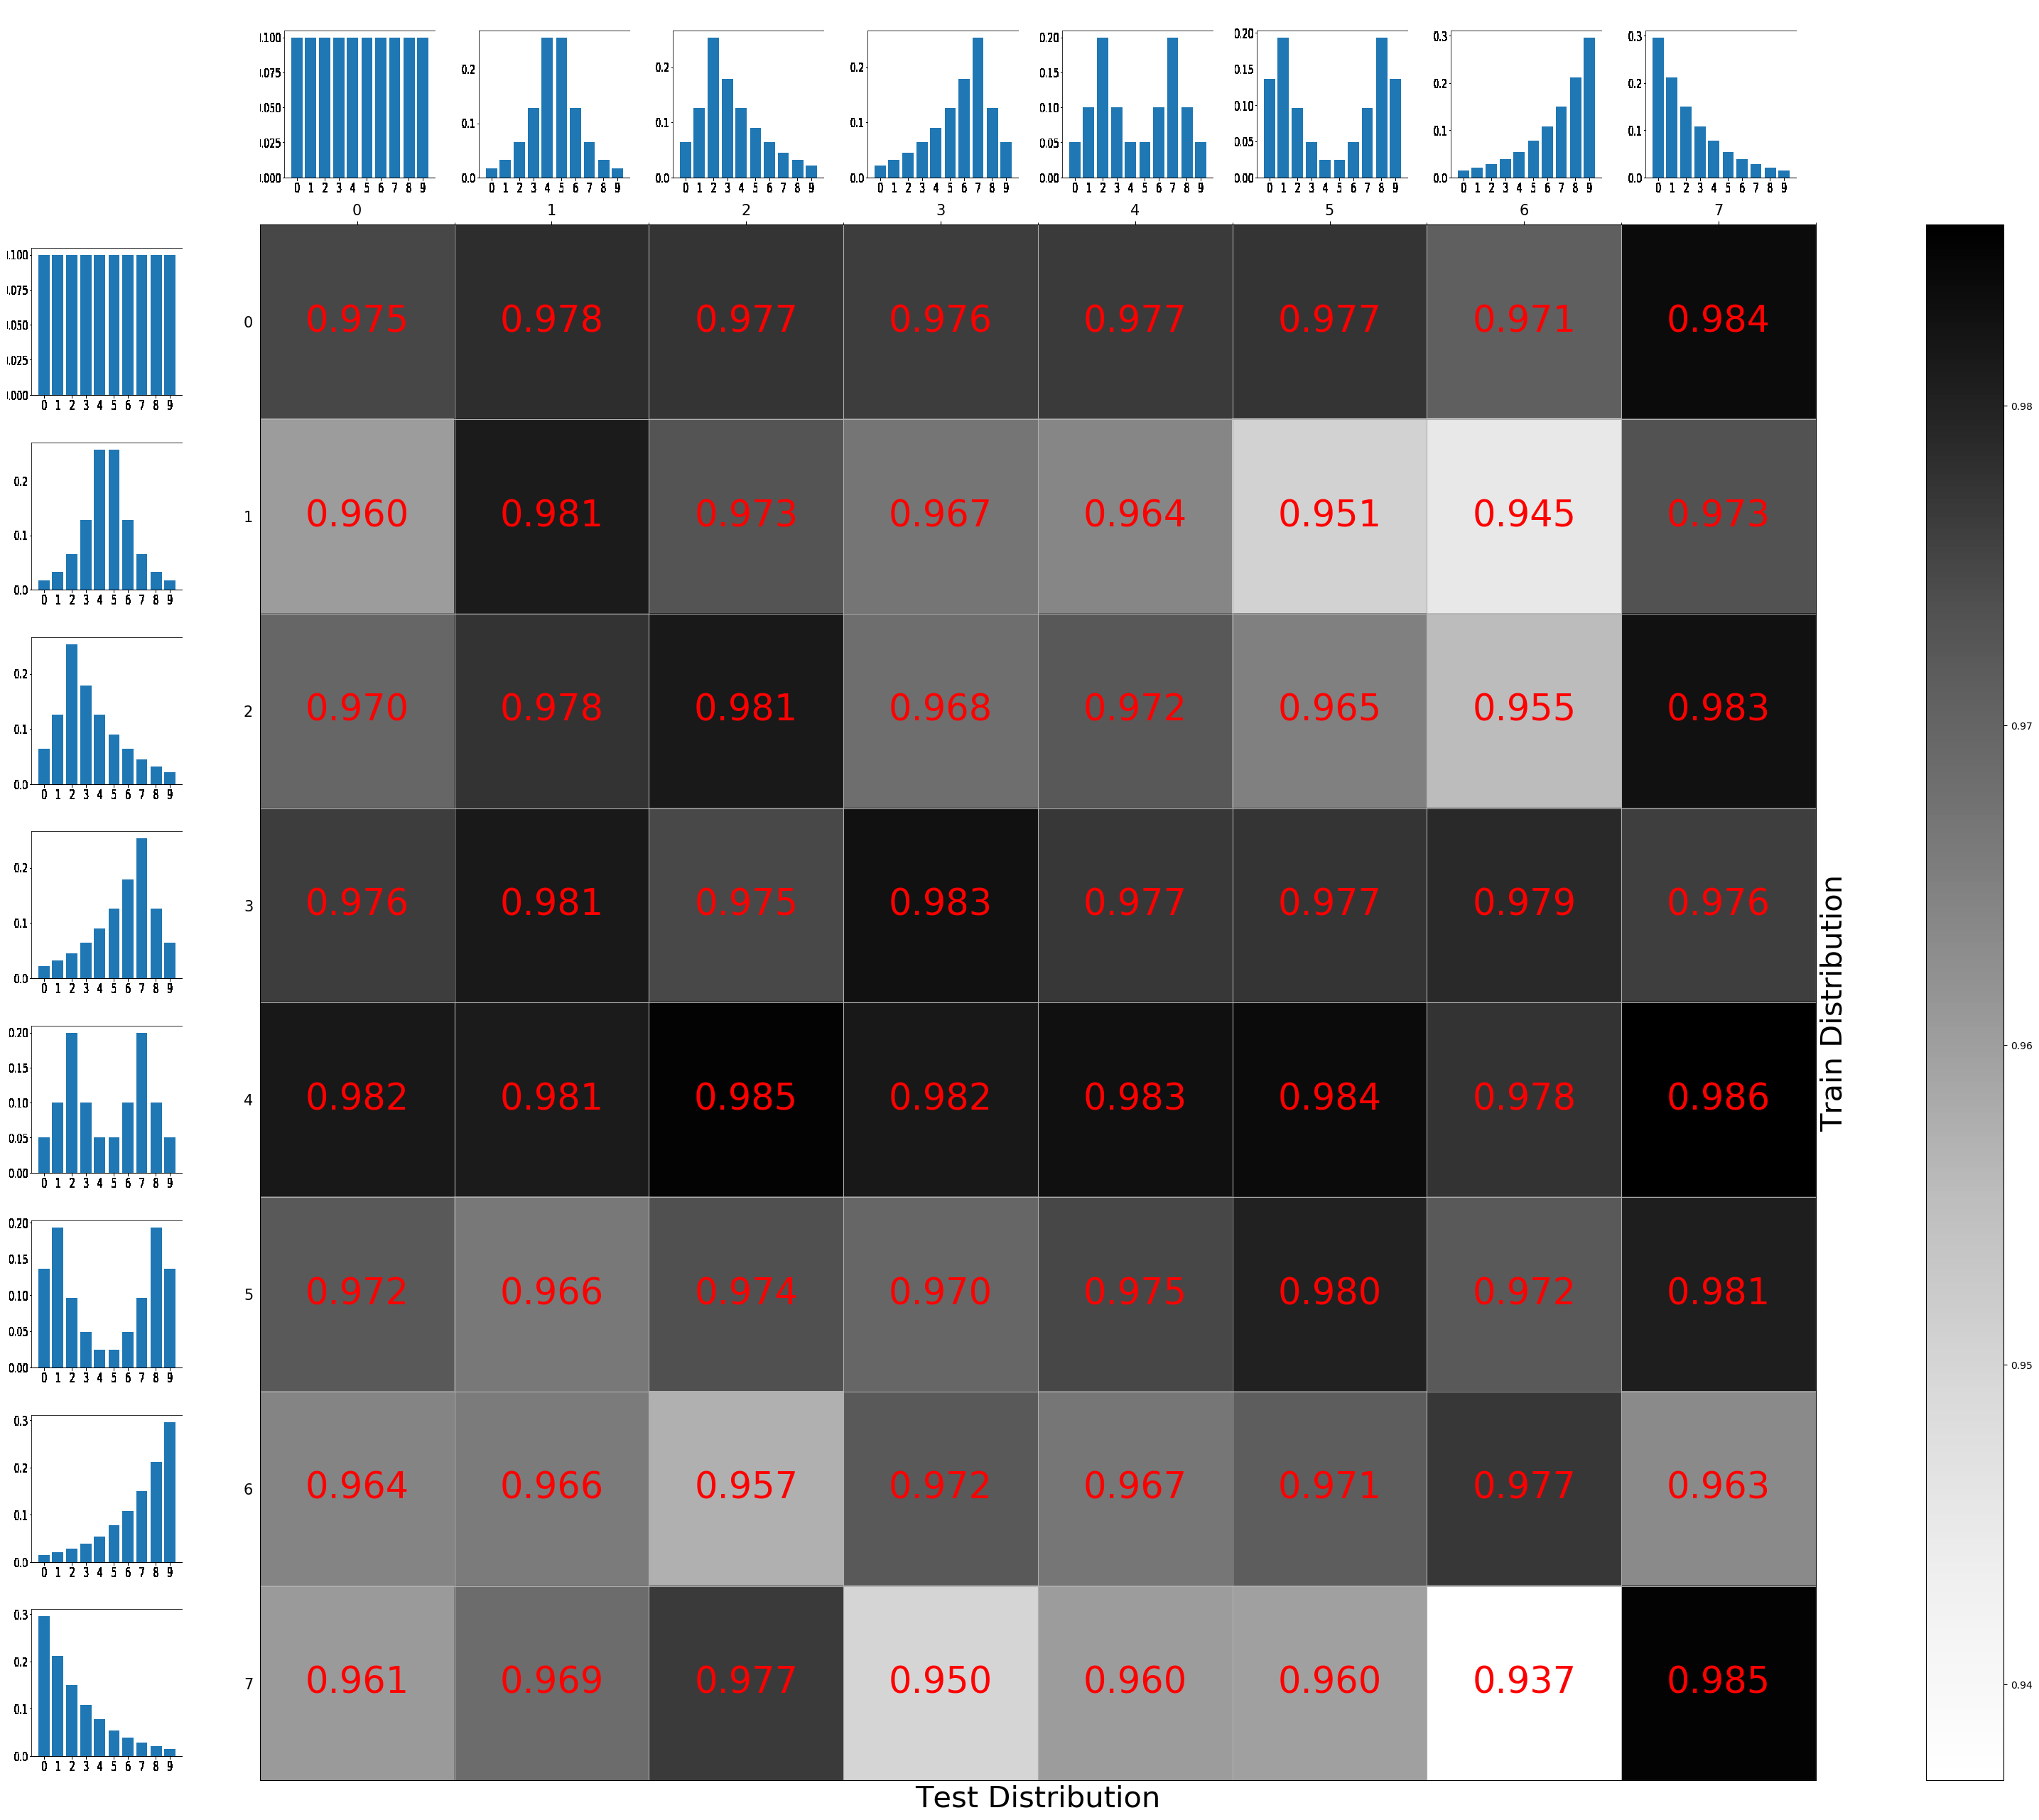

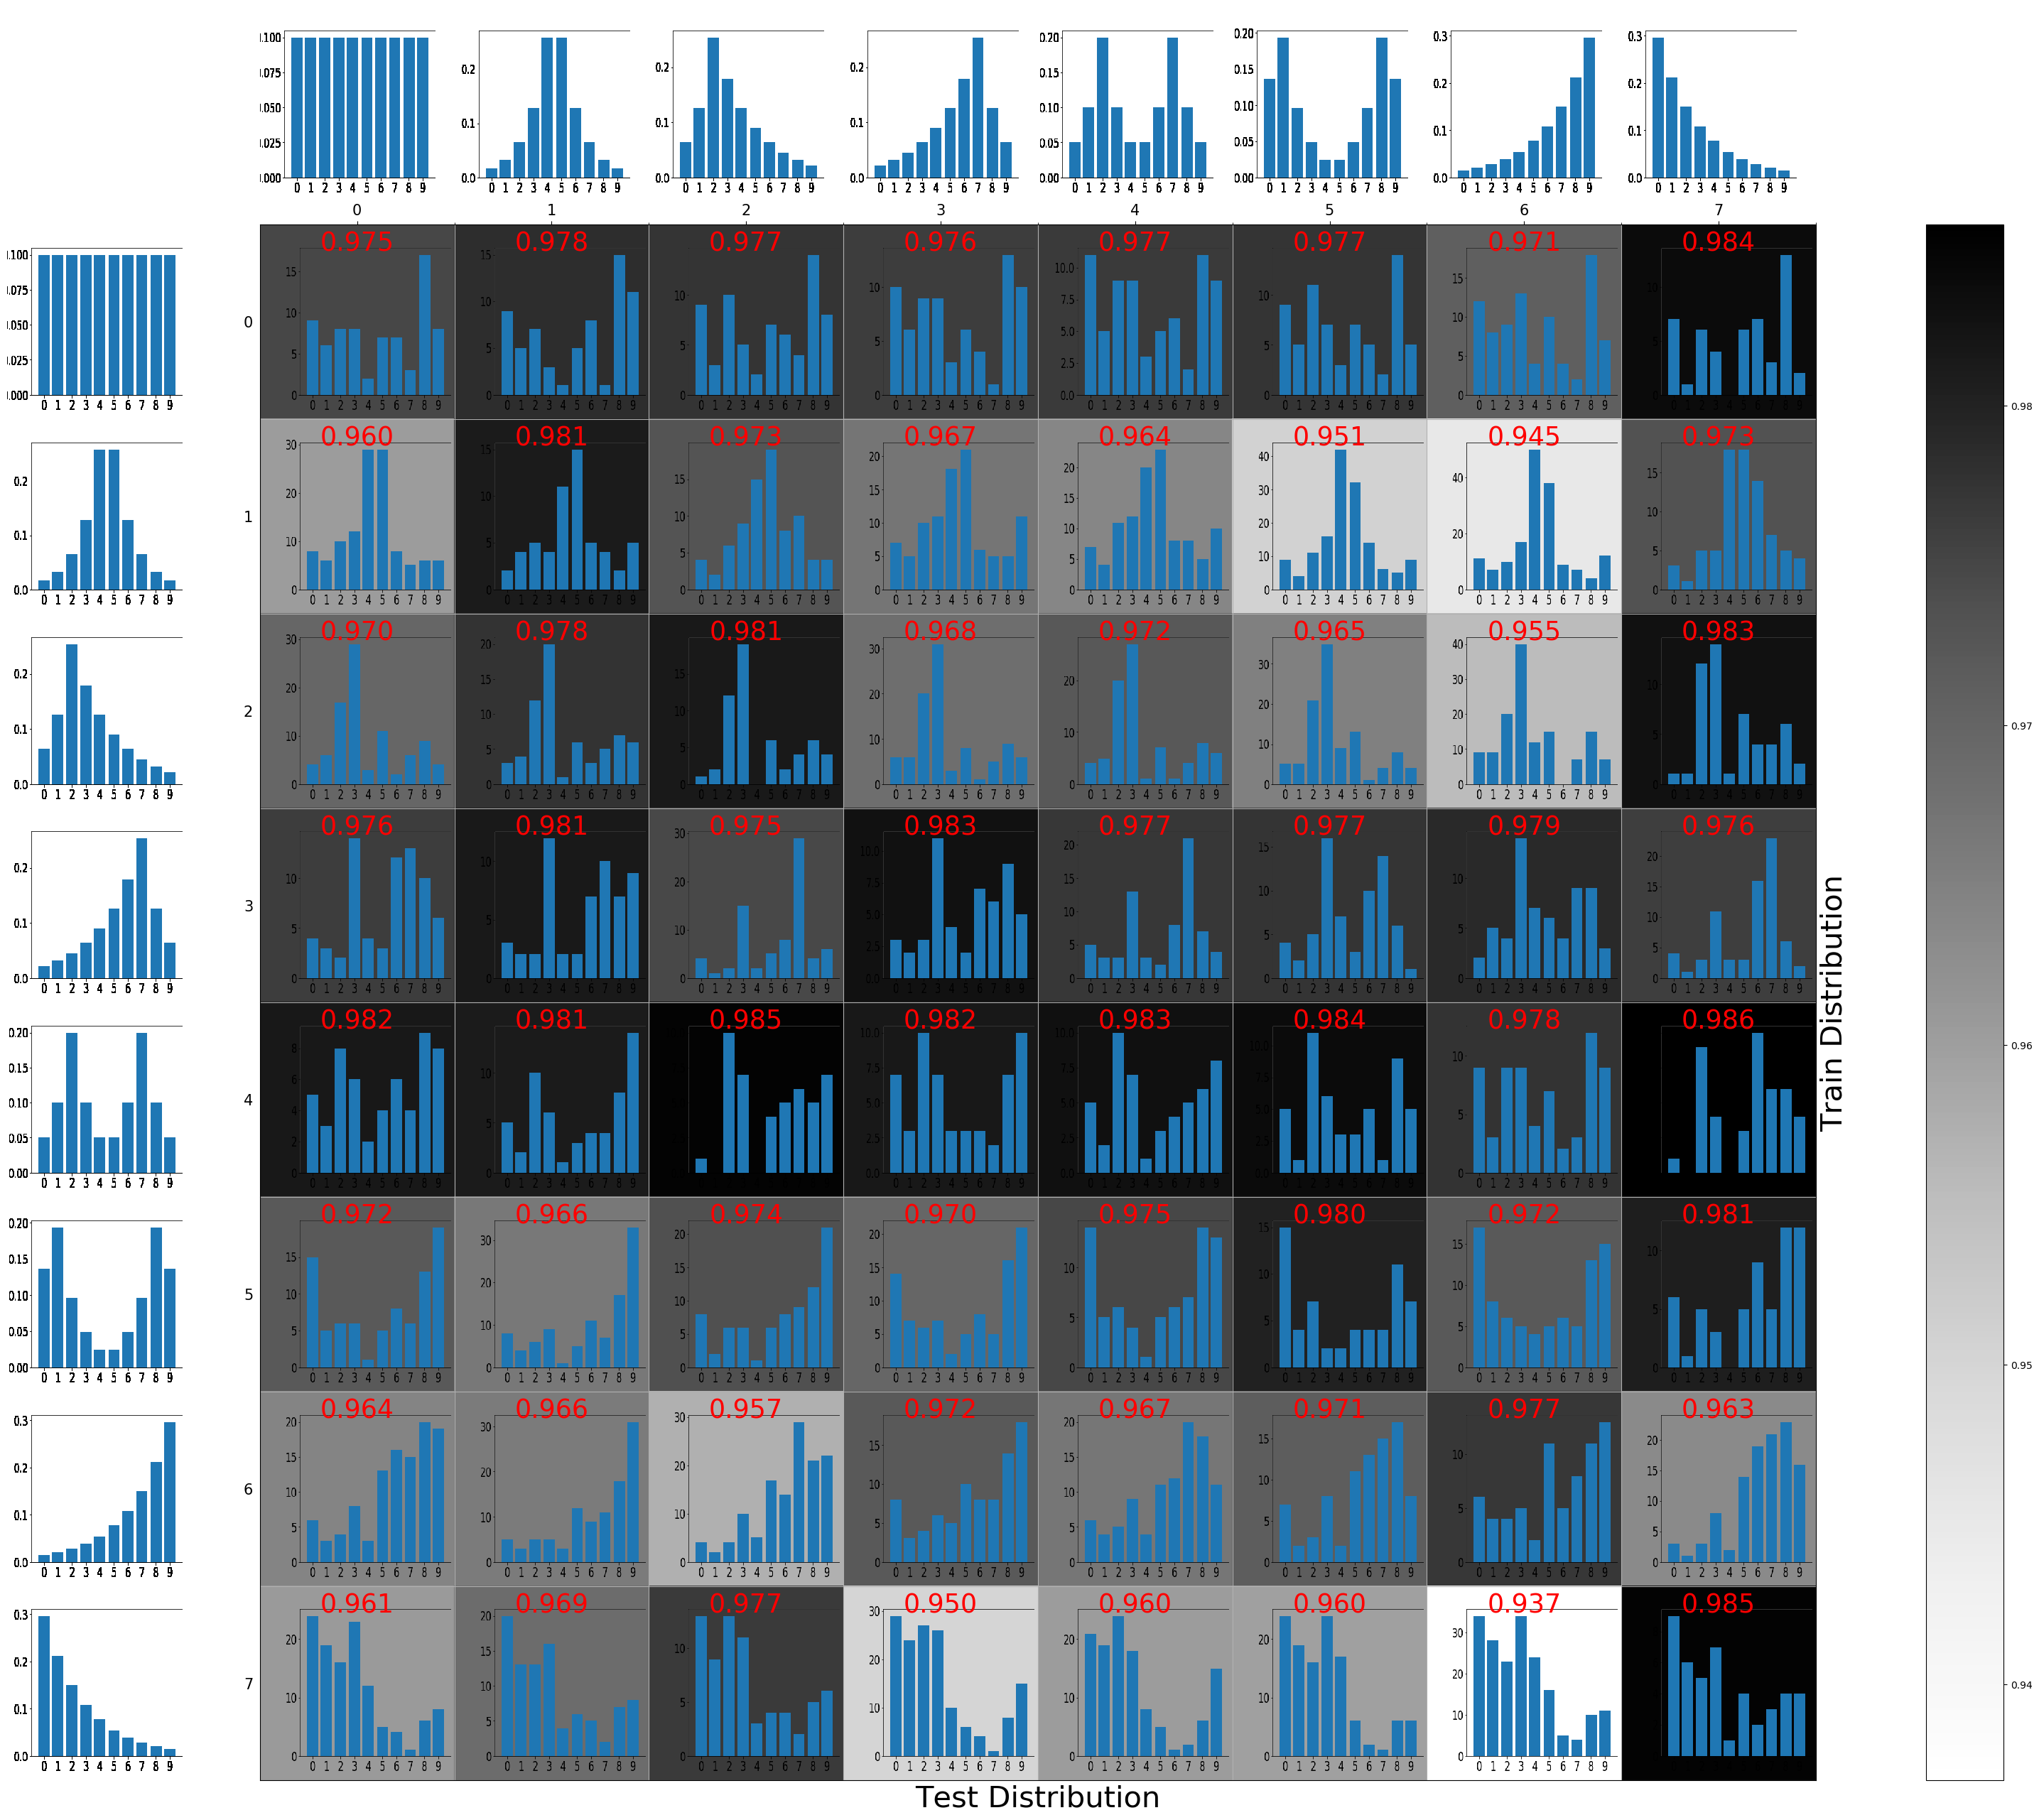

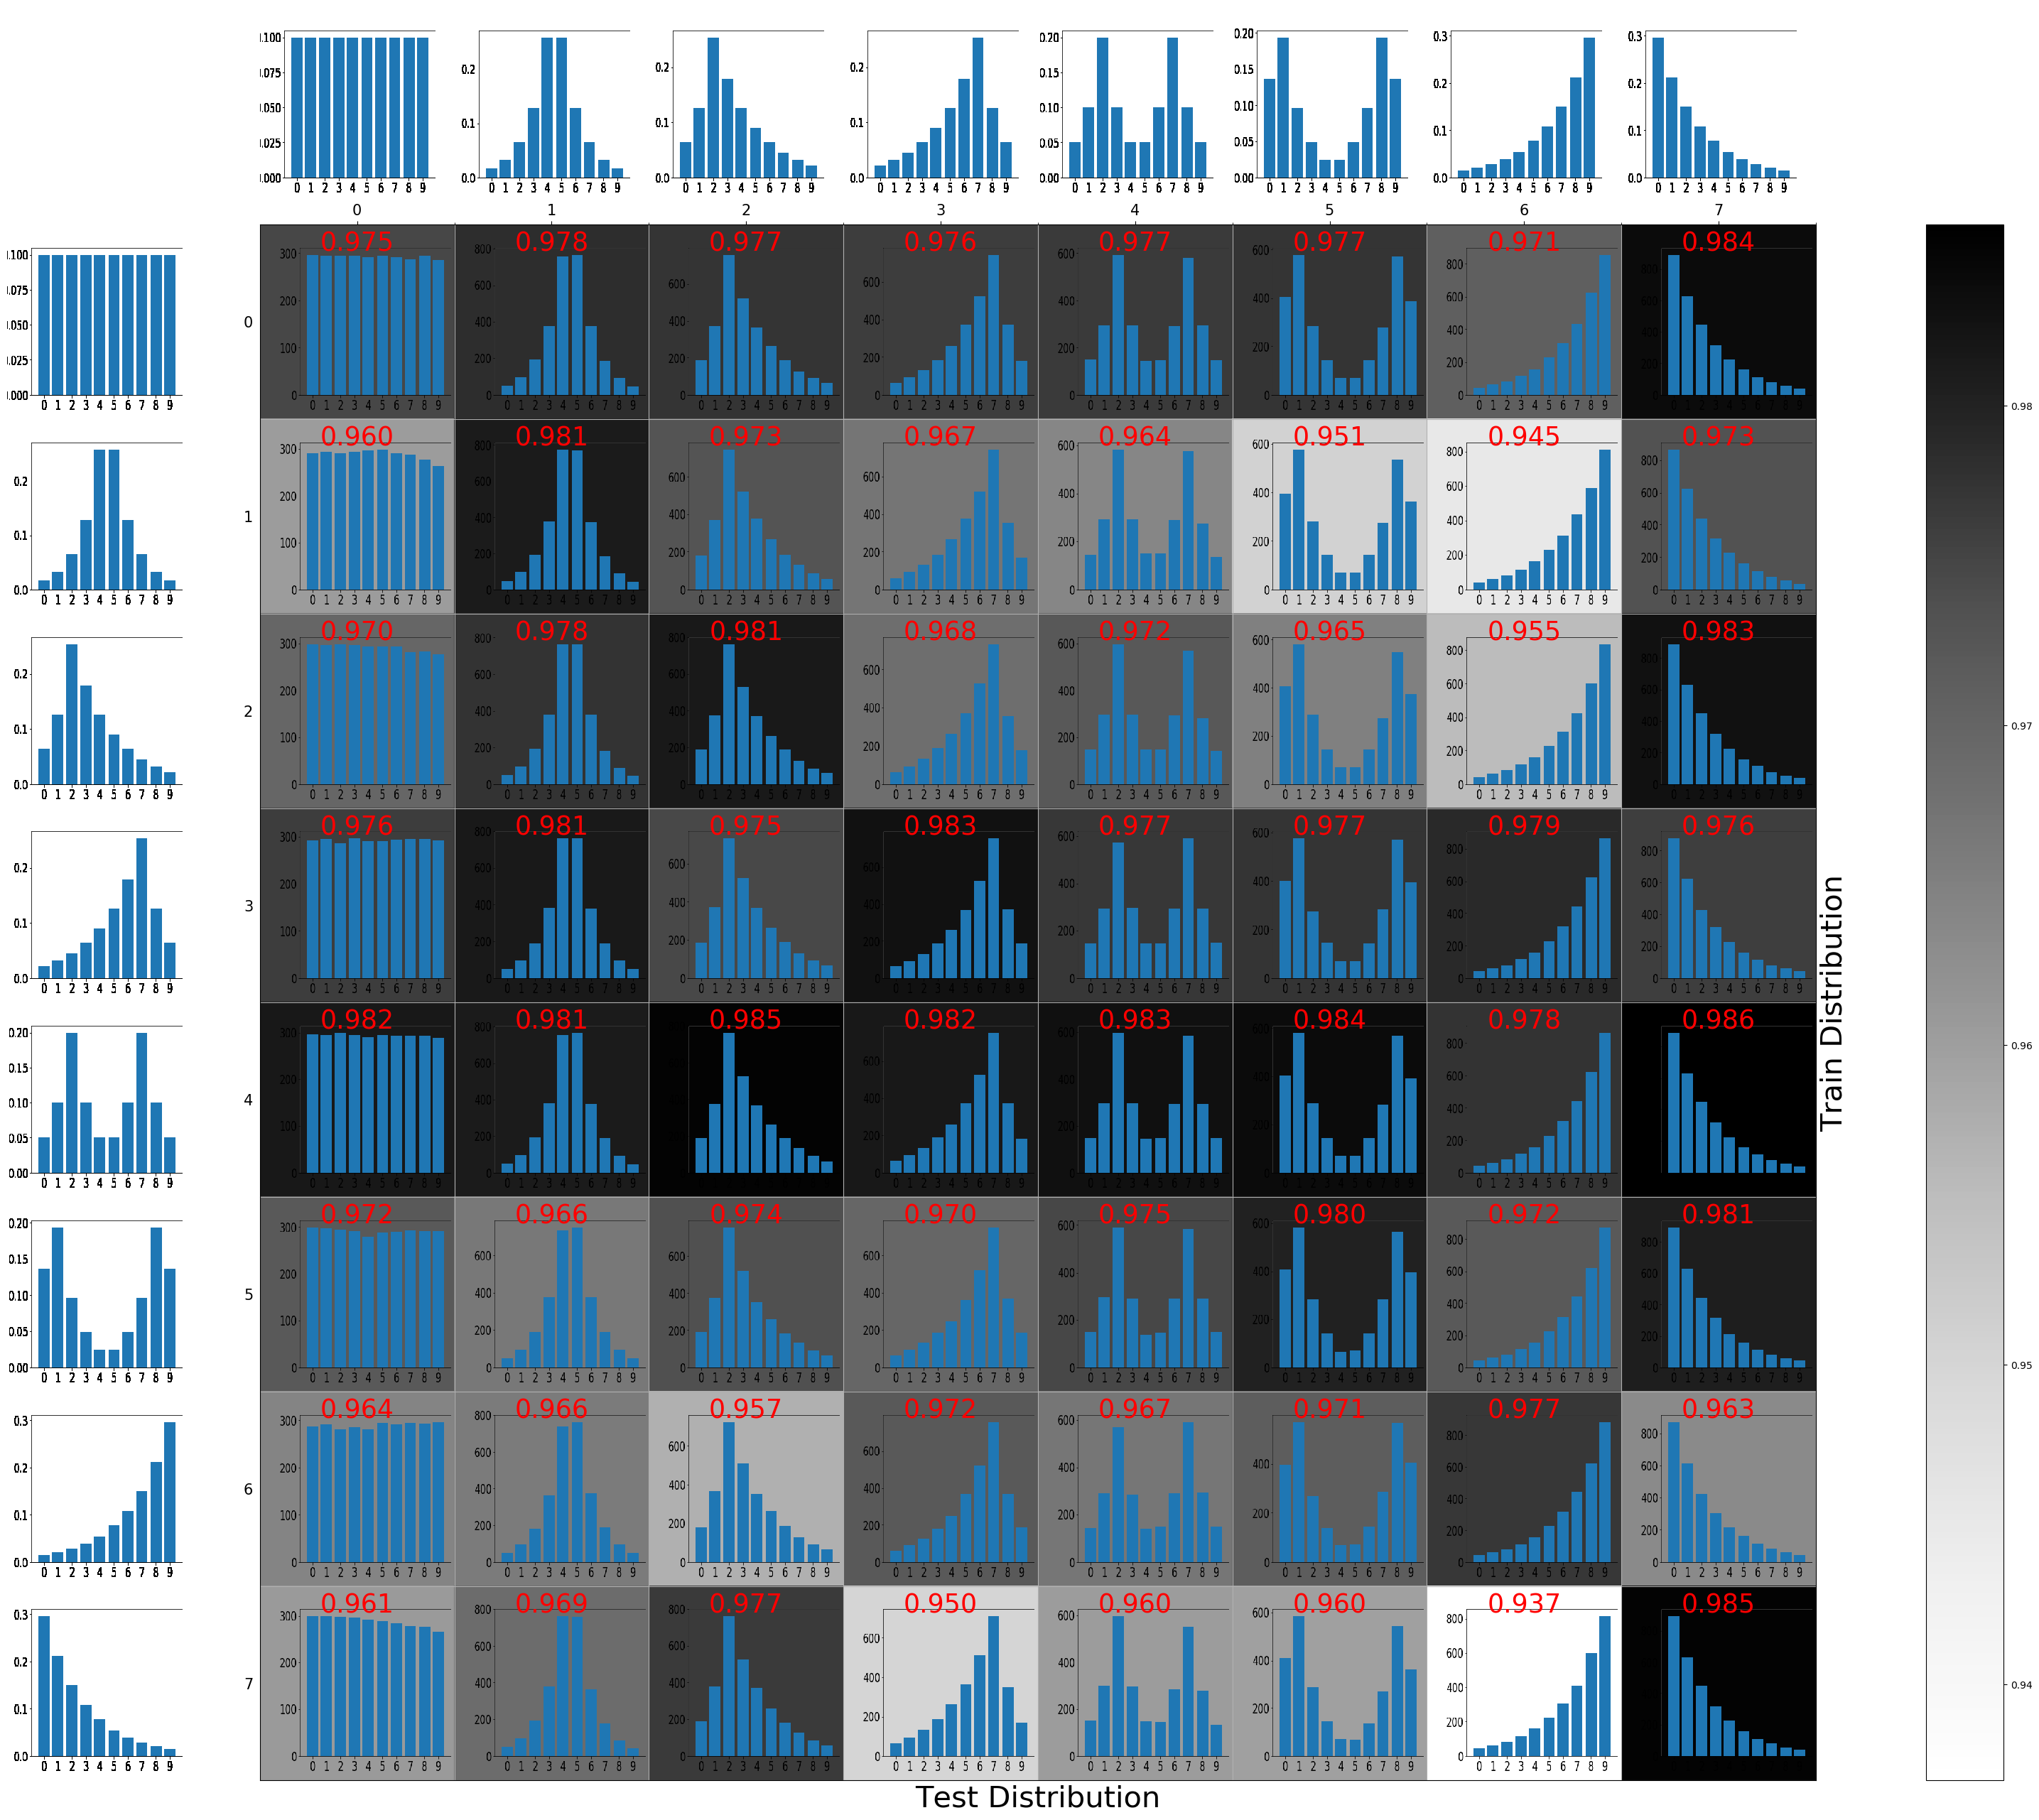

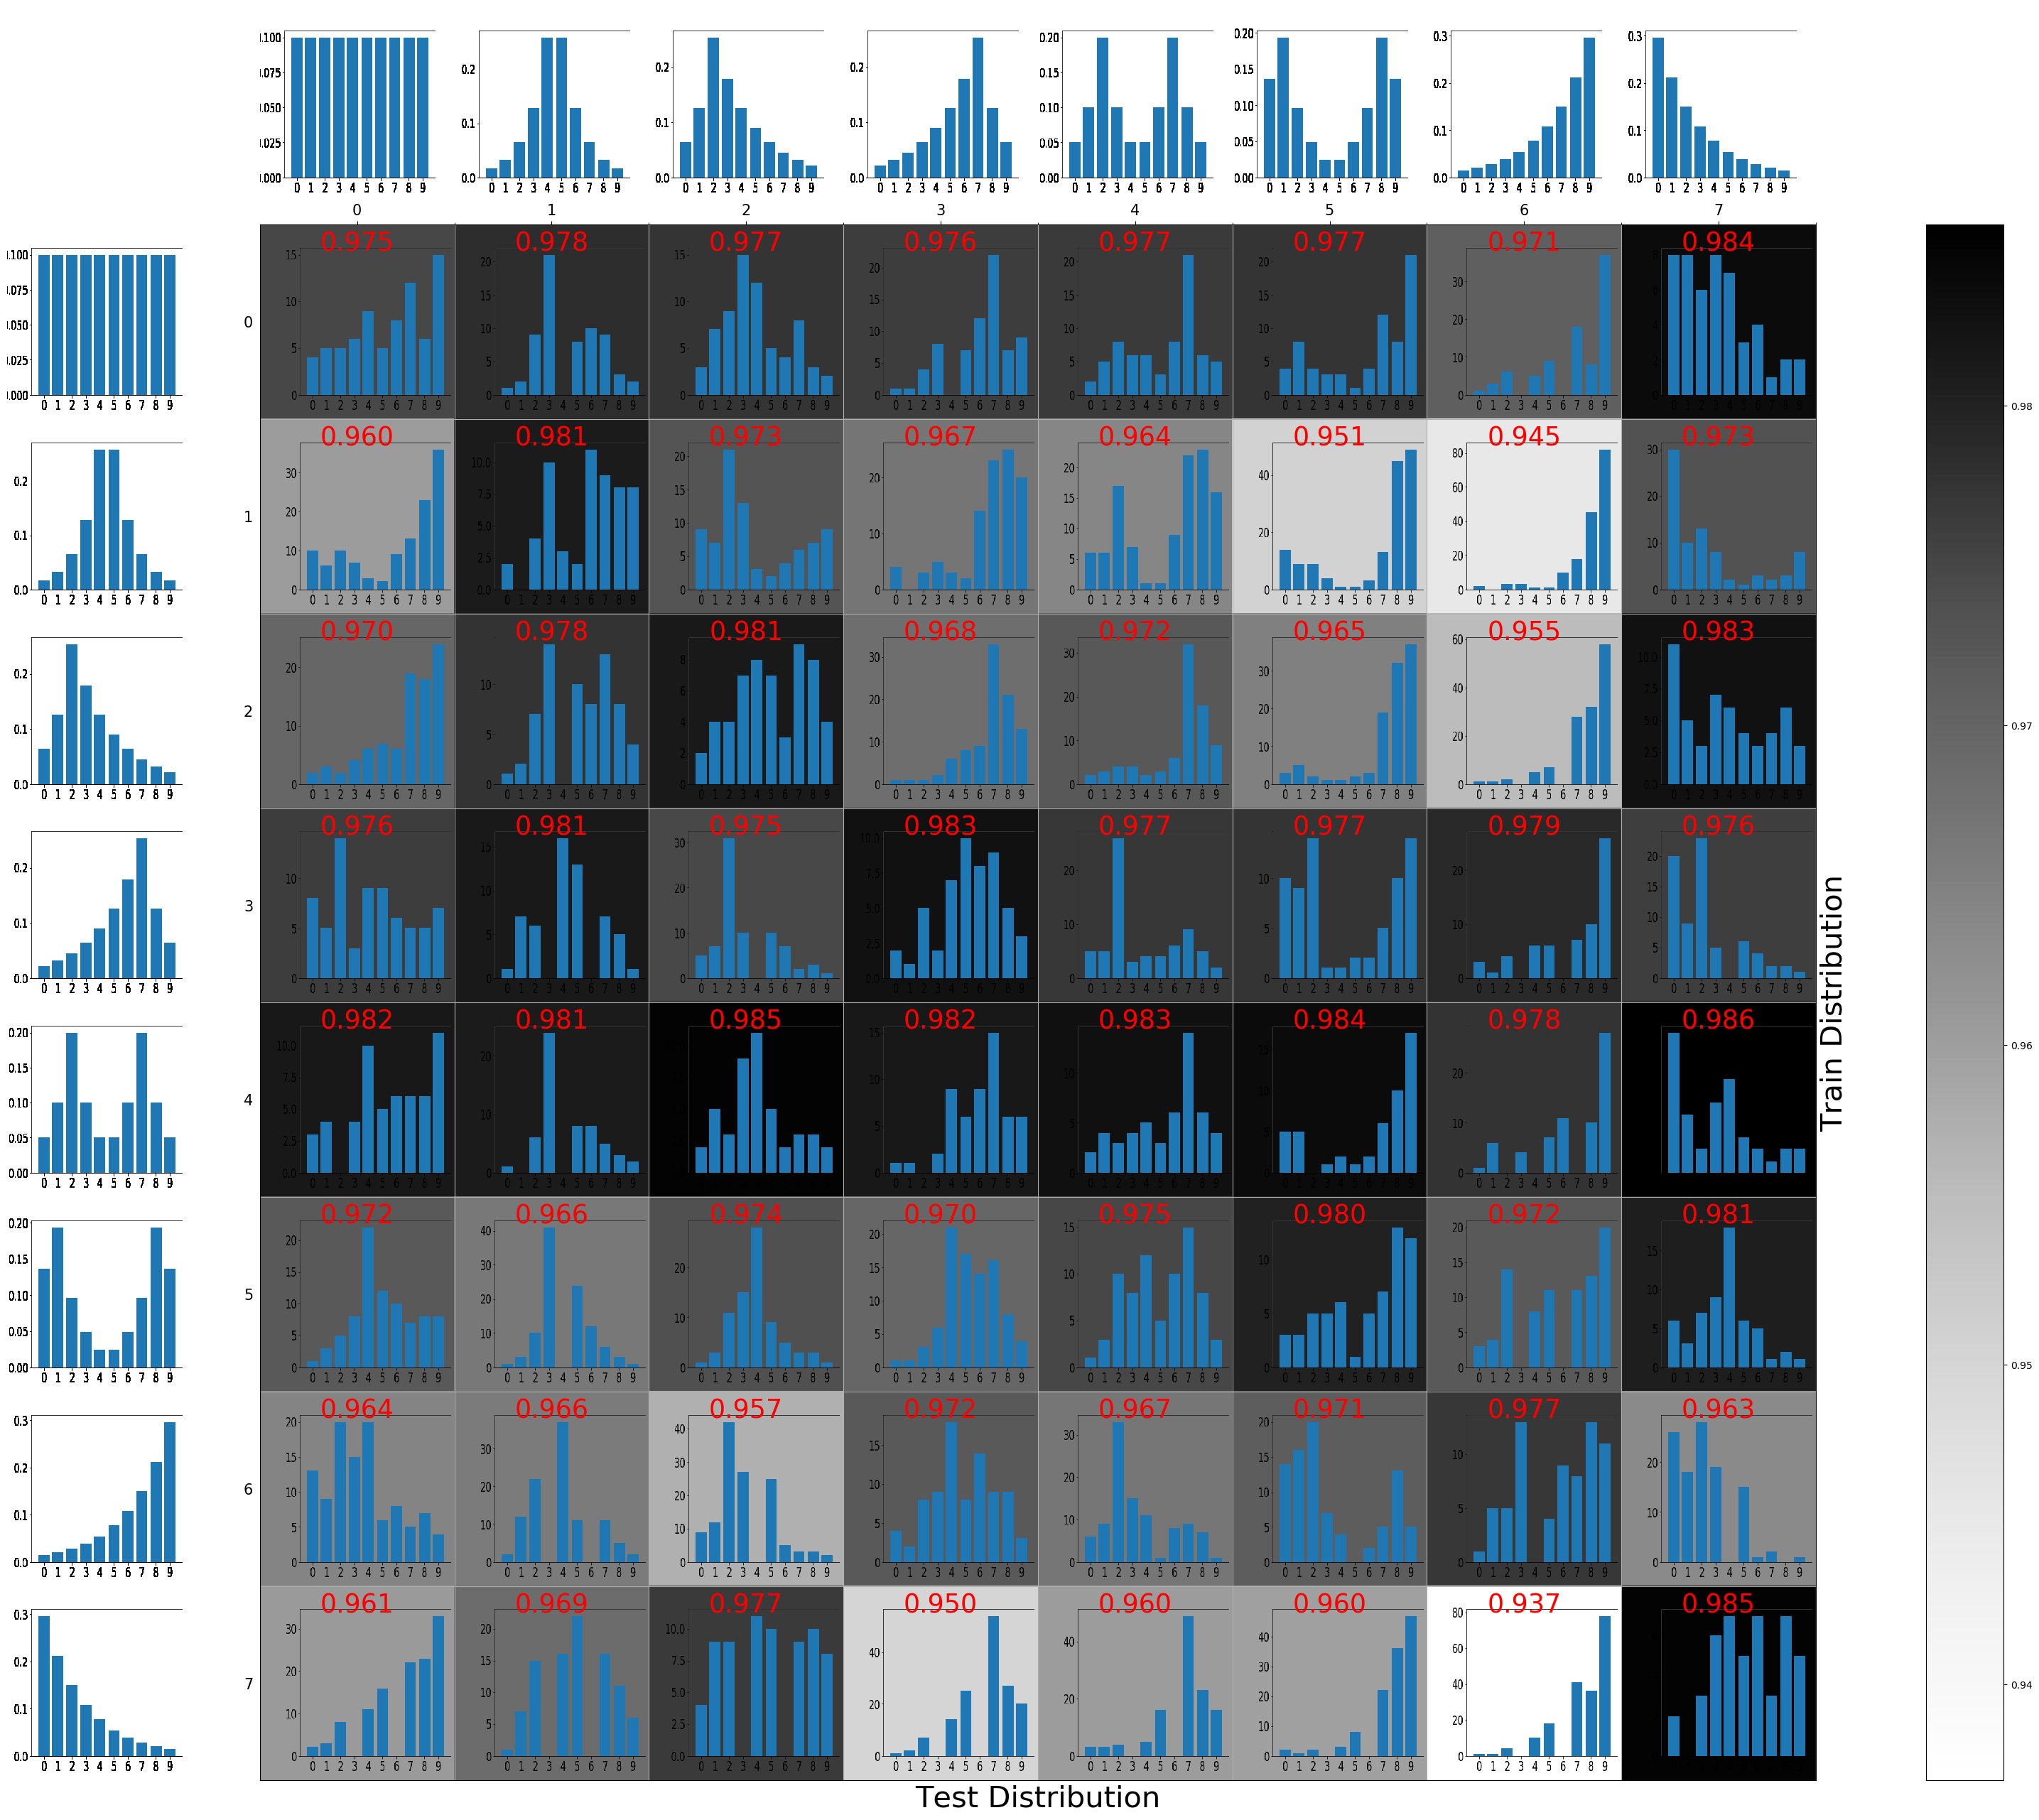

In [106]:
# restore and analyze the results from the above dictionary obtained by testing the models on all distributions
# work_dir = './results/PriorProbabilityShift_experiment_5/'
# filename = 'results_2018_03_18---20_56.dict.pickle'
# filename = 'results_2018_03_20---12_33.dict.pickle' # after 1 test dataset shuffles 
# filename = 'results_2018_03_20---12_42.dict.pickle' # after 2 test dataset shuffles
# filename = 'results_2018_03_20---12_55.dict.pickle' # after 3 test dataset shuffles


# work_dir = './results/PriorProbabilityShift_experiment_5_2/'
# filename = 'results_2018_03_20---14_28.dict.pickle'


# work_dir = './results/PriorProbabilityShift_experiment_5_3/'
# filename = 'results_2018_03_20---23_26.dict.pickle'

# work_dir = './results/PriorProbabilityShift_experiment_5_augmented/'
# filename = 'results_2018_03_21---11_54.dict.pickle'
# filename = 'results_2018_05_08---00_42.dict.pickle'

work_dir = './results/PriorProbabilityShift_experiment_5_10000samples/'
# filename = 'results_2018_05_07---11_38.dict.pickle'
filename = 'results_2018_05_08---01_03.dict.pickle'

# work_dir = './results/PriorProbabilityShift_experiment_5_5000samples/'
# filename = 'results_2018_05_07---12_17.dict.pickle'


filehandler = open(os.path.join(work_dir,filename), 'rb') 
restored_perf_dict = pickle.load(filehandler)
filehandler.close()
print('Results dictionary was succesfully restored from: {}'.format(filename))

# build a pandas dataframe from results dictionary
perf_df = pd.DataFrame(restored_perf_dict, columns=list(restored_perf_dict.keys()))
display(perf_df.describe())
display(perf_df)

# build and plot the accuracy comparison matrix
L = np.sqrt(len(perf_df)).astype(np.int32)
acc_matrix = np.array(perf_df['test_acc']).reshape((L, L))
distrs_used_for_training = perf_df['train_distr'][perf_df['idx_model'] == perf_df['idx_distr']]
acc_matrix_plt = Utils.plot_acc_matrix(train_distributions=distrs_used_for_training, acc_matrix=acc_matrix)
acc_matrix_plt.savefig(os.path.join(work_dir,filename + '.acc_matrix.png'))

# build and plot distributions corresponding to wrong predictions
wrong_predicted_distr_matrix = np.array(perf_df['wrong_predicted_distr']).reshape((L, L))
distrs_used_for_training = perf_df['train_distr'][perf_df['idx_model'] == perf_df['idx_distr']]
acc_matrix_plt = Utils.plot_acc_matrix(train_distributions=distrs_used_for_training, acc_matrix=acc_matrix, distr_matrix=wrong_predicted_distr_matrix)
acc_matrix_plt.savefig(os.path.join(work_dir,filename + '.wrong_predictions_distr_matrix.png'))

# build and plot distributions corresponding to correct predictions
wrong_predicted_distr_matrix = np.array(perf_df['correct_predicted_distr']).reshape((L, L))
distrs_used_for_training = perf_df['train_distr'][perf_df['idx_model'] == perf_df['idx_distr']]
acc_matrix_plt = Utils.plot_acc_matrix(train_distributions=distrs_used_for_training, acc_matrix=acc_matrix, distr_matrix=wrong_predicted_distr_matrix)
acc_matrix_plt.savefig(os.path.join(work_dir,filename + '.correct_predictions_distr_matrix.png'))

# build and plot distributions corresponding to wrong actual predictions
wrong_predicted_distr_matrix = np.array(perf_df['wrong_actual_distr']).reshape((L, L))
distrs_used_for_training = perf_df['train_distr'][perf_df['idx_model'] == perf_df['idx_distr']]
acc_matrix_plt = Utils.plot_acc_matrix(train_distributions=distrs_used_for_training, acc_matrix=acc_matrix, distr_matrix=wrong_predicted_distr_matrix)
acc_matrix_plt.savefig(os.path.join(work_dir,filename + '.wrong_actual_predictions_distr_matrix.png'))


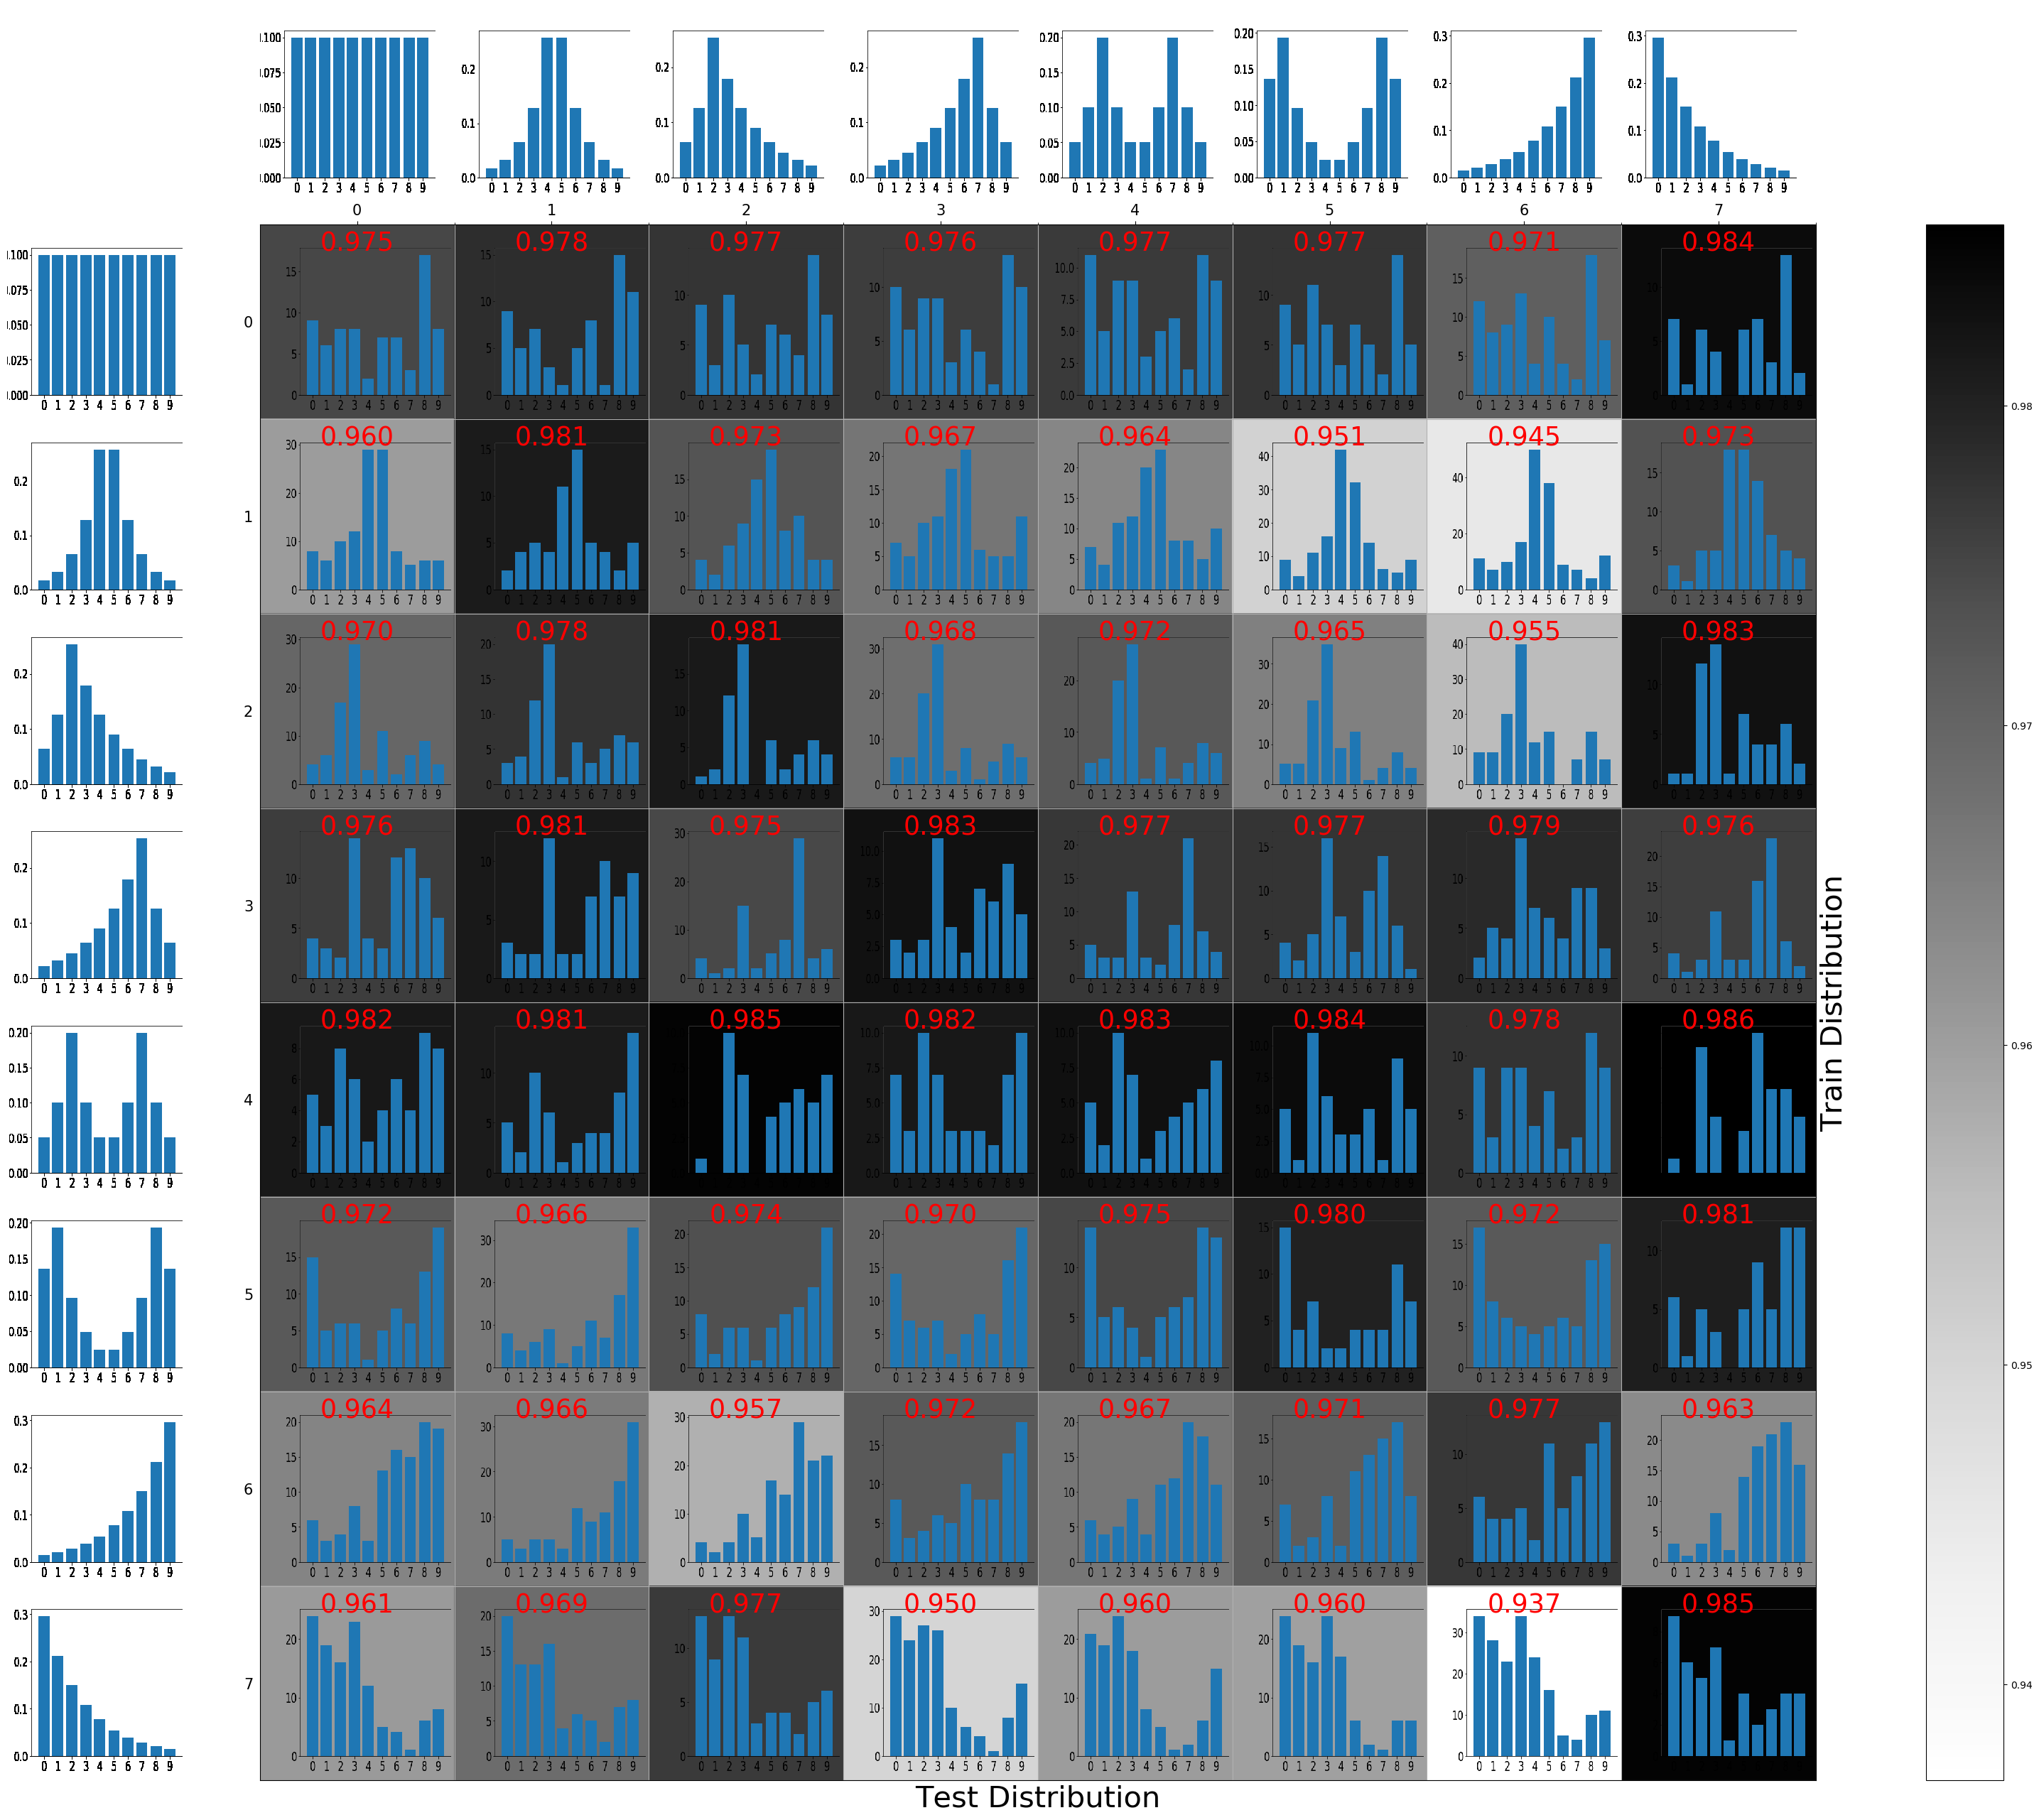

Results dictionary was succesfully restored from: ./results/PriorProbabilityShift_experiment_5/results_2018_03_18---20_56.dict.pickle


idx_model  idx_distr  test_loss  test_acc
count     64.000     64.000     64.000    64.000
mean       3.500      3.500      0.097     0.977
std        2.309      2.309      0.040     0.007
min        0.000      0.000      0.048     0.949
25%        1.750      1.750      0.073     0.973
50%        3.500      3.500      0.084     0.978
75%        5.250      5.250      0.110     0.982
max        7.000      7.000      0.285     0.988

idx_model  idx_distr  test_loss  test_acc  \
0           0          0      0.078     0.982   
1           0          1      0.067     0.986   
2           0          2      0.057     0.986   
3           0          3      0.084     0.981   
4           0          4      0.070     0.983   
5           0          5      0.071     0.981   
6           0          6      0.094     0.978   
7           0          7      0.048     0.988   
8           1          0      0.109     0.973   
9           1          1      0.059     0.987   
10          1          2      0.073     0.982   
11          1          3      0.084     0.979   
12          1          4      0.085     0.978   
13          1          5      0.124     0.968   
14          1          6      0.138     0.963   
15          1          7      0.076     0.982   
16          2          0      0.126     0.971   
17          2          1      0.081     0.982   
18          2          2      0.061     0.985   
19          2          3      0.130     0.968   
20          2          4      0.106     0.976   
21          2          5      0.140     0.966   
22          2          6      0.187     0.957   
23          2          7      0.050     0.988   
24          3          0      0.082     0.978   
25          3          1      0.068     0.983   
26          3          2      0.075     0.978   
27          3          3      0.076     0.981   
28          3          4      0.074     0.981   
29          3          5      0.074     0.980   
..        ...        ...        ...       ...   
34          4          2      0.068     0.980   
35          4          3      0.090     0.977   
36          4          4      0.076     0.980   
37          4          5      0.081     0.977   
38          4          6      0.111     0.973   
39          4          7      0.063     0.983   
40          5          0      0.106     0.973   
41          5          1      0.135     0.964   
42          5          2      0.084     0.976   
43          5          3      0.120     0.971   
44          5          4      0.084     0.978   
45          5          5      0.063     0.983   
46          5          6      0.101     0.974   
47          5          7      0.064     0.982   
48          6          0      0.110     0.974   
49          6          1      0.102     0.975   
50          6          2      0.116     0.972   
51          6          3      0.092     0.977   
52          6          4      0.101     0.975   
53          6          5      0.081     0.979   
54          6          6      0.063     0.981   
55          6          7      0.108     0.974   
56          7          0      0.162     0.969   
57          7          1      0.117     0.978   
58          7          2      0.080     0.983   
59          7          3      0.180     0.965   
60          7          4      0.150     0.970   
61          7          5      0.188     0.966   
62          7          6      0.285     0.949   
63          7          7      0.054     0.988   

                                        total_predict  \
0   [7.0, 3.0, 3.0, 6.0, 6.0, 7.0, 5.0, 9.0, 7.0, ...   
1   [5.0, 4.0, 4.0, 5.0, 5.0, 6.0, 5.0, 2.0, 6.0, ...   
2   [4.0, 2.0, 2.0, 4.0, 4.0, 5.0, 3.0, 7.0, 5.0, ...   
3   [7.0, 6.0, 6.0, 7.0, 7.0, 7.0, 6.0, 8.0, 7.0, ...   
4   [7.0, 3.0, 3.0, 7.0, 6.0, 7.0, 5.0, 8.0, 7.0, ...   
5   [8.0, 2.0, 2.0, 8.0, 7.0, 8.0, 5.0, 9.0, 8.0, ...   
6   [9.0, 7.0, 7.0, 8.0, 8.0, 9.0, 1.0, 9.0, 9.0, ...   
7   [3.0, 1.0, 1.0, 3.0, 2.0, 4.0, 2.0, 6.0, 4.0, ...   
8   [7.0, 3.0, 3.0, 6.0, 6.0, 7.0, 5.0, 9.0, 7.0, ...   
9   [5.0, 4.0, 4.0, 5.0, 5.0, 6.0, 5.0, 2.0, 6.0, ...   
10  [4.0, 2.0, 2.0, 4.0, 4.0, 5.0, 3.0, 7.0, 5.0, ...   
11  [7.0, 6.0, 6.0, 7.0, 7.0, 7.0, 6.0, 8.0, 7.0, ...   
12  [7.0, 3.0, 3.0, 7.0, 6.0, 7.0, 5.0, 8.0, 7.0, ...   
13  [8.0, 2.0, 2.0, 8.0, 7.0, 3.0, 5.0, 9.0, 8.0, ...   
14  [9.0, 7.0, 7.0, 8.0, 8.0, 9.0, 1.0, 9.0, 9.0, ...   
15  [3.0, 1.0, 1.0, 3.0, 2.0, 4.0, 2.0, 6.0, 4.0, ...

64
Results dictionary was succesfully restored from: ./results/PriorProbabilityShift_experiment_5/results_2018_03_20---12_33.dict.pickle


idx_model  idx_distr  test_loss  test_acc
count     64.000     64.000     64.000    64.000
mean       3.500      3.500      0.082     0.980
std        2.309      2.309      0.037     0.007
min        0.000      0.000      0.033     0.953
25%        1.750      1.750      0.059     0.977
50%        3.500      3.500      0.074     0.981
75%        5.250      5.250      0.096     0.985
max        7.000      7.000      0.256     0.991

idx_model  idx_distr  test_loss  test_acc  \
0           0          0      0.060     0.985   
1           0          1      0.055     0.989   
2           0          2      0.049     0.988   
3           0          3      0.064     0.983   
4           0          4      0.059     0.985   
5           0          5      0.052     0.985   
6           0          6      0.075     0.980   
7           0          7      0.033     0.991   
8           1          0      0.085     0.980   
9           1          1      0.047     0.990   
10          1          2      0.056     0.987   
11          1          3      0.072     0.982   
12          1          4      0.077     0.981   
13          1          5      0.095     0.974   
14          1          6      0.127     0.967   
15          1          7      0.058     0.985   
16          2          0      0.091     0.977   
17          2          1      0.066     0.984   
18          2          2      0.050     0.988   
19          2          3      0.116     0.973   
20          2          4      0.088     0.979   
21          2          5      0.101     0.973   
22          2          6      0.152     0.961   
23          2          7      0.034     0.991   
24          3          0      0.069     0.985   
25          3          1      0.055     0.988   
26          3          2      0.071     0.982   
27          3          3      0.052     0.988   
28          3          4      0.060     0.985   
29          3          5      0.065     0.983   
..        ...        ...        ...       ...   
34          4          2      0.065     0.984   
35          4          3      0.077     0.980   
36          4          4      0.069     0.983   
37          4          5      0.075     0.981   
38          4          6      0.097     0.977   
39          4          7      0.051     0.986   
40          5          0      0.089     0.978   
41          5          1      0.121     0.969   
42          5          2      0.083     0.978   
43          5          3      0.100     0.975   
44          5          4      0.075     0.980   
45          5          5      0.058     0.984   
46          5          6      0.096     0.977   
47          5          7      0.059     0.983   
48          6          0      0.081     0.979   
49          6          1      0.097     0.978   
50          6          2      0.099     0.976   
51          6          3      0.071     0.981   
52          6          4      0.082     0.978   
53          6          5      0.073     0.979   
54          6          6      0.064     0.983   
55          6          7      0.099     0.976   
56          7          0      0.136     0.973   
57          7          1      0.101     0.981   
58          7          2      0.071     0.984   
59          7          3      0.188     0.965   
60          7          4      0.149     0.973   
61          7          5      0.138     0.971   
62          7          6      0.256     0.953   
63          7          7      0.045     0.990   

                                        total_predict  \
0   [8.0, 2.0, 9.0, 3.0, 0.0, 2.0, 3.0, 6.0, 0.0, ...   
1   [7.0, 3.0, 8.0, 4.0, 1.0, 3.0, 4.0, 5.0, 2.0, ...   
2   [6.0, 2.0, 8.0, 2.0, 0.0, 2.0, 2.0, 3.0, 1.0, ...   
3   [8.0, 4.0, 9.0, 5.0, 1.0, 4.0, 6.0, 7.0, 2.0, ...   
4   [8.0, 2.0, 9.0, 3.0, 0.0, 2.0, 3.0, 6.0, 1.0, ...   
5   [9.0, 1.0, 9.0, 2.0, 0.0, 1.0, 2.0, 7.0, 0.0, ...   
6   [9.0, 5.0, 9.0, 7.0, 1.0, 5.0, 7.0, 8.0, 3.0, ...   
7   [5.0, 0.0, 8.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, ...   
8   [8.0, 2.0, 9.0, 3.0, 0.0, 2.0, 3.0, 6.0, 0.0, ...   
9   [7.0, 3.0, 8.0, 4.0, 1.0, 3.0, 4.0, 5.0, 2.0, ...   
10  [6.0, 2.0, 8.0, 2.0, 0.0, 2.0, 2.0, 3.0, 1.0, ...   
11  [8.0, 4.0, 9.0, 5.0, 1.0, 4.0, 6.0, 7.0, 2.0, ...   
12  [8.0, 2.0, 9.0, 3.0, 0.0, 2.0, 3.0, 6.0, 1.0, ...   
13  [9.0, 1.0, 9.0, 2.0, 0.0, 1.0, 2.0, 7.0, 0.0, ...   
14  [9.0, 5.0, 9.0, 7.0, 1.0, 5.0, 7.0, 8.0, 3.0, ...   
15  [5.0, 0.0, 8.0, 1.0, 0.0, 0.0, 1.0, 2.0, 0.0, ...

64
Results dictionary was succesfully restored from: ./results/PriorProbabilityShift_experiment_5/results_2018_03_20---12_42.dict.pickle


idx_model  idx_distr  test_loss  test_acc
count     64.000     64.000     64.000    64.000
mean       3.500      3.500      0.078     0.981
std        2.309      2.309      0.033     0.006
min        0.000      0.000      0.033     0.958
25%        1.750      1.750      0.057     0.978
50%        3.500      3.500      0.069     0.983
75%        5.250      5.250      0.087     0.985
max        7.000      7.000      0.229     0.990

idx_model  idx_distr  test_loss  test_acc  \
0           0          0      0.060     0.986   
1           0          1      0.058     0.987   
2           0          2      0.041     0.989   
3           0          3      0.062     0.985   
4           0          4      0.065     0.985   
5           0          5      0.049     0.985   
6           0          6      0.073     0.982   
7           0          7      0.033     0.990   
8           1          0      0.086     0.978   
9           1          1      0.046     0.990   
10          1          2      0.057     0.984   
11          1          3      0.065     0.983   
12          1          4      0.083     0.980   
13          1          5      0.094     0.973   
14          1          6      0.121     0.969   
15          1          7      0.061     0.984   
16          2          0      0.083     0.978   
17          2          1      0.061     0.987   
18          2          2      0.048     0.988   
19          2          3      0.089     0.978   
20          2          4      0.084     0.978   
21          2          5      0.086     0.975   
22          2          6      0.133     0.966   
23          2          7      0.037     0.990   
24          3          0      0.067     0.985   
25          3          1      0.055     0.987   
26          3          2      0.062     0.982   
27          3          3      0.052     0.989   
28          3          4      0.073     0.982   
29          3          5      0.056     0.986   
..        ...        ...        ...       ...   
34          4          2      0.056     0.983   
35          4          3      0.067     0.983   
36          4          4      0.066     0.982   
37          4          5      0.058     0.983   
38          4          6      0.085     0.978   
39          4          7      0.047     0.986   
40          5          0      0.089     0.978   
41          5          1      0.117     0.968   
42          5          2      0.070     0.979   
43          5          3      0.087     0.979   
44          5          4      0.080     0.981   
45          5          5      0.056     0.984   
46          5          6      0.088     0.978   
47          5          7      0.057     0.984   
48          6          0      0.082     0.981   
49          6          1      0.091     0.979   
50          6          2      0.097     0.975   
51          6          3      0.060     0.984   
52          6          4      0.083     0.980   
53          6          5      0.060     0.985   
54          6          6      0.049     0.988   
55          6          7      0.089     0.977   
56          7          0      0.135     0.977   
57          7          1      0.105     0.983   
58          7          2      0.076     0.986   
59          7          3      0.164     0.974   
60          7          4      0.146     0.975   
61          7          5      0.128     0.977   
62          7          6      0.229     0.958   
63          7          7      0.051     0.990   

                                        total_predict  \
0   [5.0, 0.0, 1.0, 9.0, 4.0, 9.0, 5.0, 9.0, 1.0, ...   
1   [5.0, 2.0, 3.0, 7.0, 4.0, 8.0, 5.0, 9.0, 3.0, ...   
2   [3.0, 0.0, 1.0, 7.0, 3.0, 8.0, 3.0, 9.0, 1.0, ...   
3   [7.0, 2.0, 4.0, 8.0, 6.0, 9.0, 7.0, 9.0, 4.0, ...   
4   [6.0, 1.0, 2.0, 8.0, 4.0, 9.0, 6.0, 9.0, 2.0, ...   
5   [6.0, 0.0, 1.0, 9.0, 3.0, 9.0, 6.0, 9.0, 1.0, ...   
6   [8.0, 2.0, 5.0, 9.0, 7.0, 9.0, 8.0, 9.0, 5.0, ...   
7   [2.0, 0.0, 0.0, 6.0, 1.0, 9.0, 2.0, 9.0, 0.0, ...   
8   [5.0, 0.0, 1.0, 4.0, 4.0, 9.0, 5.0, 9.0, 1.0, ...   
9   [5.0, 2.0, 3.0, 7.0, 4.0, 8.0, 5.0, 9.0, 3.0, ...   
10  [3.0, 0.0, 1.0, 7.0, 3.0, 8.0, 3.0, 9.0, 1.0, ...   
11  [7.0, 2.0, 4.0, 8.0, 6.0, 9.0, 7.0, 9.0, 4.0, ...   
12  [6.0, 1.0, 2.0, 8.0, 4.0, 9.0, 6.0, 9.0, 2.0, ...   
13  [6.0, 0.0, 1.0, 9.0, 3.0, 9.0, 6.0, 9.0, 1.0, ...   
14  [8.0, 2.0, 5.0, 9.0, 7.0, 9.0, 8.0, 9.0, 5.0, ...   
15  [2.0, 0.0, 2.0, 6.0, 1.0, 8.0, 2.0, 9.0, 0.0, ...

64
Results dictionary was succesfully restored from: ./results/PriorProbabilityShift_experiment_5/results_2018_03_20---12_55.dict.pickle


idx_model  idx_distr  test_loss  test_acc
count     64.000     64.000     64.000    64.000
mean       3.500      3.500      0.074     0.982
std        2.309      2.309      0.030     0.006
min        0.000      0.000      0.038     0.960
25%        1.750      1.750      0.057     0.979
50%        3.500      3.500      0.064     0.983
75%        5.250      5.250      0.082     0.986
max        7.000      7.000      0.218     0.992

idx_model  idx_distr  test_loss  test_acc  \
0           0          0      0.057     0.985   
1           0          1      0.052     0.989   
2           0          2      0.057     0.986   
3           0          3      0.058     0.984   
4           0          4      0.063     0.983   
5           0          5      0.055     0.985   
6           0          6      0.074     0.981   
7           0          7      0.042     0.990   
8           1          0      0.066     0.983   
9           1          1      0.038     0.991   
10          1          2      0.055     0.987   
11          1          3      0.058     0.986   
12          1          4      0.069     0.983   
13          1          5      0.080     0.979   
14          1          6      0.125     0.968   
15          1          7      0.058     0.986   
16          2          0      0.077     0.981   
17          2          1      0.060     0.986   
18          2          2      0.058     0.986   
19          2          3      0.093     0.977   
20          2          4      0.084     0.979   
21          2          5      0.100     0.976   
22          2          6      0.148     0.963   
23          2          7      0.044     0.989   
24          3          0      0.056     0.987   
25          3          1      0.055     0.988   
26          3          2      0.074     0.983   
27          3          3      0.038     0.991   
28          3          4      0.055     0.986   
29          3          5      0.057     0.986   
..        ...        ...        ...       ...   
34          4          2      0.064     0.981   
35          4          3      0.057     0.981   
36          4          4      0.060     0.983   
37          4          5      0.068     0.983   
38          4          6      0.090     0.976   
39          4          7      0.051     0.986   
40          5          0      0.065     0.981   
41          5          1      0.116     0.970   
42          5          2      0.076     0.978   
43          5          3      0.073     0.979   
44          5          4      0.058     0.983   
45          5          5      0.050     0.987   
46          5          6      0.076     0.979   
47          5          7      0.050     0.986   
48          6          0      0.080     0.983   
49          6          1      0.086     0.981   
50          6          2      0.103     0.977   
51          6          3      0.064     0.986   
52          6          4      0.082     0.982   
53          6          5      0.068     0.986   
54          6          6      0.062     0.987   
55          6          7      0.098     0.980   
56          7          0      0.096     0.979   
57          7          1      0.087     0.984   
58          7          2      0.068     0.987   
59          7          3      0.143     0.973   
60          7          4      0.124     0.977   
61          7          5      0.116     0.978   
62          7          6      0.218     0.960   
63          7          7      0.046     0.992   

                                        total_predict  \
0   [5.0, 8.0, 7.0, 1.0, 2.0, 4.0, 8.0, 3.0, 8.0, ...   
1   [5.0, 6.0, 6.0, 3.0, 4.0, 4.0, 6.0, 4.0, 7.0, ...   
2   [3.0, 5.0, 5.0, 1.0, 2.0, 2.0, 6.0, 2.0, 6.0, ...   
3   [6.0, 7.0, 7.0, 3.0, 5.0, 6.0, 8.0, 5.0, 8.0, ...   
4   [5.0, 7.0, 7.0, 2.0, 2.0, 3.0, 8.0, 3.0, 8.0, ...   
5   [6.0, 8.0, 8.0, 1.0, 1.0, 3.0, 8.0, 2.0, 9.0, ...   
6   [8.0, 9.0, 9.0, 5.0, 6.0, 7.0, 9.0, 7.0, 9.0, ...   
7   [2.0, 4.0, 4.0, 0.0, 0.0, 1.0, 5.0, 1.0, 5.0, ...   
8   [5.0, 8.0, 7.0, 1.0, 2.0, 4.0, 8.0, 3.0, 8.0, ...   
9   [5.0, 6.0, 6.0, 3.0, 4.0, 4.0, 6.0, 4.0, 7.0, ...   
10  [3.0, 5.0, 5.0, 1.0, 2.0, 2.0, 6.0, 2.0, 6.0, ...   
11  [6.0, 7.0, 7.0, 3.0, 5.0, 6.0, 8.0, 5.0, 8.0, ...   
12  [5.0, 7.0, 7.0, 2.0, 2.0, 3.0, 8.0, 3.0, 8.0, ...   
13  [6.0, 8.0, 8.0, 1.0, 1.0, 3.0, 4.0, 2.0, 9.0, ...   
14  [8.0, 9.0, 9.0, 5.0, 6.0, 7.0, 4.0, 7.0, 9.0, ...   
15  [2.0, 4.0, 4.0, 0.0, 0.0, 1.0, 5.0, 1.0, 5.0, ...

64


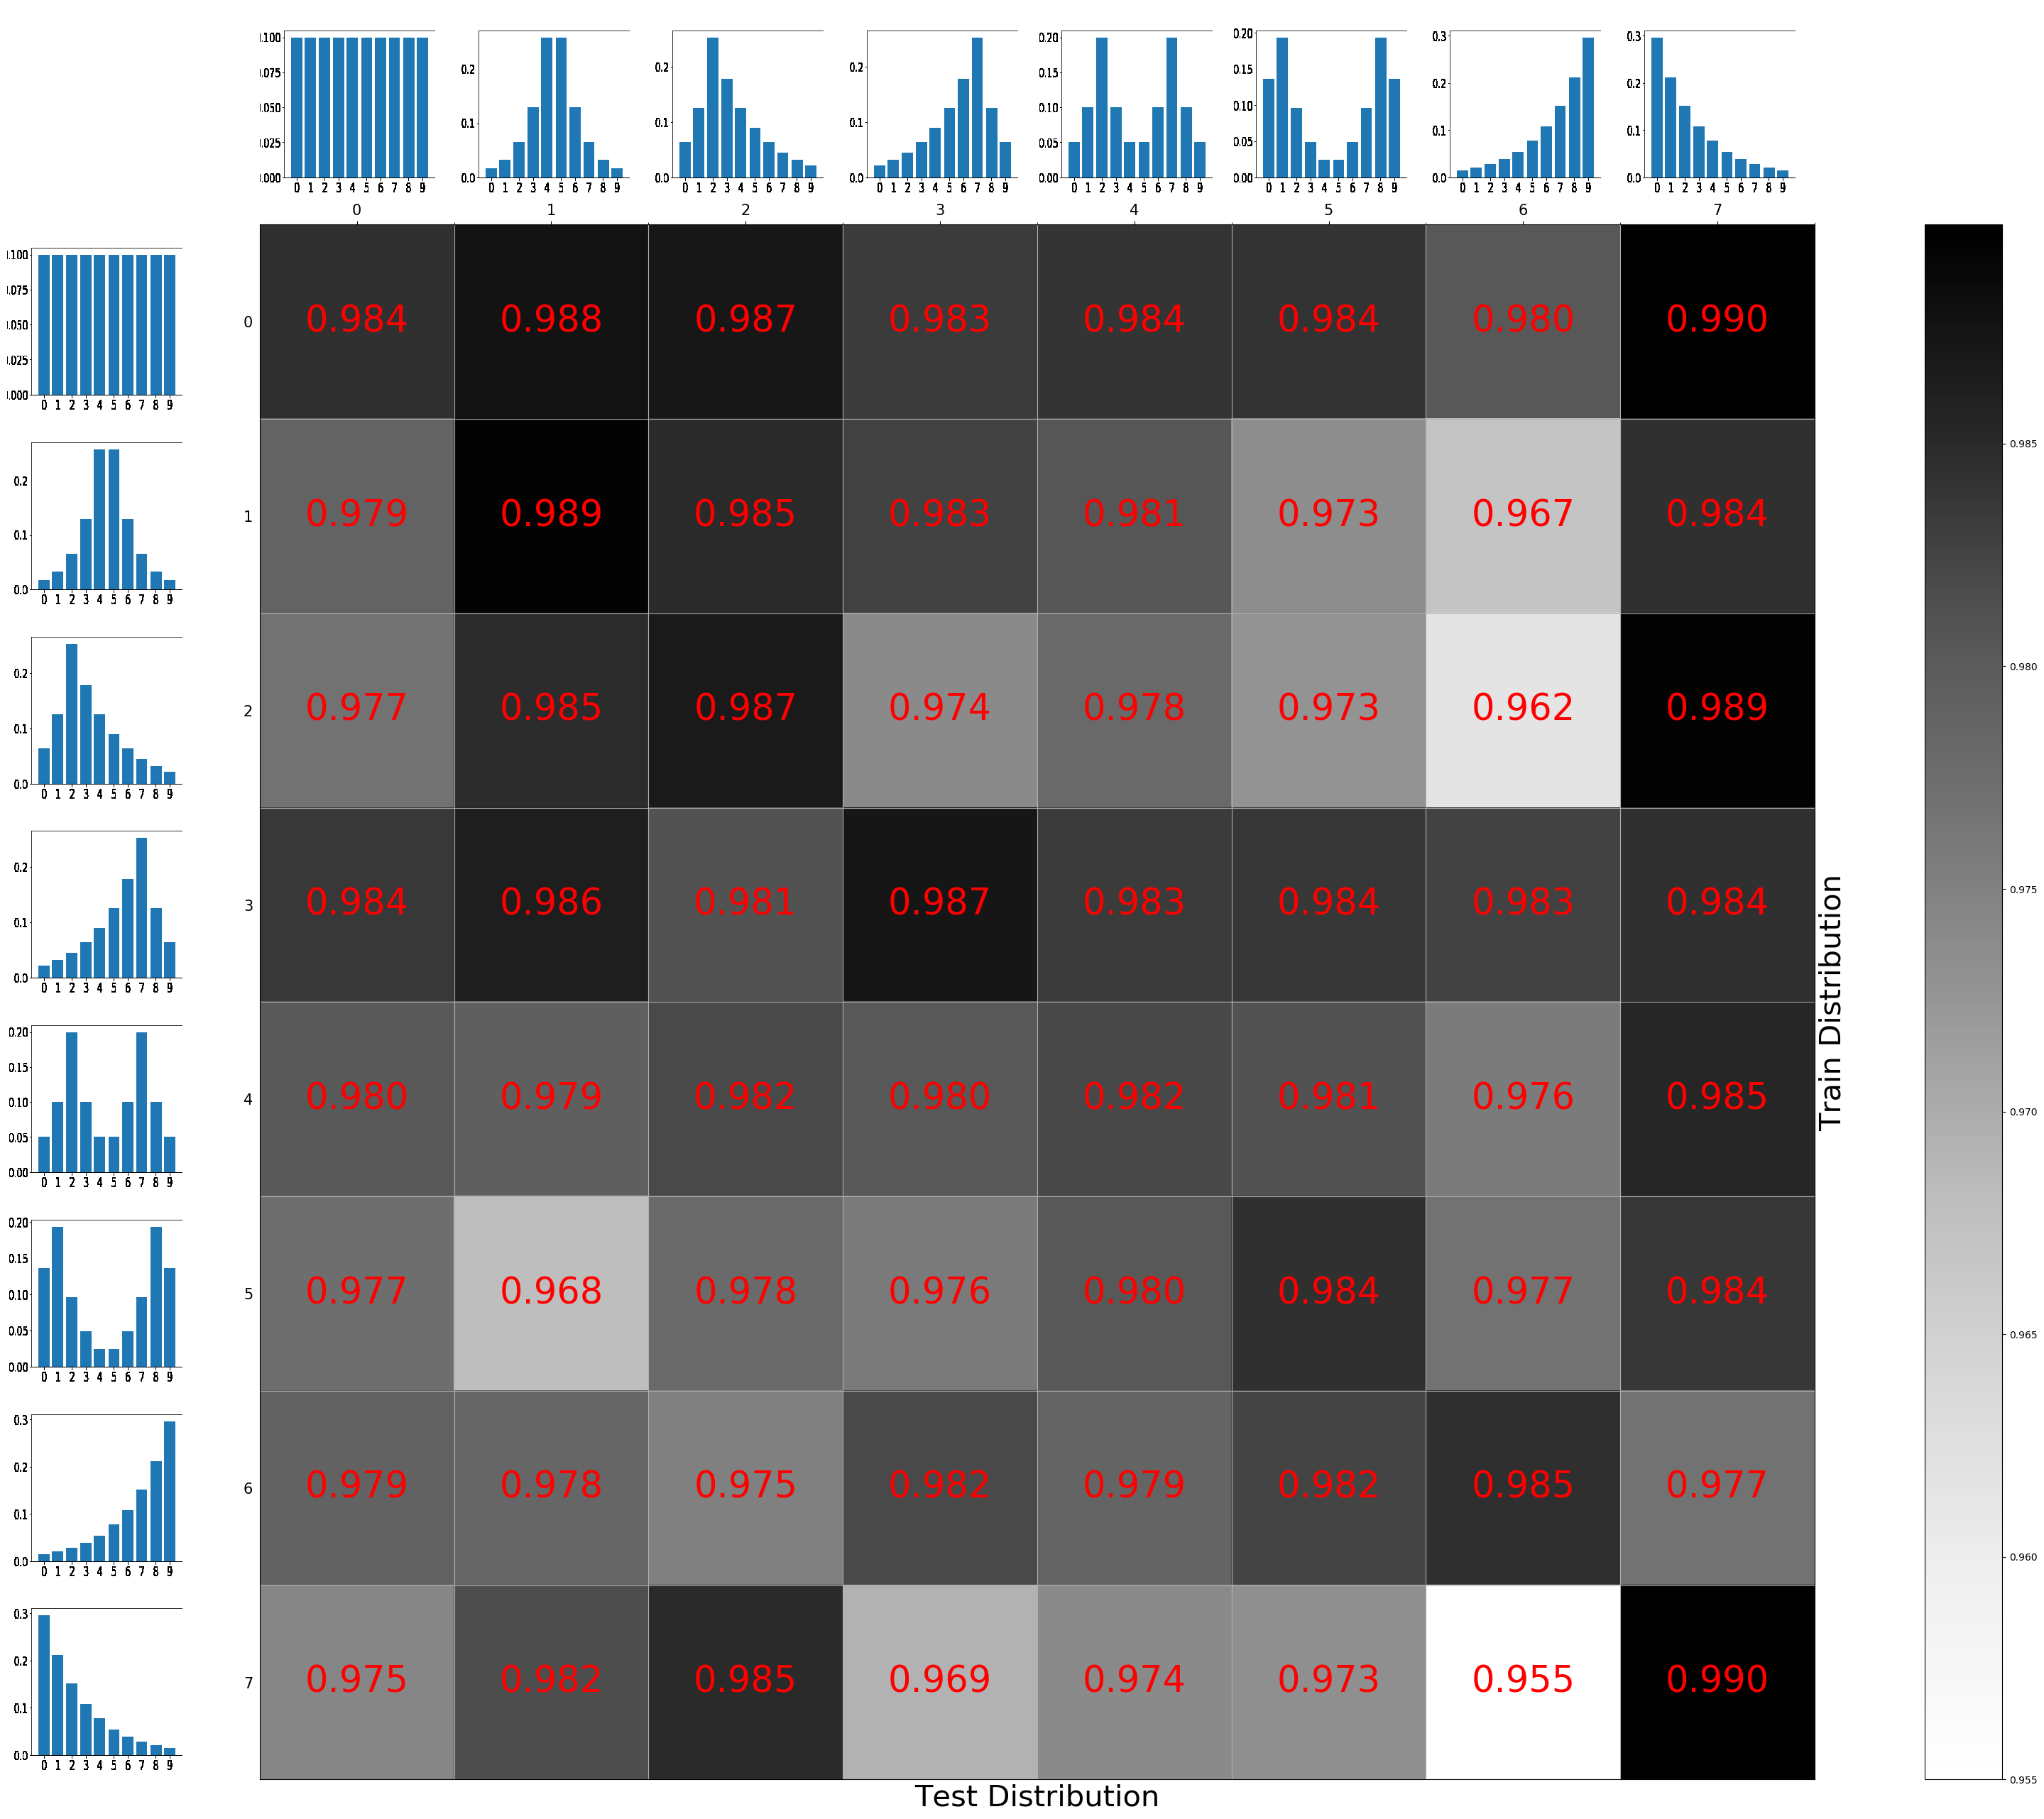

In [48]:
# Analyze average acc matrix
work_dir = './results/PriorProbabilityShift_experiment_5/'
dict_file_list = get_all_files_from_dir_ending_with(work_dir, "dict.pickle")
acc_matrices_list = [] # in order to make a comparison between results
plot = False
for dict_file in dict_file_list:
    # restore the results dictionary
    filename = os.path.join(work_dir, dict_file)
    filehandler = open(filename, 'rb') 
    restored_perf_dict = pickle.load(filehandler)
    filehandler.close()
    print('Results dictionary was succesfully restored from: {}'.format(filename))
    
    # build a pandas dataframe from results dictionary
    perf_df = pd.DataFrame(restored_perf_dict, columns=list(restored_perf_dict.keys()))
    display(perf_df.describe())
    display(perf_df)
    
    # build a matrix with all test accuracies and plot it
    print(len(perf_df))
    L = np.sqrt(len(perf_df)).astype(np.int32)
    acc_matrix = np.array(perf_df['test_acc']).reshape((L, L))
    acc_matrices_list.append(acc_matrix)
    if plot:
        acc_matrix_plt = Utils.plot_acc_matrix(train_distributions=distrs_used_for_training, acc_matrix=acc_matrix)
        acc_matrix_plt.savefig('{}.acc_matrix.png'.format(filename))

acc_matrices = np.array(acc_matrices_list)
avg_acc_matrix = np.average(acc_matrices, axis = 0)
acc_matrix_plt = Utils.plot_acc_matrix(train_distributions=distrs_used_for_training, acc_matrix=avg_acc_matrix)
acc_matrix_plt.savefig(os.path.join(work_dir, 'average_acc_matrix.png'))


### 4. Test the trained models on the entire MNIST test set

In [27]:
# compare the first column of the above accuracy matrix with accuracies obtained by testing the models on the entire MNIST dataset
# work_dir = './results/PriorProbabilityShift_experiment_5/'
work_dir = './results/PriorProbabilityShift_experiment_5_10000samples/'
ckpt_file_list = get_all_files_from_dir_ending_with(work_dir, "ckpt.meta", without_file_extension=True)
perf_dict = {'idx_model':[], 'idx_distr':[], 'test_loss':[], 'test_acc':[], 'total_predict':[], 'total_actual':[], 'train_distr':[], 'test_distr':[], 'ckpt_file':[]}
for idx_model, ckpt_file in enumerate(ckpt_file_list):
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
    temp_model = Lenet5(mnist_ds, display_summary=False)
    print('Restoring model from {}'.format(ckpt_file))
    temp_model.restore_session(ckpt_dir=work_dir, ckpt_filename=ckpt_file)
    current_model_train_distr = temp_model.session.run(temp_model.train_distr)
    print('train_distr: {}'.format(current_model_train_distr))
    test_loss, test_acc, total_predict, total_actual, wrong_predict_images, _= temp_model.test_data(mnist_ds.test, use_only_one_batch=True)
    perf_dict['idx_model'].append(idx_model)
    perf_dict['idx_distr'].append(-1)
    perf_dict['test_loss'].append(test_loss)
    perf_dict['test_acc'].append(test_acc)
    perf_dict['total_predict'].append(total_predict)
    perf_dict['total_actual'].append(total_actual)
    perf_dict['train_distr'].append(current_model_train_distr)
    perf_dict['test_distr'].append(mnist_ds.test.label_distr)
    perf_dict['ckpt_file'].append(ckpt_file)
    print('idx_model = {}, idx_distr = {}: test_loss = {:.4f}, test_acc = {:.4f} ({}/{})\n\n\n'.format(idx_model, -1, test_loss, test_acc, mnist_ds.test.num_examples - len(wrong_predict_images), mnist_ds.test.num_examples))
        
# save the above results dictionary to file
filename = 'results_from_testing_on_the_entire_testset.dict2.pickle'
filehandler = open(os.path.join(work_dir,filename), 'wb') 
pickle.dump(perf_dict, filehandler)
print('Results dictionary was succesfully saved to: {}'.format(filename))
filehandler.close()

Restoring model from Lenet5_with_imposed_distr_0_10000samples_2018_05_07---10_33.model.ckpt
train_distr: [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
idx_model = 0, idx_distr = -1: test_loss = 0.0637, test_acc = 0.9805 (9805/10000)



Restoring model from Lenet5_with_imposed_distr_1_10000samples_2018_05_07---10_39.model.ckpt
train_distr: [0.016 0.032 0.065 0.129 0.258 0.258 0.129 0.065 0.032 0.016]
idx_model = 1, idx_distr = -1: test_loss = 0.1130, test_acc = 0.9711 (9711/10000)



Restoring model from Lenet5_with_imposed_distr_2_10000samples_2018_05_07---10_45.model.ckpt
train_distr: [0.063 0.127 0.254 0.179 0.127 0.089 0.063 0.045 0.032 0.022]
idx_model = 2, idx_distr = -1: test_loss = 0.0812, test_acc = 0.9782 (9782/10000)



Restoring model from Lenet5_with_imposed_distr_3_10000samples_2018_05_07---10_51.model.ckpt
train_distr: [0.022 0.032 0.045 0.063 0.089 0.127 0.179 0.254 0.127 0.063]
idx_model = 3, idx_distr = -1: test_loss = 0.0716, test_acc = 0.9806 (9806/10000)



Restoring mo

In [28]:
# restore and analyze the results dictionary obtained by testing the models on the entire testset
# work_dir = './results/PriorProbabilityShift_experiment_5/'
work_dir = './results/PriorProbabilityShift_experiment_5_10000samples/'
filename = 'results_from_testing_on_the_entire_testset.dict2.pickle'
filehandler = open(os.path.join(work_dir,filename), 'rb')
restored_perf_dict = pickle.load(filehandler)
filehandler.close()
print('Results dictionary was succesfully restored from: {}{}'.format(work_dir, filename))

# build a pandas dataframe from results dictionary
perf_df = pd.DataFrame(restored_perf_dict, columns=list(restored_perf_dict.keys()))
display(perf_df.describe())
display(perf_df)

Results dictionary was succesfully restored from: ./results/PriorProbabilityShift_experiment_5_10000samples/results_from_testing_on_the_entire_testset.dict2.pickle


idx_model  idx_distr  test_loss  test_acc
count      8.000        8.0      8.000     8.000
mean       3.500       -1.0      0.087     0.977
std        2.449        0.0      0.025     0.005
min        0.000       -1.0      0.055     0.971
25%        1.750       -1.0      0.070     0.972
50%        3.500       -1.0      0.081     0.979
75%        5.250       -1.0      0.105     0.981
max        7.000       -1.0      0.125     0.985

idx_model  idx_distr  test_loss  test_acc  \
0          0         -1      0.064     0.980   
1          1         -1      0.113     0.971   
2          2         -1      0.081     0.978   
3          3         -1      0.072     0.981   
4          4         -1      0.055     0.985   
5          5         -1      0.081     0.979   
6          6         -1      0.103     0.973   
7          7         -1      0.125     0.972   

                                       total_predict  \
0  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
1  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
2  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
3  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
4  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
5  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
6  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
7  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   

                                        total_actual  \
0  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
1  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
2  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
3  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
4  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
5  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
6  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   
7  [7.0, 2.0, 1.0, 0.0, 4.0, 1.0, 4.0, 9.0, 5.0, ...   

                                         train_distr  \
0  [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...   
1  [0.0161, 0.0322, 0.0645, 0.129, 0.2584, 0.258,...   
2  [0.0632, 0.1265, 0.2537, 0.1789, 0.1265, 0.089...   
3  [0.0223, 0.0316, 0.0447, 0.0632, 0.0894, 0.126...   
4  [0.05, 0.1, 0.2, 0.1, 0.05, 0.05, 0.1, 0.2, 0....   
5  [0.1369, 0.1938, 0.0968, 0.0484, 0.0242, 0.024...   
6  [0.0143, 0.02, 0.028, 0.0393, 0.055, 0.077, 0....   
7  [0.2964, 0.2113, 0.1509, 0.1078, 0.077, 0.055,...   

                                          test_distr  \
0  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
1  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
2  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
3  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
4  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
5  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
6  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   
7  [0.098, 0.1135, 0.1032, 0.101, 0.0982, 0.0892,...   

                                           ckpt_file  
0  Lenet5_with_imposed_distr_0_10000samples_2018_...  
1  Lenet5_with_imposed_distr_1_10000samples_2018_...  
2  Lenet5_with_imposed_distr_2_10000samples_2018_...  
3  Lenet5_with_imposed_distr_3_10000samples_2018_...  
4  Lenet5_with_imposed_distr_4_10000samples_2018_...  
5  Lenet5_with_imposed_distr_5_10000samples_2018_...  
6  Lenet5_with_imposed_distr_6_10000samples_2018_...  
7  Lenet5_with_imposed_distr_7_10000samples_2018_...

###### Test the models on the entire MNIST test set

In [35]:
def restore_and_test_a_model_on_a_mnist_subset(mnist_subset, ckpt_dir, ckpt_filemame, plot_filename):
    print('Restoring model from {}{}'.format(ckpt_dir, ckpt_filemame))
    restored_model = Lenet5(mnist_subset,display_summary=False)
    restored_model.restore_session(ckpt_dir=ckpt_dir, ckpt_filename=ckpt_filemame)
    train_distr = restored_model.session.run(restored_model.train_distr)
    test_loss, test_acc, total_predict, total_actual, wrong_predict_images, total_softmax_output_probs = restored_model.test_data(mnist_subset.test)

    print('test_loss = {:.4f}, test_acc = {:.4f} ({}/{})'.format(test_loss, test_acc, mnist_subset.test.num_examples - len(wrong_predict_images), mnist_subset.test.num_examples))
    
    # sort wrong_predict_images by target label
    correct_predict = total_predict[total_actual == total_predict]
    wrong_predict = total_predict[total_actual != total_predict]
    wrong_predict_softmax_output_probs = total_softmax_output_probs[total_actual != total_predict]
    wrong_actual = total_actual[total_actual != total_predict]
    wrong_predict_images = np.array(wrong_predict_images)
    wrong_predict_images_sorted = wrong_predict_images[wrong_actual.argsort(), ]
    wrong_predict_images_sorted = [image for image in wrong_predict_images_sorted]

    count_figures = 6
    fig = plt.figure(figsize=(30, 3))
    fig.suptitle(y = 1.1, t = 'test_acc = {:.4f} ({}/{})'.format(test_acc, mnist_subset.test.num_examples - len(wrong_predict_images), mnist_subset.test.num_examples), fontsize=18, fontweight='bold')

    k = 1
    plt.subplot(1,count_figures, k)
    plt.bar(range(10), train_distr)
    plt.xticks(range(0, 10))
    plt.title('train label distr')
    
    k+=1
    plt.subplot(1,count_figures, k)
    plt.bar(range(10), mnist_subset.test.label_distr)
    plt.xticks(range(0, 10))
    plt.title('test label distr')

    k+=1
    plt.subplot(1,count_figures, k)
    plt.hist(correct_predict, bins=np.arange(11), rwidth=0.8, normed=False)
    plt.xticks(range(0, 10))
    plt.title('correct predicted label distr')
    
    k+=1
    plt.subplot(1,count_figures, k)
    plt.hist(wrong_predict, bins=np.arange(11), rwidth=0.8, normed=False)
    plt.xticks(range(0, 10))
    plt.title('wrong predicted label distr')
    
    k+=1
    plt.subplot(1,count_figures, k)
    plt.hist(wrong_actual, bins=np.arange(11), rwidth=0.8, normed=False)
    plt.xticks(range(0, 10))
    plt.title('wrong actual label distr')
    
    k+=1
    plt.subplot(1,count_figures, k)
    plt.bar(range(0, 10), np.average(wrong_predict_softmax_output_probs, axis=0))
    plt.xticks(range(0, 10))
    plt.title('average of wrong actual softmax output probabilities')

    plt.savefig(os.path.join(ckpt_dir, plot_filename))
    plt.show()


Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_0_10000samples_2018_05_07---10_33.model.ckpt
test_loss = 0.0637, test_acc = 0.9805 (9805/10000)


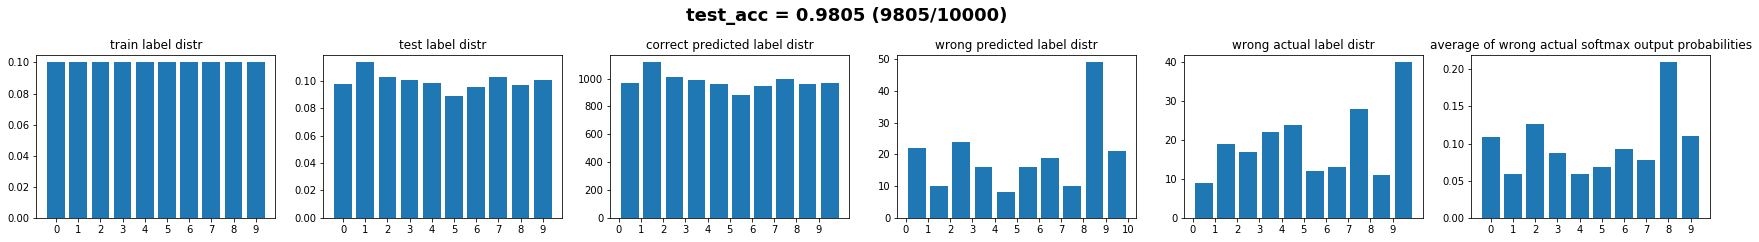

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_1_10000samples_2018_05_07---10_39.model.ckpt
test_loss = 0.1130, test_acc = 0.9711 (9711/10000)


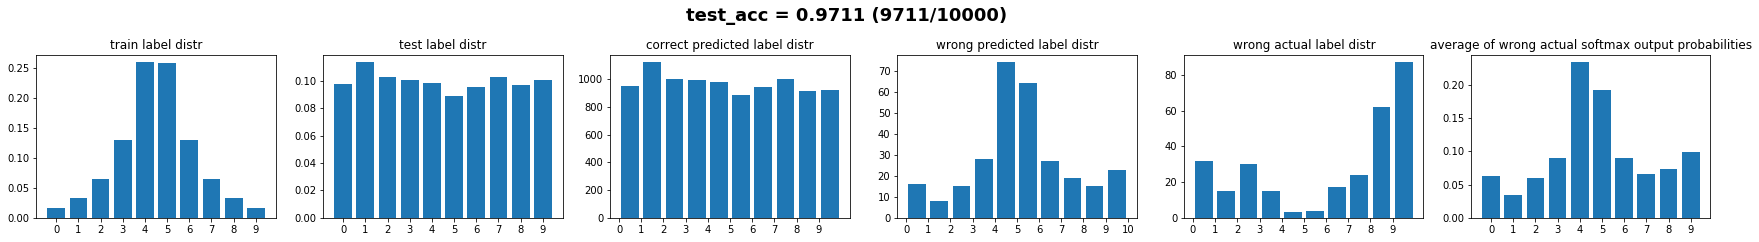

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_2_10000samples_2018_05_07---10_45.model.ckpt
test_loss = 0.0812, test_acc = 0.9782 (9782/10000)


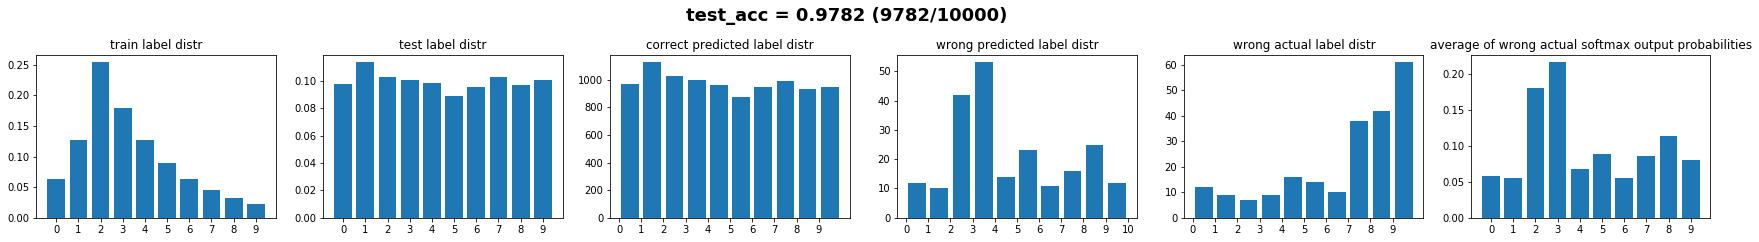

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_3_10000samples_2018_05_07---10_51.model.ckpt
test_loss = 0.0716, test_acc = 0.9806 (9806/10000)


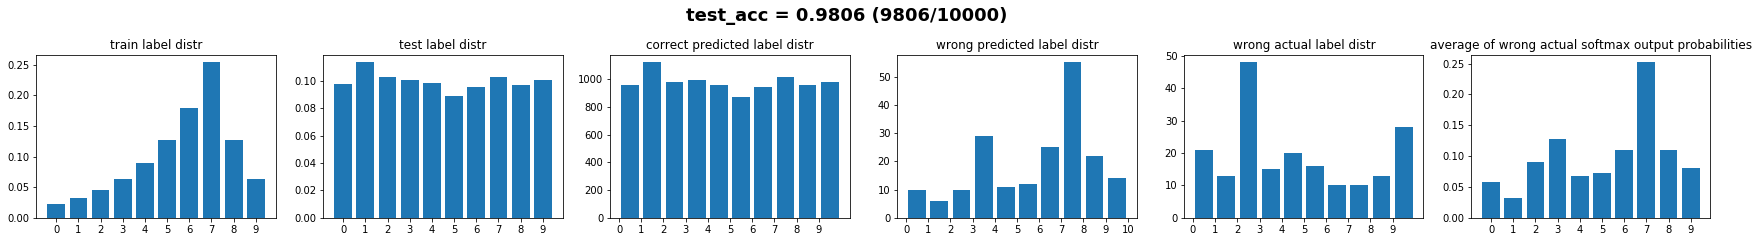

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_4_10000samples_2018_05_07---10_56.model.ckpt
test_loss = 0.0546, test_acc = 0.9846 (9846/10000)


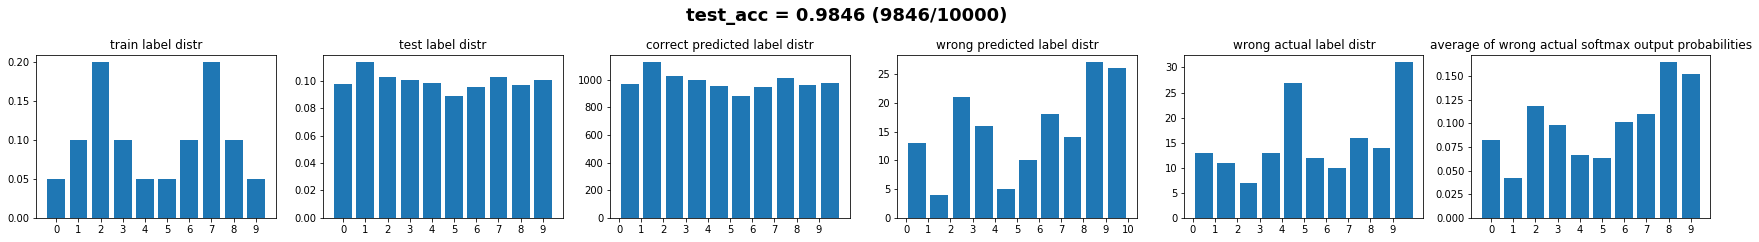

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_5_10000samples_2018_05_07---11_02.model.ckpt
test_loss = 0.0814, test_acc = 0.9791 (9791/10000)


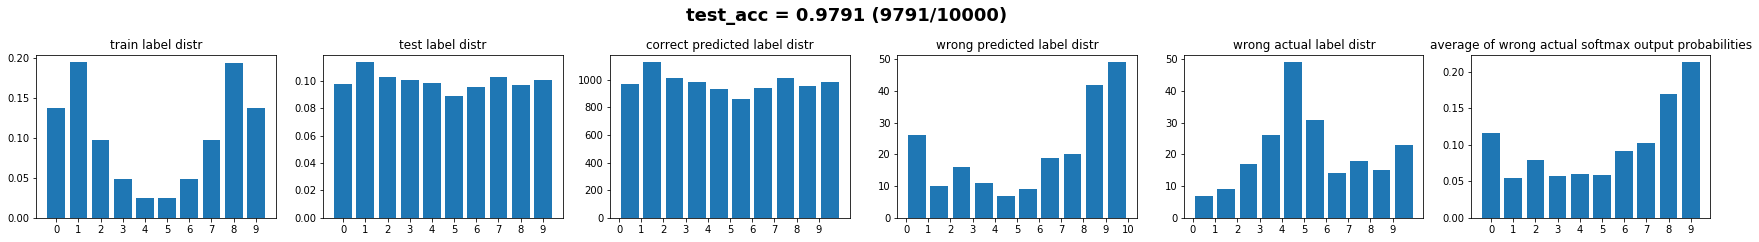

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_6_10000samples_2018_05_07---11_08.model.ckpt
test_loss = 0.1027, test_acc = 0.9725 (9725/10000)


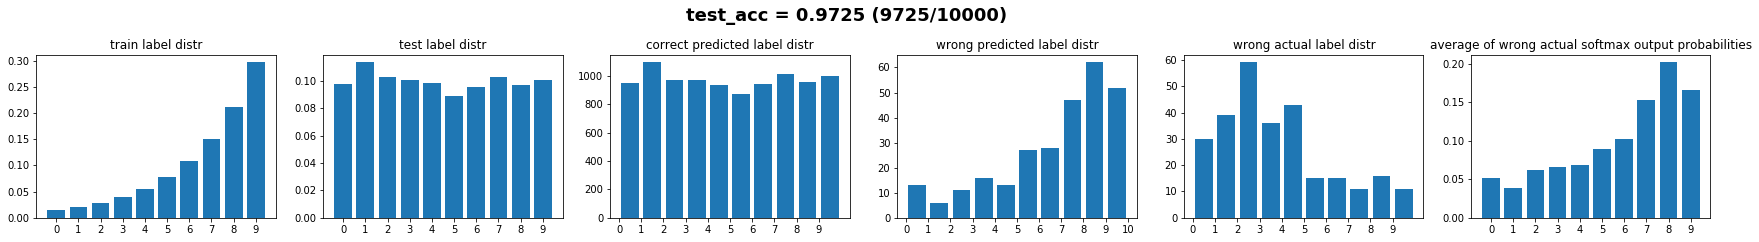

Restoring model from ./results/PriorProbabilityShift_experiment_5_10000samples/Lenet5_with_imposed_distr_7_10000samples_2018_05_07---11_14.model.ckpt
test_loss = 0.1245, test_acc = 0.9722 (9722/10000)


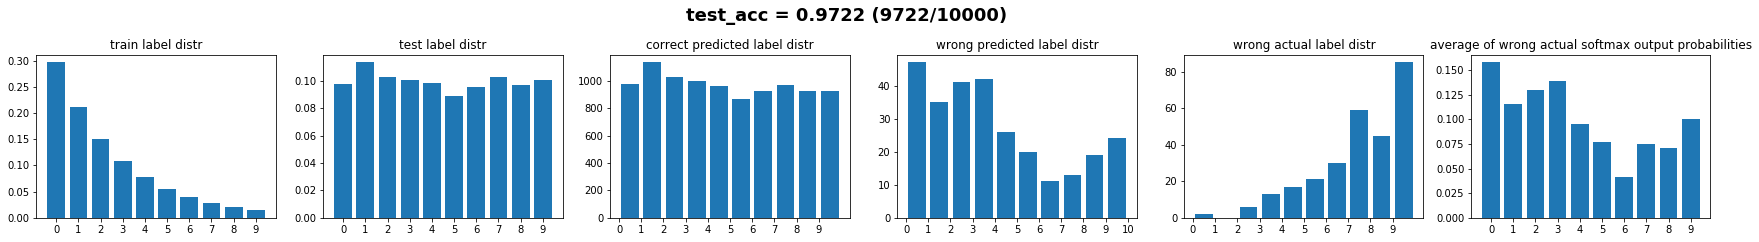

In [37]:
# ckpt_dir = './results/PriorProbabilityShift_experiment_5/'
ckpt_dir = './results/PriorProbabilityShift_experiment_5_10000samples/'
ckpt_file_list = get_all_files_from_dir_ending_with(ckpt_dir, "ckpt.meta", without_file_extension=True)
for idx, ckpt_file in enumerate(ckpt_file_list):
    mnist_ds = MNISTDataset(MNIST_TRAIN_IMAGES_FILEPATH, MNIST_TRAIN_LABELS_FILEPATH, MNIST_TEST_IMAGES_FILEPATH, MNIST_TEST_LABELS_FILEPATH)
    # test on all original data distribution, without imposing any distribution
    restore_and_test_a_model_on_a_mnist_subset(mnist_ds, ckpt_dir=ckpt_dir, ckpt_filemame=ckpt_file, plot_filename = 'tested_on_all_data_{}'.format(idx))

Obs. In many situations, wrong predicted distributions are correlated to train distributions (especially when train distribution is very skewed). So the model tends to predict based what it has seen the most during the training.